In [56]:
%config Completer.use_jedi = False # To make auto-complete faster

#Reloads imported files automatically
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../utils/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:87% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import copy
import time
import os
from scipy.ndimage import gaussian_filter

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import matplotlib.colors as mplcolors
from matplotlib import colormaps as mplcmaps
import matplotlib.cm as cm

from matplotlib_params import set_matplotlib_params,reset_rcParams
set_matplotlib_params()

In [3]:
import compute_variables as CV
import miscellaneous_functions as MF
import plotting_helpers as PH
import mixed_plots as MP
import ellipse_functions as EF
import velocity_plot
import coordinates
import variable_values_and_errors as val_err
import load_sim
import load_data
import map_functions as mapf

In [453]:
# degree_symbol = '°'
degree_symbol = '^\circ'

mass_density_label = r"$\Sigma \hspace{0.3} [\rm M_\odot kpc^{-2}]$"

# Load

In [6]:
dummy_df = pd.DataFrame([[1,2,3],[2,3,1],[6,3,4]], columns=['a','b','c'])

In [6]:
general_path = '/Users/luismi/Desktop/MRes_UCLan/'

In [7]:
zabs = True
# zabs = False

R0 = 8.1

GSR = True
# GSR = False

## Sim

In [8]:
sim_choice = "708main" #stuart

rot_angle = 27
pos_scaling = 1.7
axisymmetric = False

if True:
    if rot_angle != 27: 
        print(f"Rot angle {rot_angle}")
    if axisymmetric:
        print("Axisymmetric")
    if not zabs:
        print("Not zabs")
    if pos_scaling != 1.7:
        print(f"Sim scaling {pos_scaling}")

In [9]:
load_chunk = False

if not load_chunk:
    np_path = general_path+f"708main_simulation/numpy_arrays/R0_{R0}/"
        
    df0 = load_sim.load_simulation(path=np_path, choice=sim_choice, rot_angle = rot_angle, axisymmetric=axisymmetric, GSR=GSR,zabs=zabs, pos_factor=pos_scaling,R0=R0)
else:
    if sim_choice == "708main" and rot_angle == 27 and not axisymmetric and zabs and sim_scaling == 1.7:
        pickle_name = "df_bulge_zabs.pkl"
        df0 = pd.read_pickle("708main_simulation/"+pickle_name)

708MWout_bar27_scale1.7_8.1R0.npy loaded successfully.


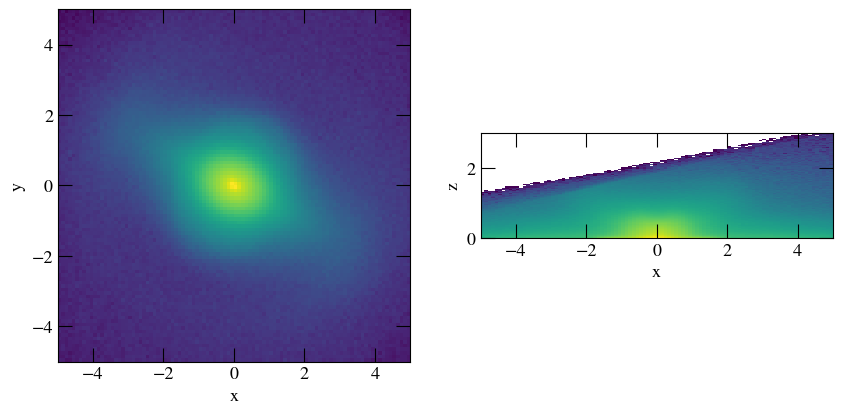

In [10]:
MP.quick_show_xy_xz(df0)

sim_visualise_cuts_lmax2_bmax1.5_dmax11.1_R08.1_R_gc3.5


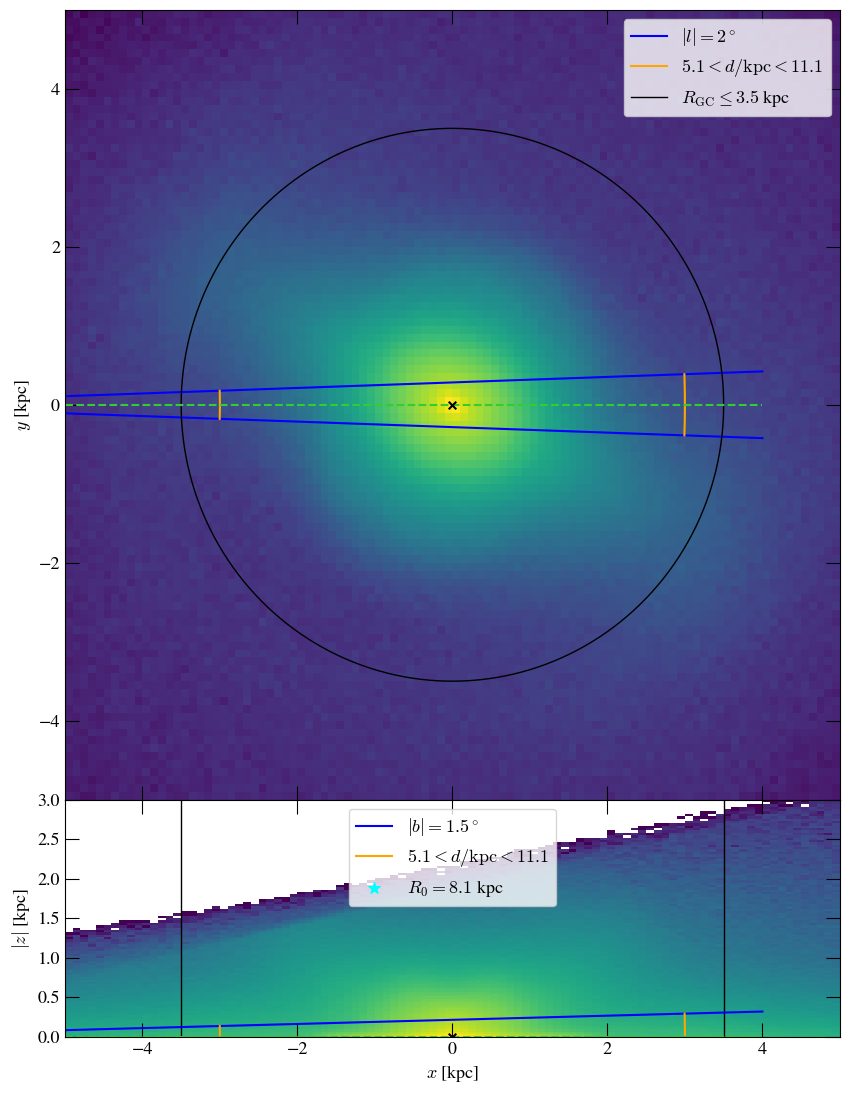

In [12]:
# R_shift = 0.1
R_shift = None

# save_bool = True
save_bool = False

if True:
    
    xymax = 5
    zmax = 3
    
    aspect_ratio = (xymax+zmax)/(xymax+1)
    
    fig,axs=plt.subplots(figsize=(10,aspect_ratio*10),nrows=2,sharex=True,gridspec_kw={"hspace":0,"height_ratios":[1,zmax/(2*xymax)]})
    
    MP.quick_show_xy_xz(df0,given_axs=axs)
    
    plot_cuts = MP.visualise_bulge_selection(given_axs=axs,cuts={"lmax":2,"bmax":1.5})
    
    if R_shift is not None:
        MP.plot_circle(axs[0],radius=3.5,centre=[R_shift,0],color="r",label=r"$(R_\mathrm{GC}-%s)\leq %s$ kpc"%(R_shift,3.5),lw=1)
        axs[1].axvline(x=-3.5+R_shift,color="red")
        axs[1].axvline(x=3.5+R_shift,color="red")
        
    axs[0].legend()
    axs[1].legend()
    
    if True: # filename and saving
        filename = f"sim_visualise_cuts"
        for cut in plot_cuts:
            filename += f"_{cut}{plot_cuts[cut]}"

        if R_shift is not None:
            filename += f"_Rshift{R_shift}"

        if save_bool:
            if os.path.isdir("graphs/other_plots/visualise_bulge_cuts/"):
                save_path = "graphs/other_plots/visualise_bulge_cuts/"
            else:
                raise ValueError("Save path not specified")

            for fileformat in [".png"]:
                plt.savefig(save_path+filename+fileformat, dpi=200,bbox_inches="tight")
                print("Saved",save_path+filename+fileformat)
        else:
            print(filename)
    
    plt.show()

## Observations
Apogee

In [20]:
# obs_errors = True
obs_errors = False

data_zabs = True
# data_zabs = False

In [21]:
data = load_data.load_and_process_data(error_bool = obs_errors, zabs = data_zabs, R0=R0,GSR=GSR)

Working with zabs == True; GSR == True.
Found 13031 total stars.
Removed 2545 bad indices, leaving 10486 stars.


#Gaia DR2 only:

import load_data

data_path = general_path+'Observational_data/gaia_DR2/'
obs_errors = False

data = load_data.load_data(data_path = data_path, error_bool = obs_errors, zabs = zabs)

# Dynamical + blobs

In [30]:
import dynamical_binning as dyn

from shapely.geometry import MultiPoint, Point, Polygon
import matplotlib.path as mpltPath

In [31]:
remove_unbound_regions = False

In [388]:
plt.rcParams["font.size"]=15

## Hull + blobs (metal-rich v_r)

In [372]:
o_min_star_number = 75

In [373]:
kws, _, cmap, compute_variable = get_kws_symmetric_cmap_and_compute_variable_function("mean_vx")

In [374]:
data_rich = data[data["FeH"] > -0.23]

all_x_values = data_rich[x_variable].values
all_y_values = data_rich[y_variable].values
all_input_points = np.column_stack([all_x_values,all_y_values])

min_l_dyn = -6.5
max_l_dyn = 6.5
min_b_dyn = 0
max_b_dyn = 6.5

data_within_lims = data_rich[(data_rich["l"]>min_l_dyn)&(data_rich["l"]<max_l_dyn)&(data_rich["b"]>min_b_dyn)&(data_rich["b"]<max_b_dyn)]

x_values_dyn = data_within_lims[x_variable].values
y_values_dyn = data_within_lims[y_variable].values
input_points_dyn = np.column_stack([x_values_dyn,y_values_dyn])

pts = MultiPoint([Point(i) for i in input_points_dyn])
mask = pts.convex_hull

In [375]:
circle_radius = 0.9

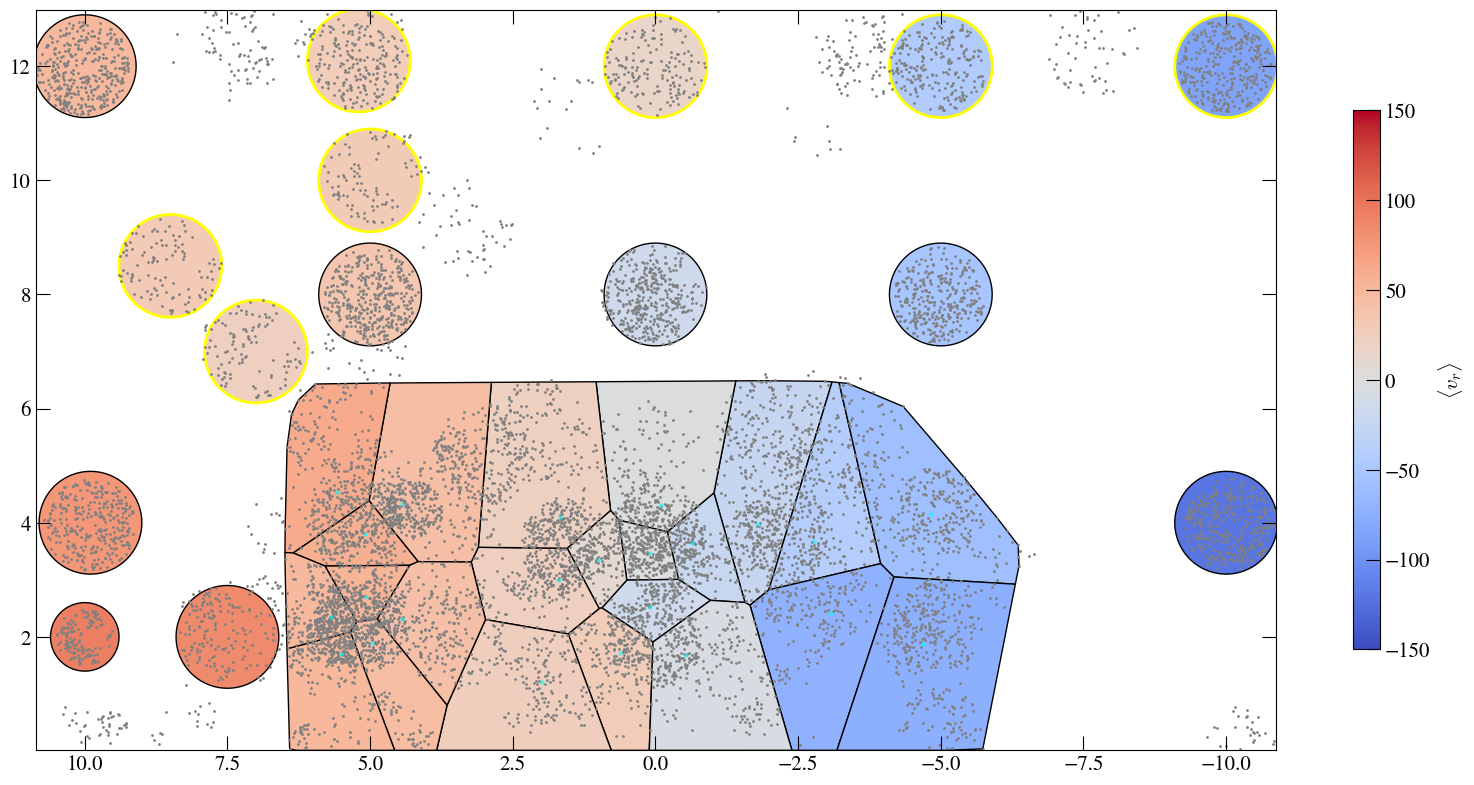

In [389]:
map_variable = "mean_vx"
norm = plt.Normalize(-150, 150)

kws, _, cmap, compute_variable = get_kws_symmetric_cmap_and_compute_variable_function(map_variable)

vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, o_min_star_number, remove_unbound_regions=remove_unbound_regions)
point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn, remove_unbound_regions=remove_unbound_regions)
computed_values = dyn.compute_values(vor.regions, data_within_lims, point_region, compute_variable_function=compute_variable,**kws)

if True: # plot
    f, ax = plt.subplots(figsize=(20,10))

    for i, cell_vertices in enumerate(vor.regions):
        polygon = vor.vertices[cell_vertices]

        shape = list(polygon.shape)
        shape[0] += 1
        p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

        ax.fill(*p.exterior.coords.xy, edgecolor="k", facecolor=cmap(norm(computed_values[i])))

    circle_centres = [[-10,4],[-10,12],[-5,8],[-5,12],[0,8],[0,12],[5,8],[5.2,12.1],[9.9,4],[10,12]]
    extra_circles = [[5,10],[7.5,2],[7,7],[8.5,8.5],[10,2]]

    for centre in np.concatenate([circle_centres,extra_circles]):
        radius = 0.6 if centre[0] == 10 and centre[1] == 2 else circle_radius
        circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T

        points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)

        value = compute_variable(data_rich.iloc[points_inside], **kws)

        edge_color = "yellow" if sum(points_inside) < o_min_star_number else "k"
        lw = 2 if sum(points_inside) < o_min_star_number else 1

        ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, lw=lw, facecolor=cmap(norm(value)))

    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=kinematic_symbol_dict[map_variable],shrink=0.7)

    # ax.plot([min_l_dyn,min_l_dyn,max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn,max_b_dyn,min_b_dyn],color="red")
    ax.scatter(data["l"],data["b"],color="grey",s=1)
    ax.scatter(points[:,0],points[:,1],color="cyan",alpha=0.5,s=5)
    ax.set_xlim(data["l"].max(),data["l"].min())
    ax.set_ylim(data["b"].min(),data["b"].max())
    ax.set_aspect('equal')

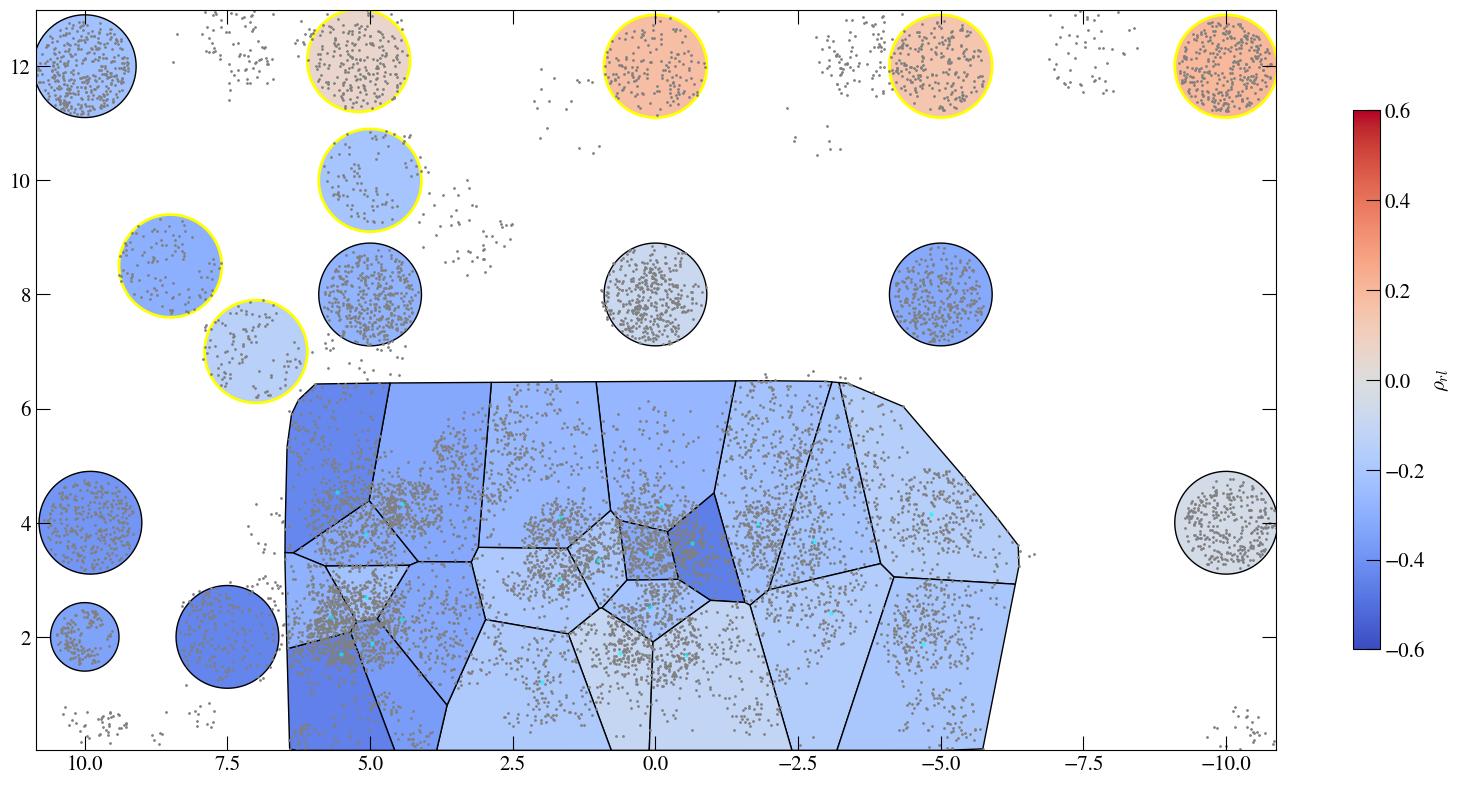

In [390]:
map_variable = "correlation"
norm = plt.Normalize(-0.6, 0.6)

kws, _, cmap, compute_variable = get_kws_symmetric_cmap_and_compute_variable_function(map_variable)

vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, o_min_star_number, remove_unbound_regions=remove_unbound_regions)
point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn, remove_unbound_regions=remove_unbound_regions)
computed_values = dyn.compute_values(vor.regions, data_within_lims, point_region, compute_variable_function=compute_variable,**kws)

if True: # plot
    f, ax = plt.subplots(figsize=(20,10))

    for i, cell_vertices in enumerate(vor.regions):
        polygon = vor.vertices[cell_vertices]

        shape = list(polygon.shape)
        shape[0] += 1
        p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

        ax.fill(*p.exterior.coords.xy, edgecolor="k", facecolor=cmap(norm(computed_values[i])))

    circle_centres = [[-10,4],[-10,12],[-5,8],[-5,12],[0,8],[0,12],[5,8],[5.2,12.1],[9.9,4],[10,12]]
    extra_circles = [[5,10],[7.5,2],[7,7],[8.5,8.5],[10,2]]

    for centre in np.concatenate([circle_centres,extra_circles]):
        radius = 0.6 if centre[0] == 10 and centre[1] == 2 else circle_radius
        circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T

        points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)

        value = compute_variable(data_rich.iloc[points_inside], **kws)

        edge_color = "yellow" if sum(points_inside) < o_min_star_number else "k"
        lw = 2 if sum(points_inside) < o_min_star_number else 1

        ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, lw=lw, facecolor=cmap(norm(value)))

    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=kinematic_symbol_dict[map_variable],shrink=0.7)

    # ax.plot([min_l_dyn,min_l_dyn,max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn,max_b_dyn,min_b_dyn],color="red")
    ax.scatter(data["l"],data["b"],color="grey",s=1)
    ax.scatter(points[:,0],points[:,1],color="cyan",alpha=0.5,s=5)
    ax.set_xlim(data["l"].max(),data["l"].min())
    ax.set_ylim(data["b"].min(),data["b"].max())
    ax.set_aspect('equal')

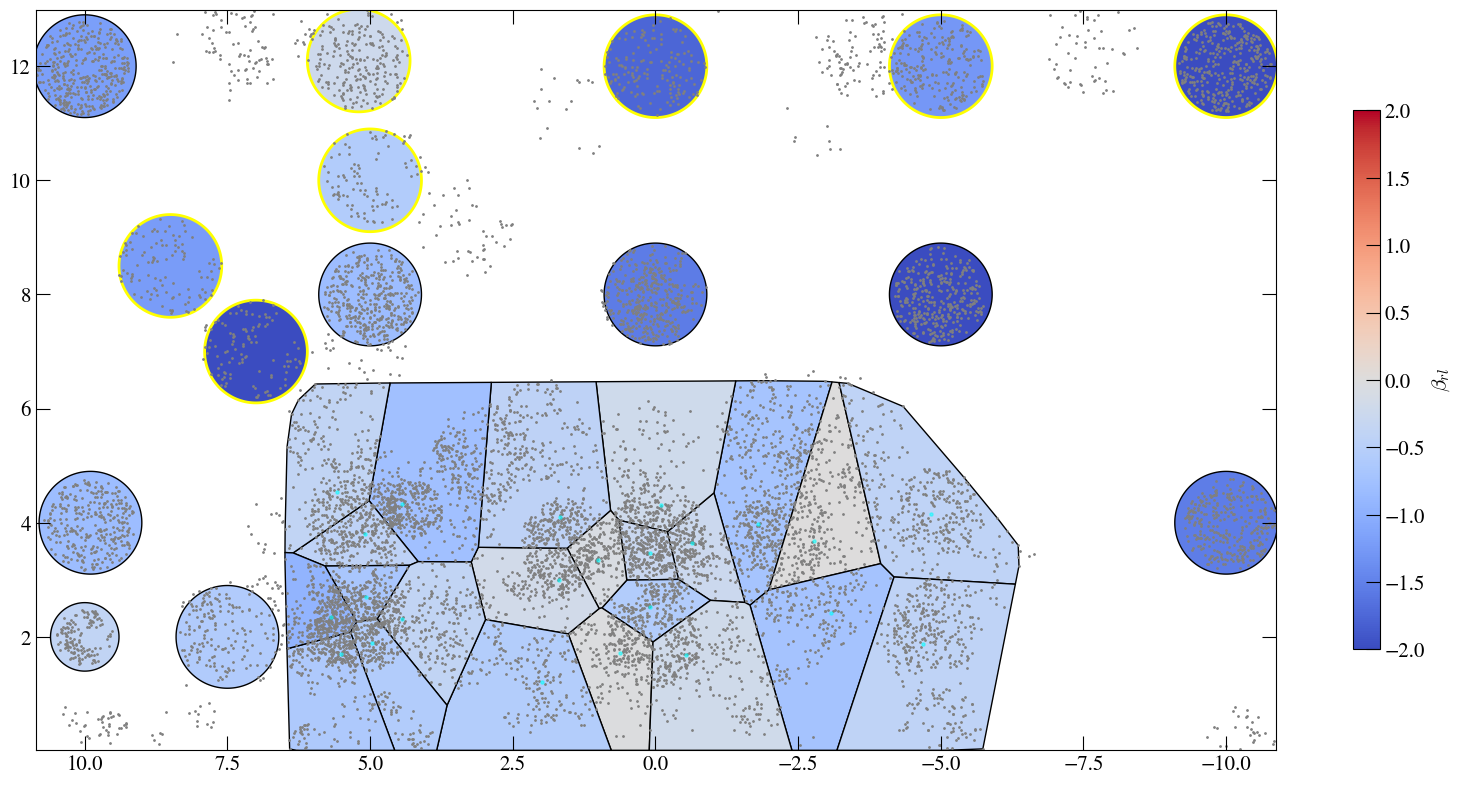

In [391]:
map_variable = "anisotropy"
norm = plt.Normalize(-2, 2)

kws, _, cmap, compute_variable = get_kws_symmetric_cmap_and_compute_variable_function(map_variable)

vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, o_min_star_number, remove_unbound_regions=remove_unbound_regions)
point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn, remove_unbound_regions=remove_unbound_regions)
computed_values = dyn.compute_values(vor.regions, data_within_lims, point_region, compute_variable_function=compute_variable,**kws)

if True: # plot
    f, ax = plt.subplots(figsize=(20,10))

    for i, cell_vertices in enumerate(vor.regions):
        polygon = vor.vertices[cell_vertices]

        shape = list(polygon.shape)
        shape[0] += 1
        p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

        ax.fill(*p.exterior.coords.xy, edgecolor="k", facecolor=cmap(norm(computed_values[i])))

    circle_centres = [[-10,4],[-10,12],[-5,8],[-5,12],[0,8],[0,12],[5,8],[5.2,12.1],[9.9,4],[10,12]]
    extra_circles = [[5,10],[7.5,2],[7,7],[8.5,8.5],[10,2]]

    for centre in np.concatenate([circle_centres,extra_circles]):
        radius = 0.6 if centre[0] == 10 and centre[1] == 2 else circle_radius
        circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T

        points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)

        value = compute_variable(data_rich.iloc[points_inside], **kws)

        edge_color = "yellow" if sum(points_inside) < o_min_star_number else "k"
        lw = 2 if sum(points_inside) < o_min_star_number else 1

        ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, lw=lw, facecolor=cmap(norm(value)))

    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=kinematic_symbol_dict[map_variable],shrink=0.7)

    # ax.plot([min_l_dyn,min_l_dyn,max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn,max_b_dyn,min_b_dyn],color="red")
    ax.scatter(data["l"],data["b"],color="grey",s=1)
    ax.scatter(points[:,0],points[:,1],color="cyan",alpha=0.5,s=5)
    ax.set_xlim(data["l"].max(),data["l"].min())
    ax.set_ylim(data["b"].min(),data["b"].max())
    ax.set_aspect('equal')

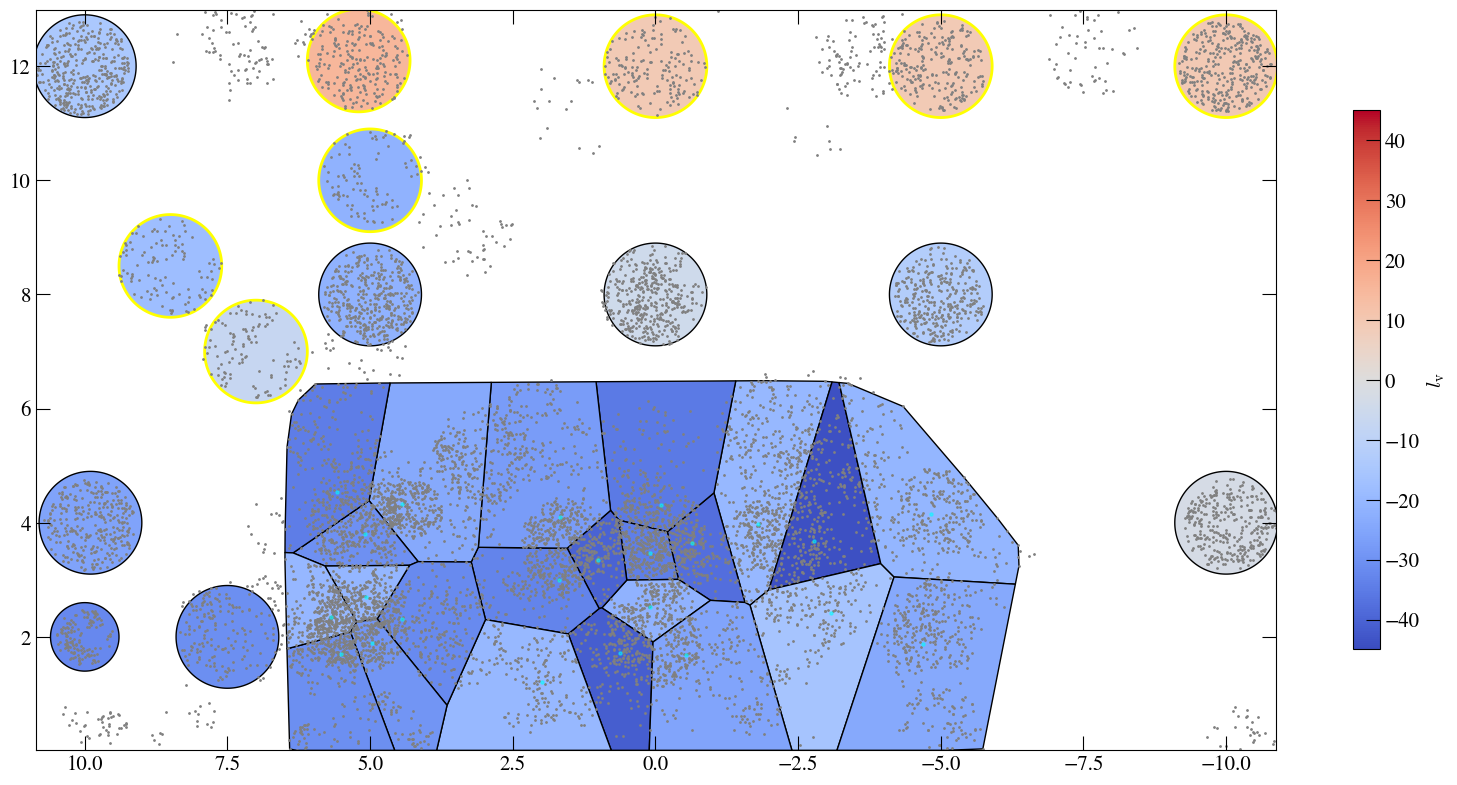

In [392]:
map_variable = "tilt_abs"
norm = plt.Normalize(-45, 45)

kws, _, cmap, compute_variable = get_kws_symmetric_cmap_and_compute_variable_function(map_variable)

vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, o_min_star_number, remove_unbound_regions=remove_unbound_regions)
point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn, remove_unbound_regions=remove_unbound_regions)
computed_values = dyn.compute_values(vor.regions, data_within_lims, point_region, compute_variable_function=compute_variable,**kws)

if True: # plot
    f, ax = plt.subplots(figsize=(20,10))

    for i, cell_vertices in enumerate(vor.regions):
        polygon = vor.vertices[cell_vertices]

        shape = list(polygon.shape)
        shape[0] += 1
        p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)

        ax.fill(*p.exterior.coords.xy, edgecolor="k", facecolor=cmap(norm(computed_values[i])))

    circle_centres = [[-10,4],[-10,12],[-5,8],[-5,12],[0,8],[0,12],[5,8],[5.2,12.1],[9.9,4],[10,12]]
    extra_circles = [[5,10],[7.5,2],[7,7],[8.5,8.5],[10,2]]

    for centre in np.concatenate([circle_centres,extra_circles]):
        radius = 0.6 if centre[0] == 10 and centre[1] == 2 else circle_radius
        circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T

        points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)

        value = compute_variable(data_rich.iloc[points_inside], **kws)

        edge_color = "yellow" if sum(points_inside) < o_min_star_number else "k"
        lw = 2 if sum(points_inside) < o_min_star_number else 1

        ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, lw=lw, facecolor=cmap(norm(value)))

    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=kinematic_symbol_dict[map_variable],shrink=0.7)

    # ax.plot([min_l_dyn,min_l_dyn,max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn,max_b_dyn,min_b_dyn],color="red")
    ax.scatter(data["l"],data["b"],color="grey",s=1)
    ax.scatter(points[:,0],points[:,1],color="cyan",alpha=0.5,s=5)
    ax.set_xlim(data["l"].max(),data["l"].min())
    ax.set_ylim(data["b"].min(),data["b"].max())
    ax.set_aspect('equal')

## Hull + blobs (all stars)

In [328]:
o_min_star_number = 75

In [329]:
all_x_values = data[x_variable].values
all_y_values = data[y_variable].values
all_input_points = np.column_stack([all_x_values,all_y_values])

min_l_dyn = -6.5
max_l_dyn = 6.5
min_b_dyn = 0
max_b_dyn = 6.5

data_within_lims = o_df_extra[(o_df_extra["l"]>min_l_dyn)&(o_df_extra["l"]<max_l_dyn)&(o_df_extra["b"]>min_b_dyn)&(o_df_extra["b"]<max_b_dyn)]

x_values_dyn = data_within_lims[x_variable].values
y_values_dyn = data_within_lims[y_variable].values
input_points_dyn = np.column_stack([x_values_dyn,y_values_dyn])

vor, points = dyn.generate_2Dvor(x_values_dyn, y_values_dyn, o_min_star_number, remove_unbound_regions=remove_unbound_regions)
point_region = dyn.calculate_point_region(vor, x_values_dyn, y_values_dyn, remove_unbound_regions=remove_unbound_regions)
computed_values = dyn.compute_values(vor.regions, data_within_lims, point_region)

pts = MultiPoint([Point(i) for i in input_points_dyn])
mask = pts.convex_hull

In [336]:
norm = plt.Normalize(o_min_star_number, 400)
cmap = cm.viridis

circle_radius = 0.9

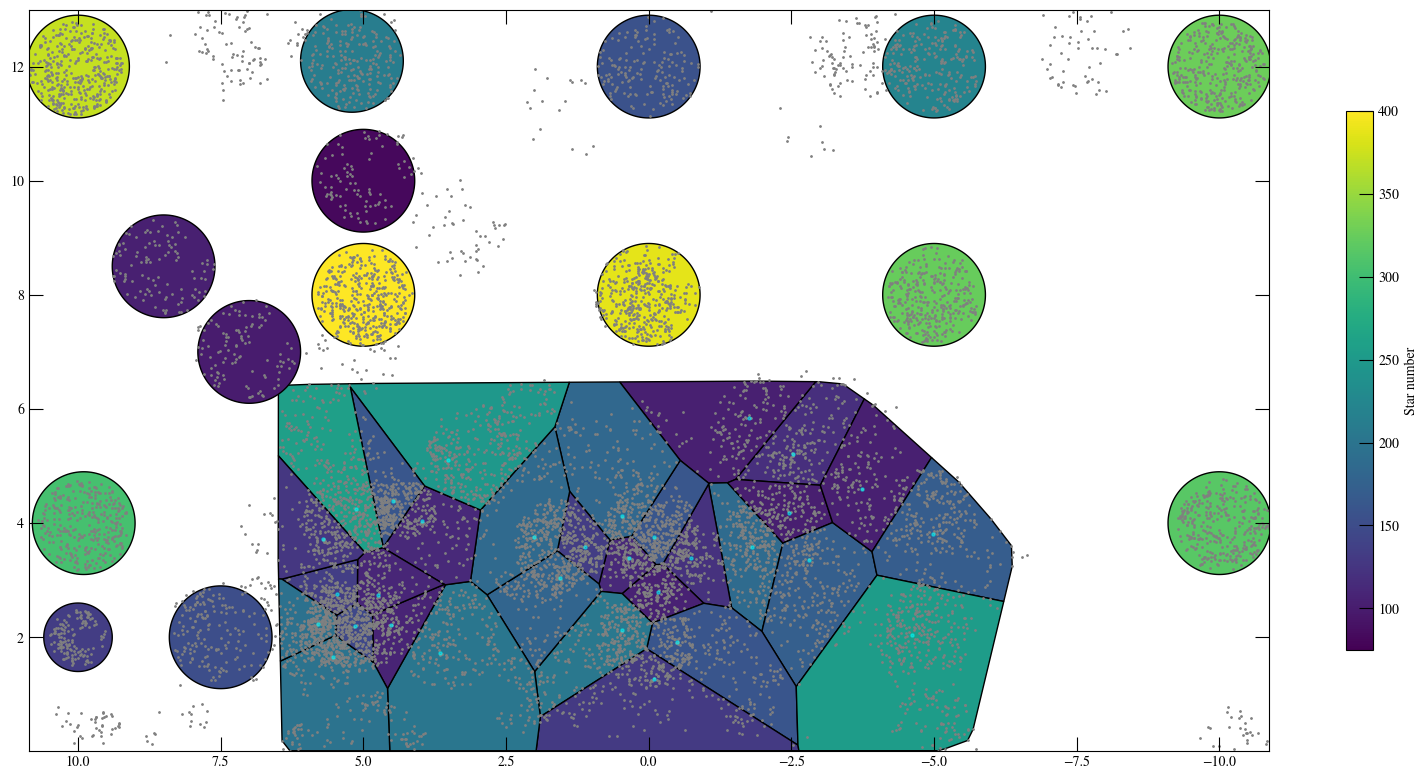

In [344]:
f, ax = plt.subplots(figsize=(20,10))

for i, cell_vertices in enumerate(vor.regions):
    polygon = vor.vertices[cell_vertices]
    
    shape = list(polygon.shape)
    shape[0] += 1
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
    
    ax.fill(*p.exterior.coords.xy, edgecolor="k", facecolor=cmap(norm(computed_values[i])))

circle_centres = [[-10,4],[-10,12],[-5,8],[-5,12],[0,8],[0,12],[5,8],[5.2,12.1],[9.9,4],[10,12]]
extra_circles = [[5,10],[7.5,2],[7,7],[8.5,8.5],[10,2]]

for centre in np.concatenate([circle_centres,extra_circles]):
    radius = 0.6 if centre[0] == 10 and centre[1] == 2 else circle_radius
    circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T
        
    points_inside = MF.in_circle(all_x_values, all_y_values, centre[0], centre[1], radius)
    
    edge_color = "r" if sum(points_inside) < o_min_star_number else "k"
    lw = 2 if sum(points_inside) < o_min_star_number else 1
    
    ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, lw=lw, facecolor=cmap(norm(sum(points_inside))))
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Star number',shrink=0.7)

# ax.plot([min_l_dyn,min_l_dyn,max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn,max_b_dyn,min_b_dyn],color="red")
ax.scatter(data["l"],data["b"],color="grey",s=1)
ax.scatter(points[:,0],points[:,1],color="cyan",alpha=0.5,s=5)
ax.set_xlim(data["l"].max(),data["l"].min())
ax.set_ylim(data["b"].min(),data["b"].max())
ax.set_aspect('equal')

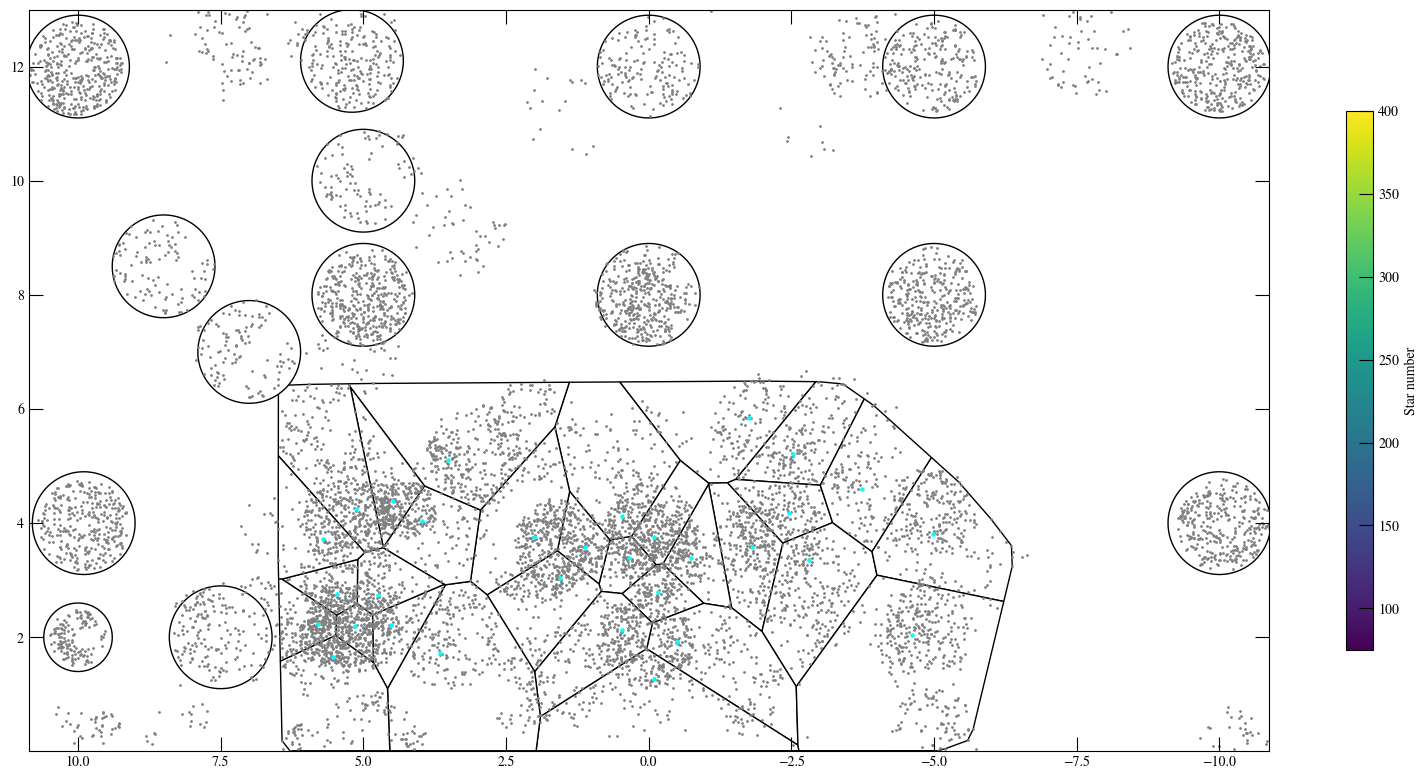

In [347]:
# No filling

f, ax = plt.subplots(figsize=(20,10))

for i, cell_vertices in enumerate(vor.regions):
    polygon = vor.vertices[cell_vertices]
    
    shape = list(polygon.shape)
    shape[0] += 1
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
    
    ax.fill(*p.exterior.coords.xy, edgecolor="k", facecolor="white")

circle_centres = [[-10,4],[-10,12],[-5,8],[-5,12],[0,8],[0,12],[5,8],[5.2,12.1],[9.9,4],[10,12]]
extra_circles = [[5,10],[7.5,2],[7,7],[8.5,8.5],[10,2]]

for centre in np.concatenate([circle_centres,extra_circles]):
    radius = 0.6 if centre[0] == 10 and centre[1] == 2 else circle_radius
    circle = np.array(PH.get_ellipse_coords(radius, ratio=1, centre=centre, tilt=0)).T
    
    edge_color = "r" if sum(points_inside) < o_min_star_number else "k"
    lw = 2 if sum(points_inside) < o_min_star_number else 1
    
    ax.fill(circle[:,0],circle[:,1], edgecolor=edge_color, facecolor="white")
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Star number',shrink=0.7)

# ax.plot([min_l_dyn,min_l_dyn,max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn,max_b_dyn,min_b_dyn],color="red")
ax.scatter(data["l"],data["b"],color="grey",s=1)
ax.scatter(points[:,0],points[:,1],color="cyan",s=5)
ax.set_xlim(data["l"].max(),data["l"].min())
ax.set_ylim(data["b"].min(),data["b"].max())
ax.set_aspect('equal')

## Hull for whole range

In [263]:
x_values = data[x_variable].values
y_values = data[y_variable].values

vor, points = dyn.generate_2Dvor(x_values, y_values, 200, remove_unbound_regions=remove_unbound_regions)
point_region = dyn.calculate_point_region(vor, x_values, y_values, remove_unbound_regions=remove_unbound_regions)
computed_values = dyn.compute_values(vor.regions, data, point_region)

pts = MultiPoint([Point(i) for i in np.column_stack([x_values,y_values])])
mask = pts.convex_hull

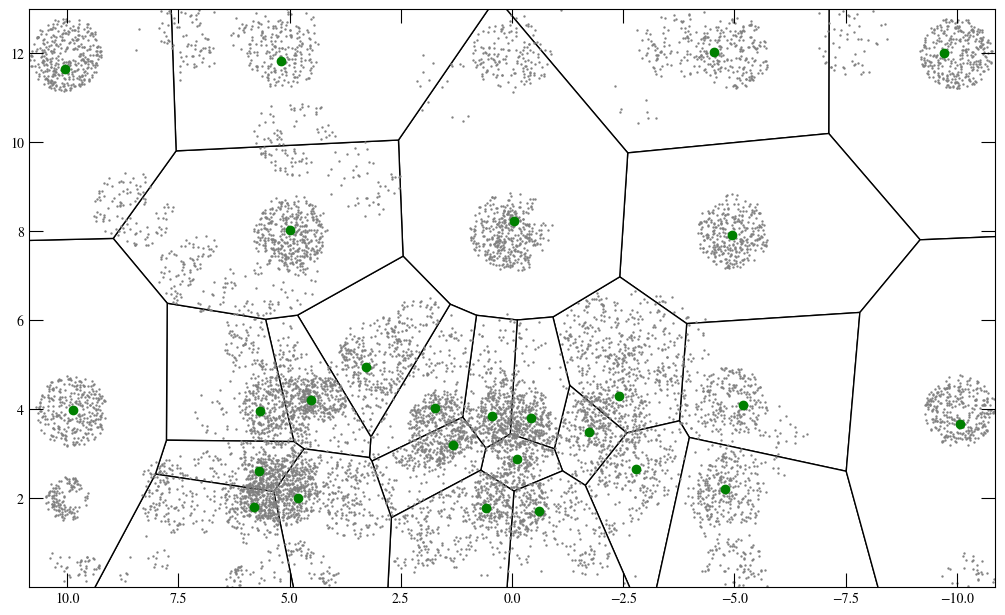

In [264]:
f, ax = plt.subplots(figsize=(15,7.5))

for cell_vertices in vor.regions:
    polygon = vor.vertices[cell_vertices]
    
#     poly = plt.Polygon(polygon.intersection(mask), edgecolor="k", lw=0.5, facecolor="white")
#     ax.add_patch(poly)
    
    shape = list(polygon.shape)
    shape[0] += 1
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape))#.intersection(mask)
    
    ax.fill(*p.exterior.coords.xy, edgecolor="k", facecolor="white")

# ax.plot([min_l_dyn,min_l_dyn,max_l_dyn,max_l_dyn],[min_b_dyn,max_b_dyn,max_b_dyn,min_b_dyn],color="red")
ax.scatter(data["l"],data["b"],color="grey",s=0.5)
ax.scatter(points[:,0],points[:,1],color="green")
ax.set_xlim(data["l"].max(),data["l"].min())
ax.set_ylim(data["b"].min(),data["b"].max())
ax.set_aspect('equal')

# Visualisation

In [15]:
save_path = general_path+"708main_simulation/graphs/Observations/Apogee/"

## Velocity plot

### Data

In [307]:
vel_lim = 400
lmax = 2
longitude_string = str(-lmax)+'l'+str(lmax)+'/'

In [ ]:
bulge_data = data[(data['b']<10)&(data['d']>6)&(data['d']<10)&(np.abs(data['l'])<10)]
low_vel_data = bulge_data[(np.abs(bulge_data['vr'])<vel_lim)&(np.abs(bulge_data['vl'])<vel_lim)]
long_cut_data = low_vel_data[np.abs(low_vel_data['l'])<lmax]

In [290]:
# LOOP OVER METALLICITY IN STEPS

step = 0.1

low_metal = -1
high_metal = 0

# low_metal = -0.3
# high_metal = 0.5

metal_cut = np.arange(low_metal, high_metal + step, step)
x_vel_list,y_vel_list = [],[]

old = True
# old = False

for cut in metal_cut:
    metal_data = long_cut_data[long_cut_data['FeH']<cut] if old else long_cut_data[long_cut_data['FeH']>cut]
    x_vel_list.append(metal_data.vr.values)
    y_vel_list.append(metal_data.vl.values)
    
save_path_data = save_path+'vel_plots/'+longitude_string+'all_metal/'
MF.create_dir(save_path_data)

for i,(vx,vy,cut) in enumerate(zip(x_vel_list,y_vel_list,metal_cut)):
    velocity_plot.velocity_plot(vx,vy,contour_levels=8,save_path=save_path_data,population_string='less' if old else 'more'+str(np.float16(cut)),
                                show=False,save=True,bootstrap_repeat=500)

Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-1l1/all_metal/velocity_less-1.0.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-1l1/all_metal/velocity_less-0.9.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-1l1/all_metal/velocity_less-0.8.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-1l1/all_metal/velocity_less-0.7.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-1l1/all_metal/velocity_less-0.6.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-1l1/all_metal/velocity_less-0.5.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-1l1/all_metal/velocit

In [23]:
# APOGEE poor, intermediate, rich

poor_lim,rich_lim = -0.6, -0.2

metal_string = f"{poor_lim}_{rich_lim}/"
poor_string = f'[FeH]{poor_lim}'
inter_string = f'{poor_lim}[FeH]{rich_lim}'
rich_string = f'{rich_lim}[FeH]'

save_path_pops = save_path+"vel_plots/"+longitude_string+metal_string
MF.create_dir(save_path_pops)

poor_data = long_cut_data[long_cut_data['FeH']<poor_lim]
intermediate_data = long_cut_data[(long_cut_data['FeH']>poor_lim)&(long_cut_data['FeH']<rich_lim)]
rich_data = long_cut_data[long_cut_data['FeH']>rich_lim]

for i,(dataframe,pop) in enumerate(zip([poor_data,intermediate_data,rich_data], ["poor","intermediate","rich"])):
    
    vx,vy = dataframe.vr.values,dataframe.vl.values
    velocity_plot.velocity_plot(vx,vy,contour_levels=8,save_path=save_path_pops,population_string=str(i+1)+'_'+pop,
                                    show=False,save=True,bootstrap_repeat=100)

Created successfully
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-2l2/-0.6_-0.2/velocity_1_poor.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-2l2/-0.6_-0.2/velocity_2_intermediate.png
Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-2l2/-0.6_-0.2/velocity_3_rich.png


### Sim

In [ ]:
vel_lim = 400

In [304]:
df_bulge = df0[(df0['b']<10)&(np.abs(df0['l'])<10)&(df0['d']<10)&(df0['d']>6)]

In [ ]:
# BW
BW = df_bulge[(df_bulge['age']>9.98)&(df_bulge['l']<-0.5)&(df_bulge['l']>-1.5)&(df_bulge['b']>3.5)&(df_bulge['b']<4.5)]

velocity_plot.velocity_plot(BW.vr.values,BW.vl.values,contour_levels=8,save_path=save_path+'vel_plots/'+'BW/',population_string=age_string,
                                    show=True,save=True,bootstrap_repeat=100)

In [ ]:
lmax = 2
longitude_string = str(-lmax)+'l'+str(lmax)+'/'

In [328]:
df_long = df_bulge[(np.abs(df_bulge['l'])<lmax)&(np.abs(df_bulge['vr'])<vel_lim)&(np.abs(df_bulge['vl'])<vel_lim)]

# bmin = 3.5
# bmax = 10
bmin = 1.5
bmax = 3.5
lat_string = f'_{bmin}b{bmax}'

df_lat = df_long[(df_long['b']>bmin)&(df_long['b']<bmax)]

Saved:	C:/Users/Luismi/JUPYTER_NOTEBOOKS/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/vel_plots/-2l2/velocity_9.97age_1.5b3.5.png


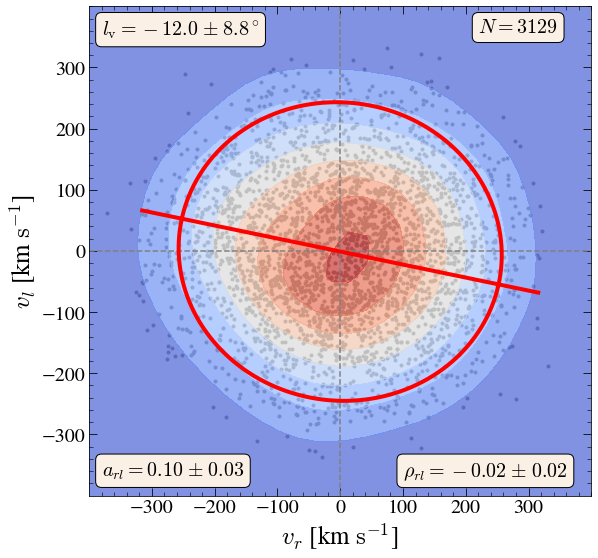

In [329]:
age_max = 9.97
df_age = df_lat[df_lat['age']>age_max]
age_string = f'{age_max}age'

vx,vy = df_age.vr.values,df_age.vl.values

velocity_plot.velocity_plot(vx,vy,contour_levels=8,save_path=save_path+'vel_plots/'+longitude_string,population_string=age_string+lat_string,
                                    show=True,save=True,bootstrap_repeat=100)

# Map stuff

In [13]:
full_map_string_list,divergent_map_list = mapf.get_map_string_lists()

In [14]:
full_map_string_list

['number',
 'mean_vx',
 'mean_vy',
 'mean_vx_error',
 'mean_vy_error',
 'std_vx',
 'std_vy',
 'std_vx_error',
 'std_vy_error',
 'anisotropy',
 'anisotropy_error',
 'correlation',
 'correlation_error',
 'tilt_abs',
 'tilt_abs_error',
 'spherical_tilt',
 'spherical_tilt_error']

In [931]:
_xy_max = 3.5
_xy_bins = 13

_z_max = 3
_z_bins = 11

_long_max = 20 if rot_angle == 90 else 11
_l_bins = 15

_lat_max = 13
_b_bins = 10

In [932]:
_o_xy_step = 0.5
_o_z_step = 0.5
_o_lb_step = 3

In [933]:
# map dictionaries
variable_symbol_dict, variable_units_dict = mapf.get_position_symbols_and_units_dict(zabs=zabs, degree_symbol=degree_symbol)

_xyz_tick_step = 1

map_min_dict = {
    "l" : -_long_max,
    "b" : 0 if zabs else -_lat_max,
    "d" : 6,
    "x" : -_xy_max,
    "y" : -_xy_max,
    "z" : -_z_max,
    "R" : 0.1,
    "phi" : -180
}
map_max_dict = {
    "l" : _long_max,
    "b" : _lat_max,
    "d" : 10,
    "x" : _xy_max,
    "y" : _xy_max,
    "z" : _z_max,
    "R" : 2, #maybe 1.5 judging by the xy map for 9.8-10 stars
    "phi" : 180
}
map_left_dict,map_right_dict = {},{}
for key in list(map_min_dict.keys()):
    map_left_dict[key] = map_max_dict[key] if key == 'l' else map_min_dict[key]
    map_right_dict[key] = map_min_dict[key] if key == 'l' else map_max_dict[key]

map_tick_step = {
    "l" : 3,
    "b" : 3,
    "d" : 1,
    "x" : _xyz_tick_step,
    "y" : _xyz_tick_step,
    "z" : _xyz_tick_step,
    "R" : 0.5,
    "phi" : 90
}
minor_locator_dict = {
    'R': 0.25,
    'phi': 45,
    'l': 1,
    'b': 1,
    'x': 0.5,
    'y': 0.5,
    "z": 0.5,
    'd': 0.5
}
map_hstep_dict = {
    "l" : (map_max_dict['l']-map_min_dict['l'])/_l_bins,
    "x" : (map_max_dict['x']-map_min_dict['x'])/_xy_bins,
    "z" : (map_max_dict['z']-map_min_dict['z'])/_z_bins,
    "R" : (map_max_dict['R']-map_min_dict['R'])/14,
}
o_map_hstep_dict = {
    "l" : _o_lb_step,
    "b" : _o_lb_step,
    "x" : _o_xy_step,
    "y" : _o_xy_step,
    "z" : _o_z_step,
}
map_vstep_dict = {
    "l" : (map_max_dict['l']-map_min_dict['l'])/_l_bins,
    "b" : (map_max_dict['b']-map_min_dict['b'])/_b_bins,
    "y" : (map_max_dict['y']-map_min_dict['y'])/_xy_bins,
    "z" : (map_max_dict['z']-map_min_dict['z'])/_z_bins,
    "phi" : (map_max_dict['phi']-map_min_dict['phi'])/15  #-180 to 180 with 15 bins gives step 24
}
o_map_vstep_dict = {
    "l" : _o_lb_step,
    "b" : _o_lb_step,
    "x" : _o_xy_step,
    "y" : _o_xy_step,
    "z" : _o_z_step
}
#Get the same number of "d" intervals as those of "l", so that the map has square pixels.
#The right d_step is given by l_step*Δd/Δl
map_hstep_dict["d"] = map_vstep_dict["l"]*(map_max_dict["d"]-map_min_dict["d"])/(map_max_dict["l"]-map_min_dict["l"])
map_vstep_dict["d"] = map_hstep_dict["d"]
o_map_hstep_dict["d"] = o_map_vstep_dict["l"]*(map_max_dict["d"]-map_min_dict["d"])/(map_max_dict["l"]-map_min_dict["l"])
o_map_vstep_dict["d"] = o_map_hstep_dict["d"]

In [934]:
# map functions

def create_map_array_dict(full_map_string_list, all_arrays):
    map_dict = {}
    for index, map_string in enumerate(full_map_string_list):
        map_dict[map_string] = all_arrays[index]    
    return map_dict

def get_map_limits(map_string, map_array, norm_index=slice(None), raw=False):
    """
    Params
    * norm_index
        Slice which you can pass in case you don't want to take the whole array into account
    * raw
        Set to True if you don't want to use pre-defined limits
    """
    
    if not raw and map_string in ["tilt_abs","vertex_abs","spherical_tilt_abs"]:
        max_value = 45
        min_value = -max_value
    elif not raw and map_string in ["tilt","vertex","spherical_tilt"]:
        max_value = 90
        min_value = -max_value
    elif not raw and map_string == "abs_spherical_tilt":
        max_value = 90
        min_value = 0
    elif "error" in map_string: #any type of error
        min_value = 0
        max_value = np.nanmax(map_array[map_string][norm_index])
#     elif map_string == "std_vx" or map_string == "std_vy":
#         min_value = 0
#         max_value = np.nanmax([map_array["std_vx"][norm_index], map_array["std_vy"][norm_index]])
#     elif map_string == "mean_vx" or map_string == "mean_vy":
#         mini = np.nanmin([map_array["mean_vx"],map_array["mean_vy"]])
#         maxi = np.nanmax([map_array["mean_vx"],map_array["mean_vy"]])

#         limits = [mini, maxi]

#         lims_factor = 1
#         min_value = -lims_factor*np.max(np.abs(limits))
#         max_value = lims_factor*np.max(np.abs(limits))
    elif map_string in divergent_map_list:
        mini = np.nanmin(map_array[map_string][norm_index])
        maxi = np.nanmax(map_array[map_string][norm_index])

        limits = [mini, maxi]

        lims_factor = 1
        min_value = -lims_factor*np.max(np.abs(limits))
        max_value = lims_factor*np.max(np.abs(limits))
        
    else:
        min_value = np.nanmin(map_array[map_string][norm_index])
        max_value = np.nanmax(map_array[map_string][norm_index])
    
    return min_value, max_value

# To compare, e.g. normal and axisymmetric models in the difmaps ---------------------------------------------
def create_map_diff_array_dict(all_comparing_arrays, map_dict):
    map_dict_diff = {
        "mean_vx" : all_comparing_arrays[0] - map_dict["mean_vx"],
        "mean_vy" : all_comparing_arrays[1] - map_dict["mean_vy"],
        "anisotropy" : all_comparing_arrays[2] - map_dict["anisotropy"],
        "std_vx" : all_comparing_arrays[3] - map_dict["std_vx"],
        "std_vy" : all_comparing_arrays[4] - map_dict["std_vy"],
        "correlation" : all_comparing_arrays[5] - map_dict["correlation"],
        "covariance" : all_comparing_arrays[6] - map_dict["covariance"],
        "vertex" : all_comparing_arrays[7] - map_dict["vertex"],
        "error" : all_comparing_arrays[8] - map_dict["error"],
        "number": all_comparing_arrays[9] - map_dict["number"]
    }
    map_dict_diff["var_difference"] = map_dict_diff["std_vx"] - map_dict_diff["std_vy"] - map_dict["var_difference"]
    map_dict_diff["cov_var_ratio"] = 2*map_dict_diff["covariance"] / (map_dict_diff["std_vx"] - map_dict_diff["std_vy"]) - map_dict["cov_var_ratio"]
    
    return map_dict_diff

In [935]:
data_trim = data[data["FeH"]>=-1]

b_min_range,b_max_range = PH.get_equal_n_minmax_b_ranges(data_trim)

b_index = 2

bmin,bmax = b_min_range[b_index],b_max_range[b_index]

print(bmin,bmax)

7.13475639098 8.85301437083


In [936]:
extra_variable_min_dict = {
    "b" : bmin,
    "d" : 5,
    "y" : -_xy_max,
    "x" : -_xy_max,
    "z" : 0.5,
    "R" : 0,
}
extra_variable_max_dict = {
    "b" : bmax,
    "d" : 11,
    "y" : _xy_max,
    "x" : _xy_max,
    "z" : _z_max,
    "R" : 3.5
}
extra_variable_map = {
    "lb" : "R",#"d",
    "dl" : "b",#z
    "xy" : "b",
    "Rphi" : "z",
    "yz": "x",
    "xz": "y"
}

min_angle = 3
max_angle = 
6*np.tan(np.radians(min_angle)), 6*np.tan(np.radians(max_angle)), 10*np.tan(np.radians(min_angle)), 10*np.tan(np.radians(max_angle))

In [937]:
#CHOOSE

x_variable = "x" #d #l
y_variable = "y"

vel_x_variable = 'r'#x_variable if x_variable != 'd' else 'r'
vel_y_variable = 'l'#y_variable #\phi

extra_variable = extra_variable_map[x_variable+y_variable]

In [938]:
sim_bool = True; data_bool = False
# sim_bool = False; data_bool = True

min_star_number = 100
if data_bool:
    o_min_star_number = 50
    
bootstrap_repeat = 500

In [939]:
kinematic_symbols_dict = mapf.get_kinematic_symbols_dict(x_variable=x_variable,
                                                         y_variable=y_variable,
                                                         vel_x_variable=vel_x_variable,
                                                         vel_y_variable=vel_y_variable)

kinematic_units_dict = mapf.get_kinematic_units_dict(position_variables=x_variable+y_variable,
                                                     vel_x_variable=vel_x_variable,
                                                     vel_y_variable=vel_y_variable)

In [940]:
# Variable limits, ticks

x_min, x_max = map_min_dict[x_variable], map_max_dict[x_variable]
x_left, x_right = map_left_dict[x_variable], map_right_dict[x_variable]
y_min, y_max = map_min_dict[y_variable], map_max_dict[y_variable]
x_step, y_step = map_hstep_dict[x_variable], map_vstep_dict[y_variable]

x_bin_number = MF.return_int_or_dec((x_max-x_min)/x_step)
y_bin_number = MF.return_int_or_dec((y_max-y_min)/y_step)

if data_bool:
    o_x_step, o_y_step = o_map_hstep_dict[x_variable], o_map_vstep_dict[y_variable]
extra_variable_min, extra_variable_max = extra_variable_min_dict[extra_variable], extra_variable_max_dict[extra_variable]
x_units, y_units, extra_variable_units = variable_units_dict[x_variable], variable_units_dict[y_variable], variable_units_dict[extra_variable]

spatial_cuts_dict = {
    x_variable: [x_min,x_max],
    y_variable: [y_min,y_max],
    extra_variable: [extra_variable_min,extra_variable_max]
}

x_label = variable_symbol_dict[x_variable] + r' $[\mathrm{%s}]$'%x_units
y_label = variable_symbol_dict[y_variable] + r' $[\mathrm{%s}]$'%y_units

x_ticks = mapf.get_map_tick_range(x_min,x_max,map_tick_step[x_variable])
y_ticks = mapf.get_map_tick_range(y_min,y_max,map_tick_step[y_variable])

x_minor_ticks = np.arange(x_min, x_max, np.diff(x_ticks)[0]/4)
y_minor_ticks = np.arange(y_min, y_max, np.diff(y_ticks)[0]/4)
x_minor_locator = minor_locator_dict[x_variable]
y_minor_locator = minor_locator_dict[y_variable]

vel_variables = vel_x_variable + vel_y_variable

print("You have chosen to work with an "+x_variable+y_variable+" map. The variable "+extra_variable\
      +f" goes from {extra_variable_min} to {extra_variable_max}{extra_variable_units}.")
print(f"{x_variable} defined in range({x_min},{x_max},{str(MF.return_int_or_dec(x_step,2))}), making {x_bin_number} bins%s"\
     %(f", where the left and right limits are {x_left},{x_right}" if x_min!=x_left else ""))
if data_bool:
    print(f"For the data the {x_variable} steps are instead {o_x_step}")
print(f"{y_variable} defined in range({y_min},{y_max},{str(MF.return_int_or_dec(y_step,2))}), making {y_bin_number} bins")
if data_bool:
    print(f"For the data the {y_variable} steps are instead {o_y_step}")
print("Minimum star number is",min_star_number if sim_bool else o_min_star_number)
print("Bootstrap repeat is set to",bootstrap_repeat)
print(f"\nYou are working with velocities v{vel_x_variable}-v{vel_y_variable}")

You have chosen to work with an xy map. The variable b goes from 7.13475639098 to 8.85301437083^\circ.
x defined in range(-3.5,3.5,0.54), making 13 bins
y defined in range(-3.5,3.5,0.54), making 13 bins
Minimum star number is 100
Bootstrap repeat is set to 500

You are working with velocities vr-vl


In [941]:
x_range = np.arange(x_min,x_max,x_step)
y_range = np.arange(y_min,y_max,y_step)

if True: # Fix potential overflow issue
    # I expect the ranges not to include the max value, but if the step is a periodic number it might. It is actually stated in the documentation:
    # https://numpy.org/doc/stable/reference/generated/numpy.arange.html#numpy.arange
    
    if np.float32(x_range[-1]) == x_max: 
        x_range = x_range[:-1]

    if np.float32(y_range[-1]) == y_max: 
        x_range = y_range[:-1]

extent = [x_min,x_max,y_min,y_max]

print(extent)

if data_bool:
    o_x_range = np.arange(x_min,x_max,o_x_step)
    o_y_range = np.arange(y_min,y_max,o_y_step)

[-3.5, 3.5, -3.5, 3.5]


In [942]:
# These functions currently need to be declared after declaring the limits and ticks as I am using them as global variables inside

def configure_ax():
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_minor_locator))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_minor_locator))
    ax.set_xticks(x_ticks);ax.set_yticks(y_ticks)
    ax.set_xlim(x_left,x_right)
    ax.set_ylim(y_min,y_max)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

def plot_values_heatmap(map_variable, map_arrays, red_limit_val=None, red_limit_below=False, extra_rounding_dec=1,save_bool=False,save_path="",return_axs=False,
                       limit_color="r"):
    
    vmin = np.nanmin(map_arrays)
    vmax = np.nanmax(map_arrays)
    norm = LogNorm(vmin,vmax) if map_variable == "number" else None
    cmap = "coolwarm" if map_variable in divergent_map_list else "viridis"

    fig,axs=plt.subplots(figsize=(30,15),ncols=2,gridspec_kw={"wspace":0.07})
    
    axs[0].imshow(map_arrays[0],vmin=vmin if map_variable!="number" else None,vmax=vmax if map_variable!="number" else None,origin="lower",cmap=cmap,extent=extent,norm=norm)
    h=axs[1].imshow(map_arrays[1],vmin=vmin if map_variable!="number" else None,vmax=vmax if map_variable!="number" else None,origin="lower",cmap=cmap,extent=extent,norm=norm)
    for i,ax in enumerate(axs):
        ax.set_xticks(x_ticks);ax.set_yticks(y_ticks)
        ax.set_xlabel(f"{variable_symbol_dict[x_variable]} [{variable_units_dict[x_variable]}]")
        if i == 0:
            ax.set_ylabel(f"{variable_symbol_dict[y_variable]} [{variable_units_dict[y_variable]}]")
        ax.tick_params(axis="both",direction="out",top=False,right=False)
        ax.set_aspect("equal")
        for r,row in enumerate(map_arrays[i]):
            for v,val in enumerate(row):
                val_str = "NaN" if np.isnan(val) else str(MF.return_int_or_dec(val,extra_dec=extra_rounding_dec))
                if map_variable == "number":
                    if red_limit_val is None: red_limit_val = min_star_number
                    
                    if val > 1000: c = "k"
                    elif val < red_limit_val: c = limit_color
                    else: c = "w"
                elif red_limit_val is not None:
                    c = "k" if (val > red_limit_val if red_limit_below else val < red_limit_val) else limit_color
                
                axs[i].text(x=v*x_step-x_max,y=r*y_step-y_max+y_step/2.5,s=val_str,size=17-len(val_str),c=c)
    if save_bool:
        plt.savefig(save_path+"star_number.png",dpi=300,bbox_inches="tight")
        print("Saved in",save_path+f"{map_variable}_values_heatmap.png")
    plt.show()
    
    if return_axs:
        return fig,axs

## Population cuts

In [943]:
spatial_cuts_dict

{'x': [-3.5, 3.5], 'y': [-3.5, 3.5], 'b': [7.13475639098, 8.85301437083]}

In [944]:
if sim_bool:
    df_extra = MF.apply_cuts_to_df(df0,spatial_cuts_dict)
    print("Working with sim")
if data_bool:
    
    # min_metal_cut = None
    min_metal_cut = -1

    metal_lowcut_dict = { "FeH": [min_metal_cut,999] } if min_metal_cut is not None else {}
    metal_lowcut_lim_dict = { "FeH": "both" } if min_metal_cut is not None else {}

    o_df_extra = MF.apply_cuts_to_df(data,[spatial_cuts_dict,metal_lowcut_dict])

    print("Working with observations")
    print(f"There are {len(o_df_extra)} datapoints")

Working with sim


In [945]:
young_and_old = True
steven_cuts = False #True if x_variable == 'x' else False
steven_older = False
oscar_cuts = False

if np.sum([young_and_old, steven_cuts, steven_older, oscar_cuts]) > 1:
    raise ValueError("You have to choose one age cut!")

if data_bool:
    divisions = 2
    halo_bool = False

In [946]:
if sim_bool:
    if young_and_old:
        if steven_cuts:
            age_min = 0
            young_max = 7
            old_min = 9
            old_max = 10
        elif steven_older:
            age_min = 0
            young_max = 7
            old_min = 9.8
            old_max = 10
        elif oscar_cuts:
            age_min = 5
            young_max = 9
            old_min = 9.8
            old_max = 10
        else: #Choose
            age_min = 4
            young_max = 7
            old_min = 9.5
            old_max = 10
            
            age_lowlims = [age_min,old_min]
            age_highlims =[young_max,old_max]
            
        age_range = [age_min, old_min]
        print("Ages",[[age_min,young_max],[old_min,old_max]])

#         label_young = f"${age_min}<$ Age/Gyr $<{young_max}$"
#         label_old = f"${old_min} <$Age/Gyr$<{old_max}$"
        label_young = "Young"
        label_old = "Old"
        
        young_lims = [age_min,young_max]
        old_lims = [old_min,old_max]

    else:
        age_min_real = 9
        age_max = 10
        age_step = 0.2
        age_range = np.arange(age_min_real,age_max,age_step)
        print(age_range)

        #If you do not want the minimum age to be special, then
        age_min = -1

Ages [[4, 7], [9.5, 10]]


In [947]:
if young_and_old:
    df_ages = [
        MF.apply_cuts_to_df(df_extra,{"age": young_lims}),
        MF.apply_cuts_to_df(df_extra,{"age": old_lims})
    ]

visualise_cuts_l2_b7.13_b8.85_Rgc2_Rgc3.5_xz
Saving in: graphs/other_plots/visualise_bulge_cuts/
.pdf
.png


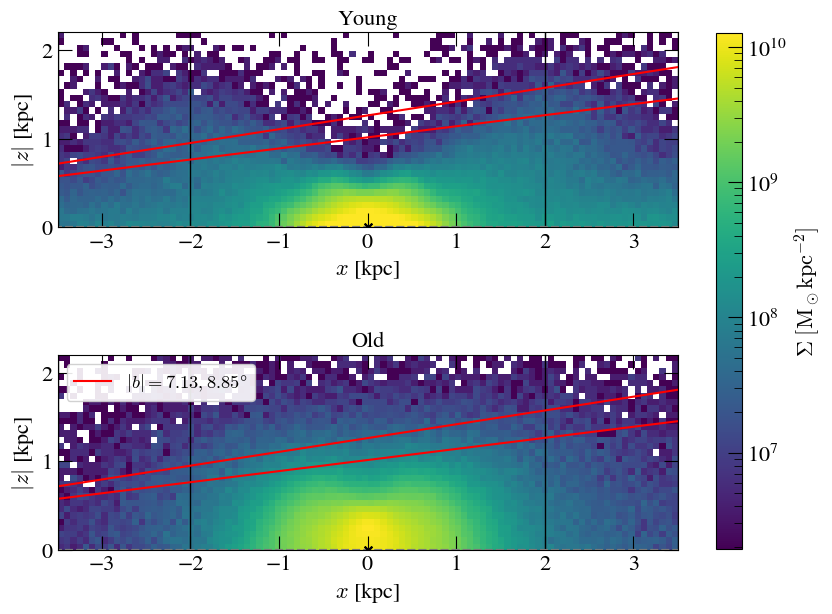

In [948]:
save_bool = True
# save_bool = False

plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = "small"

if True: # show young and old

    # projection = "xy"
    projection = "xz"

    xymax = 3.5

    zmax = 2.2
    zmin = 0 if zabs else -zmax

    bins_x=100

    if True:

        aspect_ratio = 2*(zmax-zmin)/(1.5*xymax)

        fig,axs=plt.subplots(figsize=(10,aspect_ratio*10),nrows=2,gridspec_kw={"hspace":0})

        c1 = MP.quick_show_xz(MF.apply_cuts_to_df(df0,{"l":[-2,2],"age":young_lims}),bins_x=bins_x,zmin=zmin,zmax=zmax,xmax=xymax)
        c1 = MP.quick_show_xz(MF.apply_cuts_to_df(df0,{"l":[-2,2],"age":old_lims}),bins_x=bins_x,zmin=zmin,zmax=zmax,xmax=xymax)

        norm = PH.get_norm_from_count_list([c1,c2],log=True)

        _ = MP.quick_show_xz(MF.apply_cuts_to_df(df0,{"l":[-2,2],"age":young_lims}),bins_x=bins_x,zmin=zmin,zmax=zmax,xmax=xymax,ax=axs[0],show=True,norm=norm)
        _ = MP.quick_show_xz(MF.apply_cuts_to_df(df0,{"l":[-2,2],"age":old_lims}),bins_x=bins_x,zmin=zmin,zmax=zmax,xmax=xymax,ax=axs[1],show=True,norm=norm)

        plt.colorbar(cm.ScalarMappable(norm=norm,cmap="viridis"),ax=axs,shrink=0.8,label=mass_density_label)

        filename,_ = MP.visualise_bulge_selection(given_axs=axs[::-1],projection=projection,cuts={"l":[2],"b":[bmin,bmax],"R":[2,3.5]},R0=R0)
        _,_ = MP.visualise_bulge_selection(given_axs=axs,projection=projection,cuts={"l":[2],"b":[bmin,bmax],"R":[2,3.5]},R0=R0)

        axs[1].legend(loc="upper left",framealpha=0.9)

        for i,ax in enumerate(axs):
            ax.set_xlim(-xymax,xymax)
            ax.set_ylim(zmin,zmax) if projection == "xz" else ax.set_ylim(-xymax,xymax)
            ax.set_aspect("equal")
            ax.set_title([label_young,label_old][i])

        if True: # filename and saving

            filename = ("o_" if data_bool else "") + filename

            filename += f"_{projection}" if projection != "both" else ""

            print(filename)

            if save_bool:
                if os.path.isdir("graphs/other_plots/visualise_bulge_cuts/"):
                    save_path = "graphs/other_plots/visualise_bulge_cuts/"
                else:
                    raise ValueError("Save path not specified")

                print("Saving in:",save_path)

                for fileformat in [".pdf",".png"]:
                    plt.savefig(save_path+filename+fileformat, dpi=200,bbox_inches="tight")
                    print(fileformat)

        plt.show()

In [1228]:
if data_bool: # choose metallicity cuts
    metal_poor_lowlim = None
    metal_poor_highlim = -0.2

    metal_rich_lowlim = -0.2
    metal_rich_highlim = None

In [1229]:
if data_bool:
    
    if metal_poor_lowlim is None:
        poor_condition = poor_condition = (o_df_extra["FeH"] < metal_poor_highlim)
        label_poor = fr'[Fe/H]$<{metal_poor_highlim}$'
    else:
        poor_condition = (o_df_extra["FeH"] < metal_poor_highlim)&(o_df_extra["FeH"] > metal_poor_lowlim)
        label_poor = fr'${metal_poor_lowlim}<$[Fe/H]$<{metal_poor_highlim}$'

    if metal_rich_highlim is None:
        rich_condition = o_df_extra["FeH"] > metal_rich_lowlim
        label_rich = fr'[Fe/H]$>{metal_rich_lowlim}$'
    else:
        rich_condition = (o_df_extra["FeH"] < metal_rich_highlim)&(o_df_extra["FeH"] > metal_rich_lowlim)
        label_rich = fr'${metal_rich_lowlim}<$[Fe/H]$<{metal_rich_highlim}$'

    df_metals = [o_df_extra[rich_condition], o_df_extra[poor_condition]]
    
    save_path_metal = f"{metal_rich_lowlim}to{metal_rich_highlim}_{metal_poor_lowlim}to{metal_poor_highlim}/"

    if halo_bool:
        df_metals.append(o_df_extra[o_df_extra["FeH"] < metal_halo_lim])    
        label_halo = fr'(%i) [Fe/H]$<{metal_halo_lim}$'%len(df_metals[2])
        print("Working with the halo population")

    print(label_rich,len(df_metals[0]),"\t",label_poor,len(df_metals[1]))

## Path

In [949]:
#create path
save_path = "graphs/standard_100_min/"+sim_choice+'/'

if sim_choice == "708main" and axisymmetric:
    save_path += 'axisymmetric/'
    MF.create_dir(save_path)
    
save_path += f"{x_variable}{y_variable}_map/"
MF.create_dir(save_path)

save_path += f"{MF.check_int(x_min)}{x_variable}{MF.check_int(x_max)}_{MF.check_int(y_min)}{y_variable}{MF.check_int(y_max)}/"
MF.create_dir(save_path)

save_path += f"bins_{x_bin_number}{x_variable}_{y_bin_number}{y_variable}/"
MF.create_dir(save_path)

save_path += f"{MF.return_int_or_dec(extra_variable_min,2)}{extra_variable}{MF.return_int_or_dec(extra_variable_max,2)}/"
MF.create_dir(save_path)

main_not_axisymmetric_bool = sim_choice == "708main" and not axisymmetric
if main_not_axisymmetric_bool:
    save_path += 'rot_angle_'+str(rot_angle)+'/'
    MF.create_dir(save_path)

    if x_variable == "d":
        save_path += y_variable+"_step_"+str(y_step)+'/'
        MF.create_dir(save_path)

if young_and_old:
    save_path += "young_and_old/"
    MF.create_dir(save_path)
    
    if age_min == 5 and young_max == 9 and old_min == 9.8 and old_max == 10:
        save_path += "Oscar_cuts/"
    elif age_min == 0 and young_max == 7 and old_min == 9 and old_max == 10:
        save_path += "Steven_cuts/"
    else:
        save_path += f"{age_min}-{young_max}_{old_min}-{old_max}/" #Oscar_cuts/
    MF.create_dir(save_path)
else:
    save_path += "age_min_"+str(age_min_real)+'/'
    MF.create_dir(save_path)
    
save_path_gridcounts = save_path

vel_string = f"v{vel_x_variable}v{vel_y_variable}/" if vel_y_variable != '\phi' else f"vRvphi/"
save_path += vel_string
MF.create_dir(save_path)
        
if data_bool:
    save_path += "data/"
    MF.create_dir(save_path)
    
    save_path += save_path_metal
    MF.create_dir(save_path)
    
# paper_str = "paper/"
# save_path += paper_str
# MF.create_dir(save_path)
    
# save_path += 'vR_positive/'
# MF.create_dir(save_path)
        
print("Saving in",save_path)

Saving in graphs/standard_100_min/708main/xy_map/-3.5x3.5_-3.5y3.5/bins_13x_13y/7.13b8.85/rot_angle_27/young_and_old/4-7_9.5-10/vrvl/


Min star number: 57
Max star number: 21393


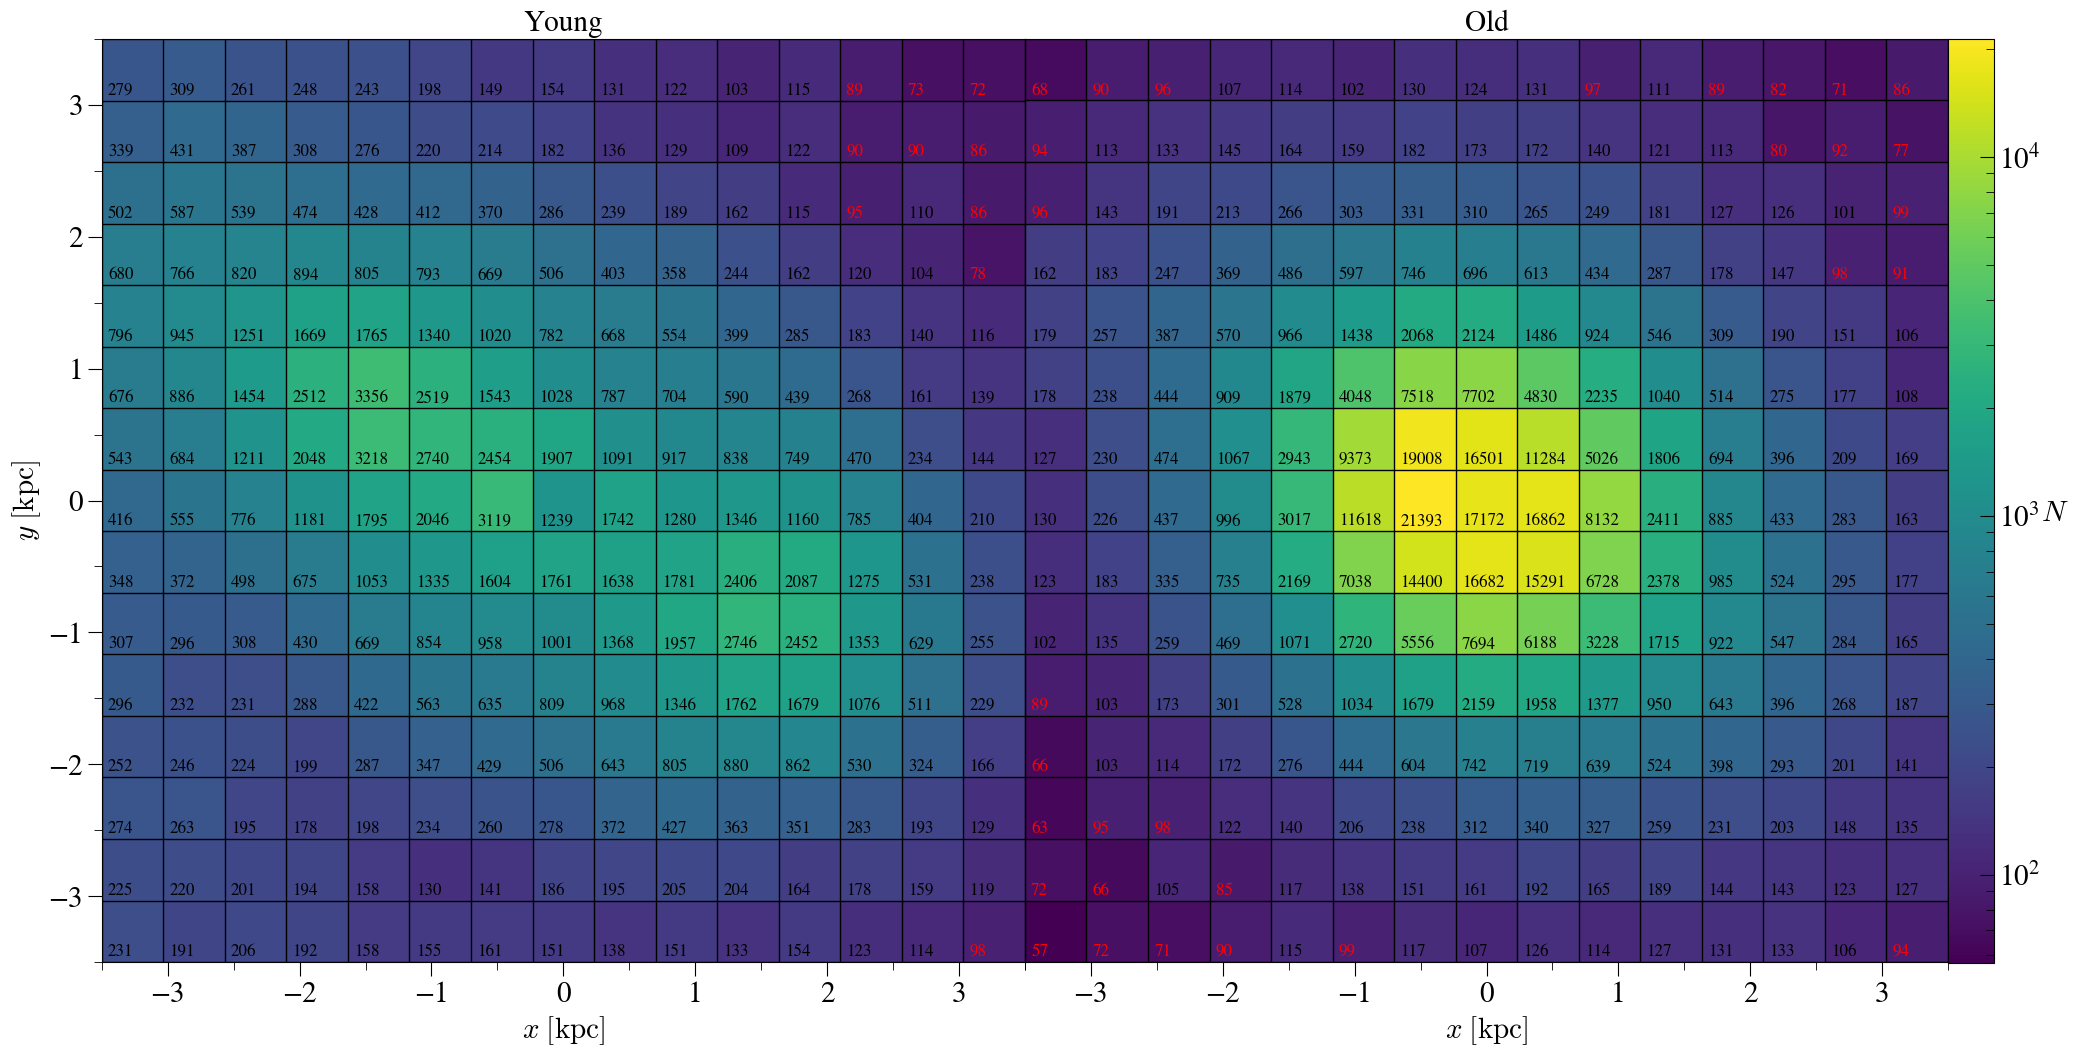

In [769]:
# save_bool = True
save_bool = False

plt.rcParams["font.size"]=21

cmap = mplcmaps["viridis"]
# cmap = PH.get_reds_cmap()

below_minN_color = "red"

x_shift_divisor = 10
y_shift_divisor = 10

if True: # grid & counts
    
    aspect_ratio = 2.035*(x_max-x_min)/(y_max-y_min)
    
    fig,axs = plt.subplots(figsize=(aspect_ratio*12,12),ncols=3,gridspec_kw={"wspace":0, "width_ratios":[1,1,0.05]})
    
    x_bins = len(x_range)
    y_bins = len(y_range)
    
    vmin,vmax = 9999,-9999
    for pop in df_ages:
        vals,_,_ = np.histogram2d(pop[x_variable],pop[y_variable],bins=[x_bins,y_bins])
        vmin,vmax = min(vmin,np.nanmin(vals)),max(vmax,np.nanmax(vals))
    
    norm = LogNorm(vmin=vmin,vmax=vmax)
    
    print("Min star number:",int(vmin))
    print("Max star number:",int(vmax))

    for ax,pop in zip(axs,df_ages):
        count,x_edge,y_edge,_ = ax.hist2d(pop[x_variable],pop[y_variable],bins=[x_bins,y_bins],norm=norm,cmap=cmap)

        for i in range(len(x_edge)-1):
            for j in range(len(y_edge)-1):
                c = count[i,j]
                x = x_edge[i]
                y = y_edge[j]
                
                color = below_minN_color if c < min_star_number else "k"
                ax.text(x=x+(x_max-x_min)/x_bins/x_shift_divisor,y=y+(y_max-y_min)/y_bins/y_shift_divisor,s=str(int(c)),color=color,size="xx-small")

        for x in x_edge: ax.axvline(x,color="k",lw=1)
        for y in y_edge: ax.axhline(y,color="k",lw=1)

        ax.set_aspect("equal")
        configure_ax()
        ax.tick_params(axis="both",which="both",direction="out",top=False)
        ax.set_title(label_young if ax == axs[0] else label_old)
    
    axs[1].tick_params(which="both",left=False)
    axs[1].set(ylabel="",yticklabels=[])

    cbar = plt.colorbar(mappable=cm.ScalarMappable(norm=norm,cmap=cmap),cax=axs[2])
    cbar.set_label(r"$N$",rotation=0,labelpad=10)

    if save_bool:
        filename = f"gridcounts_min{min_star_number}N"
        plt.savefig(save_path_gridcounts+filename+".png",dpi=200,bbox_inches="tight")
        print("Saved:",save_path_gridcounts+filename+".png")

    plt.show()

In [586]:
anything_to_state = True

max_decimals = 3

if anything_to_state:
    
    min_n_data = f" and {o_min_star_number} for the data" if data_bool else ''
    xy_steps_data = f" For the data the x and y steps are instead {o_x_step} and {o_y_step}\n" if data_bool else ''
    
    vel_string = f"v{vel_x_variable}v{vel_y_variable}" if vel_y_variable != '\phi' else f"vRvphi"
    settings = \
    f"Working with velocities {vel_string}\n\n"+\
    "Working with "+x_variable+f" from {x_min} to {x_max}"+" in steps of "+str(MF.return_int_or_dec(x_step,max_decimals))+f", i.e. {x_bin_number} bins"+"\n"+\
    "Working with "+y_variable+f" from {y_min} to {y_max}"+" in steps of "+str(MF.return_int_or_dec(y_step,max_decimals))+f", i.e. {y_bin_number} bins"+"\n"+\
    xy_steps_data +\
    "The variable "+extra_variable+" goes from "+str(extra_variable_min)+" to "+str(extra_variable_max)+extra_variable_units+"\n\n"+\
    f"Minimum star number set to {min_star_number} for the simulation{min_n_data}\n\n"+\
    "Bootstrap repeat set to "+str(bootstrap_repeat)+"\n\n"

    additional_info = f"ADDITIONAL INFO\nWorking with age range: [[{age_min},{young_max}],[{old_min},{old_max}]]\n"
    if data_bool:
        additional_info += f"Metal poor: ({metal_poor_lowlim},{metal_poor_highlim}), Metal rich: ({metal_rich_lowlim},{metal_rich_highlim})\n"
    additional_info += f"Variable zabs set to {zabs}\nScaling set to {pos_scaling}"

    if sim_choice == "708main":
        settings += "Bar angle "+str(rot_angle)+"\n\n"
    
    overwrite = False
    if os.path.isfile(save_path+"README.txt"):
        overwrite_str = input("There may be files already in this folder, including a README.txt file, do you want to overwrite it? Y/N\n")
        if overwrite_str.upper() == "Y":
            overwrite = True
    else:
        overwrite = True
            
    if overwrite:
        with open(save_path + "README.txt", "w") as f:
            f.write(settings+additional_info)
        print(settings+additional_info)

There may be files already in this folder, including a README.txt file, do you want to overwrite it? Y/N
n


## Get arrays

In [647]:
# plotting ellipses average column(s)
plotting_ellipses_overall = False
plotting_ellipses_left = False
plotting_ellipses_right = False

In [648]:
# Velocity graphs
plotting_velocity_graphs = False
plotting_velocity_graphs_y = False
plotting_velocity_graphs_xleft = False
plotting_velocity_graphs_xright = False
velocity_graph_ages = [9] #needs to be a list

### Sim

In [649]:
all_maps = False

full_map_string_list = [map_string for map_string in full_map_string_list if "spherical" not in map_string]

In [650]:
start = time.time()

map_dict = {}
for map_string in full_map_string_list:
    map_dict[map_string] = np.zeros(shape=(len(age_range),len(y_range),len(x_range)))

if plotting_ellipses_overall:
    x_overall_arrays = np.zeros(shape=(len(full_map_string_list_no_spherical),len(age_range),len(y_range)))
if plotting_ellipses_left:
    x_leftcolumn_arrays = np.zeros(shape=(len(full_map_string_list_no_spherical),len(age_range),len(y_range)))
if plotting_ellipses_right:
    x_rightcolumn_arrays = np.zeros(shape=(len(full_map_string_list_no_spherical),len(age_range),len(y_range)))

for age_index, age in enumerate(age_range):
    
    if True: # age cuts
        if age == age_min:
            age_lim_left = age_min if young_and_old else 0
            age_lim_right = young_max if young_and_old else age+age_step
        else:
            age_lim_left = old_min if young_and_old else age
            age_lim_right = old_max if young_and_old else age+age_step
            
        df_age = df_extra[(df_extra.age >= age_lim_left)&(df_extra.age <= age_lim_right)]
            
        age_x = df_age[x_variable].values
        age_y = df_age[y_variable].values
        
        if vel_variables == 'R\phi':
            age_vx,age_vy = df_age.vR.values,df_age.vphi.values
        elif len(vel_variables) > 2:
            raise ValueError(f"Velocity selection not defined for velocity variables {vel_variables}.")
        else:
            age_vx,age_vy = df_age[f"v{vel_variables[0]}"].values, df_age[f"v{vel_variables[1]}"].values
            
        if "spherical_tilt" in full_map_string_list:
            if x_variable+y_variable == 'Rphi':
                age_vx_s,age_vy_s = df_age.vR.values,df_age.vphi.values
            elif x_variable+y_variable == "dl":
                age_vx_s,age_vy_s = df_age.vr.values,age_df.vl.values
            elif len(x_variable+y_variable) > 2:
                raise ValueError(f"Spherical misalignment velocities not defined for spatial coords {x_variable+y_variable}.")
            else:
                age_vx_s,age_vy_s = df_age[f"v{x_variable}"].values, df_age[f"v{y_variable}"].values
        else:
            age_vx_s,age_vy_s = None,None

    if plotting_velocity_graphs and age in velocity_graph_ages: # strings for velocity plot
        
        age_string = f"{str(MF.return_int_or_dec(age_lim_left,2))}age{str(MF.return_int_or_dec(age_lim_right,2))}"
        save_path_age = save_path + age_string + '/'

        save_path_vel = save_path_age + 'velocities/'
        
        MF.create_dir(save_path_age)
        MF.create_dir(save_path_vel)

        velocity_limits = [np.min([age_vx,age_vy]), np.max([age_vx,age_vy])]
        vel_min = -1.1*np.max(np.abs(velocity_limits))
        vel_max = 1.1*np.max(np.abs(velocity_limits))

        vel_index = 0
    
    for y_index, y in enumerate(y_range):
        print(y)
        
        if y_index == len(y_range)-1:
            vx_yslice = age_vx[(age_y >= np.min([y,y+y_step]))&(age_y <= np.max([y,y+y_step]))]
            vy_yslice = age_vy[(age_y >= np.min([y,y+y_step]))&(age_y <= np.max([y,y+y_step]))]
            x_yslice = age_x[(age_y >= np.min([y,y+y_step]))&(age_y <= np.max([y,y+y_step]))]
        else:
            vx_yslice = age_vx[(age_y >= np.min([y,y+y_step]))&(age_y < np.max([y,y+y_step]))]
            vy_yslice = age_vy[(age_y >= np.min([y,y+y_step]))&(age_y < np.max([y,y+y_step]))]
            x_yslice = age_x[(age_y >= np.min([y,y+y_step]))&(age_y < np.max([y,y+y_step]))]
        
        if "spherical_tilt" in full_map_string_list:
            vx_s_yslice = age_vx_s[(age_y > np.min([y,y+y_step]))&(age_y < np.max([y,y+y_step]))]
            vy_s_yslice = age_vy_s[(age_y > np.min([y,y+y_step]))&(age_y < np.max([y,y+y_step]))]
        else:
            vx_s_yslice,vy_s_yslice = None,None
        
        if True: # ellipses average columns
            #Overall---------------------------------------------------------------------------------------------------
            if plotting_ellipses_overall:
                
                values_y = val_err.get_all_variable_values_and_errors(df_y,full_map_string_list_no_spherical,spatial_coords=x_variable+y_variable,velocity_variables=vel_variables,R_hat=None,
                                                                      bin_surface=x_step*y_step,repeat=bootstrap_repeat,min_number = min_star_number)                
                if len(values_y) != len(full_map_string_list_no_spherical):
                    raise ShapeError("The length of values_y does not match the string list!")

                for index, val in enumerate(values_y):
                    x_overall_arrays[index, age_index, y_index] = val
                    
                    
                #ON BOTH SIDES OF THE X-AXIS-----------------------------------------------------------------------------
                central_xpoint_dict = {
                    'xy': 0,
                    "xz": 0,
                    'dl': 8,
                    'lb': 0
                }

            #LEFT SIDE------------------------------------------------------------------------------------------------
            if plotting_ellipses_left:
                halfrow_larger = df_y[df_y[x_variable] > central_xpoint_dict[x_variable+y_variable]]
                halfrow_smaller = df_y[df_y[x_variable] < central_xpoint_dict[x_variable+y_variable]]

                df_xleft = halfrow_larger if x_variable == 'l' else halfrow_smaller

                number_xleft = len(df_xleft)

                if number_xleft >= min_star_number:

                    values_xleft = get_all_variable_values_and_errors(df_xleft,vel_variables,R_hat=None,repeat=bootstrap_repeat)                
                    if len(values_xleft) != len(full_map_string_list_no_spherical):
                        raise ShapeError("The length of the values_xleft list does not match the string list!")

                    for index, val in enumerate(values_xleft):
                        x_leftcolumn_arrays[index, age_index, y_index] = val
                else:
                    x_leftcolumn_arrays[:, age_index, y_index] = np.nan

            #RIGHT SIDE----------------------------------------------------------------------------------------
            if plotting_ellipses_right:
                df_xright = halfrow_smaller if x_variable == 'l' else halfrow_larger

                number_xright = len(df_xright)

                if number_xright >= min_star_number:

                    values_xright = get_all_variable_values_and_errors(df_xright,vel_variables,R_hat=None,repeat=bootstrap_repeat)                
                    if len(values_xright) != len(full_map_string_list_no_spherical):
                        raise ShapeError("The length of the values_xright list does not match the string list!")

                    for index, val in enumerate(values_xright):
                        x_rightcolumn_arrays[index, age_index, y_index] = val
                else:
                    x_rightcolumn_arrays[:, age_index, y_index] = np.nan
        
        #ALL_x-DIVISIONS------------------------------------------------------------------------------------
        for x_index, x in enumerate(x_range):
            if x_index == len(x_range)-1:
                vx_xslice = vx_yslice[(x_yslice >= np.min([x,x+x_step]))&(x_yslice <= np.max([x,x+x_step]))]
                vy_xslice = vy_yslice[(x_yslice >= np.min([x,x+x_step]))&(x_yslice <= np.max([x,x+x_step]))]
            else:
                vx_xslice = vx_yslice[(x_yslice >= np.min([x,x+x_step]))&(x_yslice < np.max([x,x+x_step]))]
                vy_xslice = vy_yslice[(x_yslice >= np.min([x,x+x_step]))&(x_yslice < np.max([x,x+x_step]))]
#             print(f"[{x}, {y}]")
            
            if "spherical_tilt" in full_map_string_list:
                vx_s_xslice = vx_s_yslice[(x_yslice >= np.min([x,x+x_step]))&(x_yslice < np.max([x,x+x_step]))]
                vy_s_xslice = vy_s_yslice[(x_yslice >= np.min([x,x+x_step]))&(x_yslice < np.max([x,x+x_step]))]
                R_hat = [x+x_step/2, y+y_step/2]
            else:
                vx_s_xslice,vy_s_xslice,R_hat = None,None,None
            
            bin_surface = x_step*y_step if all_maps else None

            value_dict = val_err.get_all_variable_values_and_errors(vx_xslice,vy_xslice, full_map_string_list, repeat=bootstrap_repeat, min_number=min_star_number, 
                                                                    all_maps=all_maps, R_hat=R_hat,vx_s=vx_s_xslice,vy_s=vy_s_xslice, bin_surface=bin_surface)
            if len(value_dict) != len(full_map_string_list):
                raise ValueError("The length of the value_dict list does not match the string list!")

            if plotting_velocity_graphs and (velocity_graph_ages == "all" or age == velocity_graph_ages):
                save_contour_velocity_plot(save_path_vel, vx_values, vy_values, \
                                           vel_names = vel_variables, \
                                           vel_limits = [vel_min,vel_max], \
                                           labels = [fr'${x_variable}$', fr'${y_variable}$'], \
                                           names = [x_variable,y_variable], \
                                           xlimits = [np.min([x,x+x_step]),np.max([x,x+x_step])], \
                                           ylimits = [np.min([y,y+y_step]),np.max([y,y+y_step])], \
                                           index=vel_index, theta=theta, error=error, \
                                           star_number=number_x, age_string=age_string)
                print("Saved velocities for",age_string)
                vel_index += 1
            
            for map_string in full_map_string_list:
                map_dict[map_string][age_index,y_index,x_index] = value_dict[map_string]

del df_age,vx_xslice,vx_yslice,vy_xslice,vy_yslice,x_yslice,vx_s_xslice,vx_s_yslice,vy_s_xslice,vy_s_yslice,age_x,age_y,age_vx,age_vy,value_dict,age_vx_s,age_vy_s

-3.5
Found `54` stars, less than the min of `100`
Found `58` stars, less than the min of `100`
Found `50` stars, less than the min of `100`
Found `43` stars, less than the min of `100`
Found `43` stars, less than the min of `100`
Found `37` stars, less than the min of `100`
Found `42` stars, less than the min of `100`
Found `57` stars, less than the min of `100`
Found `30` stars, less than the min of `100`
Found `32` stars, less than the min of `100`
Found `30` stars, less than the min of `100`
Found `31` stars, less than the min of `100`
Found `18` stars, less than the min of `100`
-2.9615384615384617
Found `62` stars, less than the min of `100`
Found `63` stars, less than the min of `100`
Found `47` stars, less than the min of `100`
Found `37` stars, less than the min of `100`
Found `39` stars, less than the min of `100`
Found `75` stars, less than the min of `100`
Found `63` stars, less than the min of `100`
Found `71` stars, less than the min of `100`
Found `61` stars, less than th

In [651]:
print(list(map_dict.keys()))
print(map_dict["number"].shape)
print(np.min(map_dict["number"]),np.max(map_dict["number"]))

['number', 'mean_vx', 'mean_vy', 'mean_vx_error', 'mean_vy_error', 'std_vx', 'std_vy', 'std_vx_error', 'std_vy_error', 'anisotropy', 'anisotropy_error', 'correlation', 'correlation_error', 'tilt_abs', 'tilt_abs_error']
(2, 13, 13)
12.0 1662.0


In [652]:
if plotting_ellipses_overall:
    xoverall_map_dict = create_map_array_dict(full_map_string_list_no_spherical, x_overall_arrays)
if plotting_ellipses_left:
    xleft_map_dict = create_map_array_dict(full_map_string_list_no_spherical, x_leftcolumn_arrays)
if plotting_ellipses_right:
    xright_map_dict = create_map_array_dict(full_map_string_list_no_spherical, x_rightcolumn_arrays)

In [653]:
# Save arrays

save_path_arrays = save_path + 'arrays/'

overwrite = False
if os.path.isdir(save_path_arrays):
    overwrite_str = input("There may be files already in this folder, do you want to overwrite them? Y/N\n")
    if overwrite_str.upper() == "Y":
        overwrite = True
else:
    MF.create_dir(save_path_arrays)
    overwrite = True

if overwrite:
    
    for key in map_dict:
        formatting = "%i" if np.all(map_dict[key] == map_dict[key].astype(int)) else "%.3f"
        
        with open(save_path_arrays+f'{key}.txt','w') as f:
            f.write(key+'\n\n')
            f.write("YOUNG\n"); np.savetxt(f,map_dict[key][0],fmt=formatting)
            f.write("\n\n")
            f.write("OLD\n"); np.savetxt(f,map_dict[key][1],fmt=formatting)
            
        np.save(save_path_arrays+key, map_dict[key])
        
    print("Saved .txt and .npy files successfully")

There may be files already in this folder, do you want to overwrite them? Y/N
n


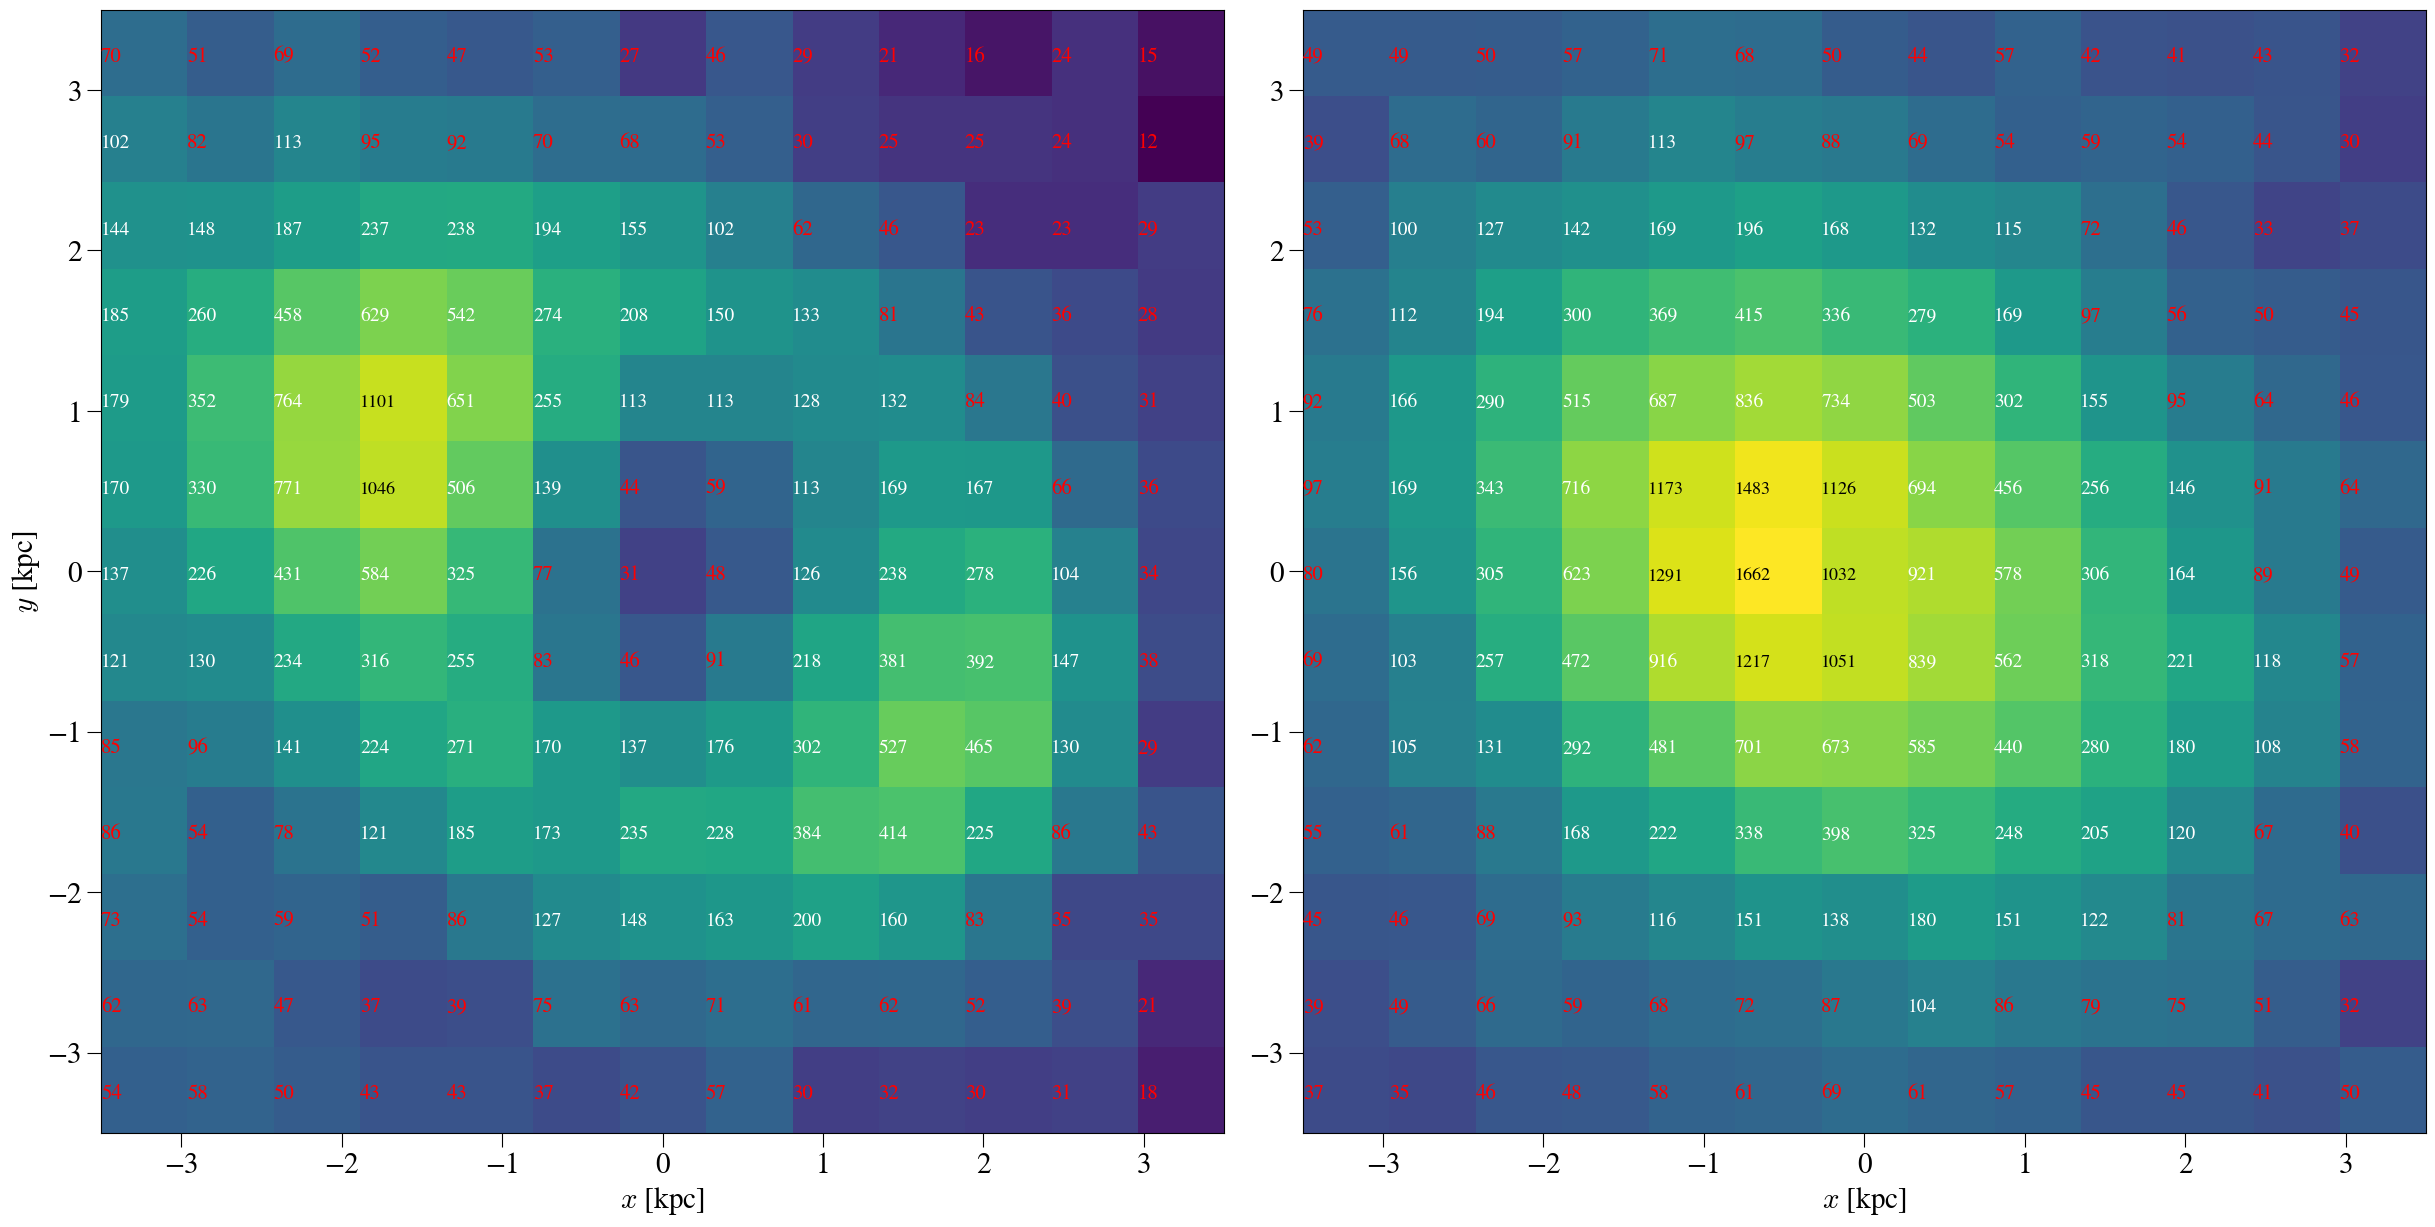

In [655]:
# save_bool = True
save_bool = False

if x_variable+y_variable != "lb": # currently looks bad for lb
    plot_values_heatmap("number", map_dict["number"], save_bool=save_bool,save_path=save_path_gridcounts)

### Data

In [40]:
plotting_ellipses_overall = False
plotting_ellipses_left = False
plotting_ellipses_right = False

In [41]:
#Decide whether to plot velocity graphs and for what ages (as a list)
plotting_velocity_graphs = False
plotting_velocity_graphs_y = False
plotting_velocity_graphs_xleft = False
plotting_velocity_graphs_xright = False
velocity_graph_ages = [9] #age_range

In [42]:
full_map_string_list_no_spherical = full_map_string_list[:-4]

In [43]:
start = time.time()

o_all_arrays = np.zeros(shape=(len(full_map_string_list),len(df_metals),len(o_y_range),len(o_x_range)))
if plotting_ellipses_overall:
    x_overall_arrays = np.zeros(shape=(len(full_map_string_list_no_spherical),len(df_metals),len(o_y_range)))
if plotting_ellipses_left:
    x_leftcolumn_arrays = np.zeros(shape=(len(full_map_string_list_no_spherical),len(df_metals),len(o_y_range)))
if plotting_ellipses_right:
    x_rightcolumn_arrays = np.zeros(shape=(len(full_map_string_list_no_spherical),len(df_metals),len(o_y_range)))

for metal_index, df_metal in enumerate(df_metals):
    
    for y_index, y in enumerate(o_y_range):
        df_y = df_metal[(df_metal[y_variable] > np.min([y,y+o_y_step]))&(df_metal[y_variable] < np.max([y,y+o_y_step]))]
                
        if True: #ellipses
            #Overall---------------------------------------------------------------------------------------------------
            if plotting_ellipses_overall:
                number_y = len(df_y)
                if number_y >= o_min_star_number:

                    values_y = get_all_variable_values_and_errors(df_y,vel_variables,R_hat=None,repeat=bootstrap_repeat)                
                    if len(values_y) != len(full_map_string_list_no_spherical):
                        raise ShapeError("The length of values_y does not match the string list!")

                    for index, val in enumerate(values_y):
                        x_overall_arrays[index, age_index, y_index] = val
                else:
                    x_overall_arrays[:, age_index, y_index] = np.nan

                #ON BOTH SIDES OF THE X-AXIS-----------------------------------------------------------------------------
                central_xpoint_dict = {
                    'xy': 0,
                    'dl': 8,
                    'lb': 0
                }

            #LEFT SIDE------------------------------------------------------------------------------------------------
            if plotting_ellipses_left:
                halfrow_larger = df_y[df_y[x_variable] > central_xpoint_dict[x_variable+y_variable]]
                halfrow_smaller = df_y[df_y[x_variable] < central_xpoint_dict[x_variable+y_variable]]

                df_xleft = halfrow_larger if x_variable == 'l' else halfrow_smaller

                number_xleft = len(df_xleft)

                if number_xleft >= min_star_number:

                    values_xleft = get_all_variable_values_and_errors(df_xleft,vel_variables,R_hat=None,repeat=bootstrap_repeat)                
                    if len(values_xleft) != len(full_map_string_list_no_spherical):
                        raise ShapeError("The length of the values_xleft list does not match the string list!")

                    for index, val in enumerate(values_xleft):
                        x_leftcolumn_arrays[index, age_index, y_index] = val
                else:
                    x_leftcolumn_arrays[:, age_index, y_index] = np.nan

            #RIGHT SIDE----------------------------------------------------------------------------------------
            if plotting_ellipses_right:
                df_xright = halfrow_smaller if x_variable == 'l' else halfrow_larger

                number_xright = len(df_xright)

                if number_xright >= min_star_number:

                    values_xright = get_all_variable_values_and_errors(df_xright,vel_variables,R_hat=None,repeat=bootstrap_repeat)                
                    if len(values_xright) != len(full_map_string_list_no_spherical):
                        raise ShapeError("The length of the values_xright list does not match the string list!")

                    for index, val in enumerate(values_xright):
                        x_rightcolumn_arrays[index, age_index, y_index] = val
                else:
                    x_rightcolumn_arrays[:, age_index, y_index] = np.nan
        
        #ALL_x-DIVISIONS------------------------------------------------------------------------------------
        for x_index, x in enumerate(o_x_range):
            df_x = df_y[(df_y[x_variable] >= np.min([x,x+o_x_step]))&(df_y[x_variable] < np.max([x,x+o_x_step]))]

            R_hat = [x+x_step/2, y+y_step/2]

            values_x = val_err.get_all_variable_values_and_errors(df_x, full_map_string_list, spatial_coords=x_variable+y_variable,velocity_variables=vel_variables, R_hat=R_hat, 
                                                                  bin_surface=o_x_step*o_y_step,repeat=bootstrap_repeat, min_number = o_min_star_number)                
            if len(values_x) != len(full_map_string_list):
                raise ValueError("The length of the values_x list does not match the string list!")

            for index, val in enumerate(values_x):
                o_all_arrays[index, metal_index, y_index, x_index] = val
    
del df_metal, df_y, df_x
if plotting_ellipses_overall:
    del df_overall
if plotting_ellipses_left:
    del df_xleft
if plotting_ellipses_right:
    del df_xright

stop = time.time()
print("Time taken was",(stop-start)/60,"minutes.")

-2.0 -2.0
-1.5 -2.0
-1.0 -2.0
-0.5 -2.0
0.0 -2.0
0.5 -2.0
1.0 -2.0
1.5 -2.0
-2.0 -1.5
-1.5 -1.5
-1.0 -1.5
-0.5 -1.5
0.0 -1.5
0.5 -1.5
1.0 -1.5
1.5 -1.5
-2.0 -1.0
-1.5 -1.0
-1.0 -1.0
-0.5 -1.0
0.0 -1.0
0.5 -1.0
1.0 -1.0
1.5 -1.0
-2.0 -0.5
-1.5 -0.5
-1.0 -0.5
-0.5 -0.5
0.0 -0.5
0.5 -0.5
1.0 -0.5
1.5 -0.5
-2.0 0.0
-1.5 0.0
-1.0 0.0
-0.5 0.0
0.0 0.0
0.5 0.0
1.0 0.0
1.5 0.0
-2.0 0.5
-1.5 0.5
-1.0 0.5
-0.5 0.5
0.0 0.5
0.5 0.5
1.0 0.5
1.5 0.5
-2.0 1.0
-1.5 1.0
-1.0 1.0
-0.5 1.0
0.0 1.0
0.5 1.0
1.0 1.0
1.5 1.0
-2.0 1.5
-1.5 1.5
-1.0 1.5
-0.5 1.5
0.0 1.5
0.5 1.5
1.0 1.5
1.5 1.5
-2.0 -2.0
-1.5 -2.0
-1.0 -2.0
-0.5 -2.0
0.0 -2.0
0.5 -2.0
1.0 -2.0
1.5 -2.0
-2.0 -1.5
-1.5 -1.5
-1.0 -1.5
-0.5 -1.5
0.0 -1.5
0.5 -1.5
1.0 -1.5
1.5 -1.5
-2.0 -1.0
-1.5 -1.0
-1.0 -1.0
-0.5 -1.0
0.0 -1.0
0.5 -1.0
1.0 -1.0
1.5 -1.0
-2.0 -0.5
-1.5 -0.5
-1.0 -0.5
-0.5 -0.5
0.0 -0.5
0.5 -0.5
1.0 -0.5
1.5 -0.5
-2.0 0.0
-1.5 0.0
-1.0 0.0
-0.5 0.0
0.0 0.0
0.5 0.0
1.0 0.0
1.5 0.0
-2.0 0.5
-1.5 0.5
-1.0 0.5
-0.5 0.5
0.0 0.5
0.5 0.5


In [44]:
o_map_dict = create_map_array_dict(full_map_string_list, o_all_arrays)
if plotting_ellipses_overall:
    o_xoverall_map_dict = create_map_array_dict(full_map_string_list_no_spherical, o_x_overall_arrays)
if plotting_ellipses_left:
    o_xleft_map_dict = create_map_array_dict(full_map_string_list_no_spherical, o_x_leftcolumn_arrays)
if plotting_ellipses_right:
    o_xright_map_dict = create_map_array_dict(full_map_string_list_no_spherical, o_x_rightcolumn_arrays)

In [ ]:
o_save_path_arrays = save_path + 'o_arrays/'
if not os.path.isdir(o_save_path_arrays):
    os.mkdir(o_save_path_arrays)
    
    for key in map_dict:
        with open(o_save_path_arrays+f'{key}.txt','w') as f:
            f.write(key+'\n\n')
            f.write("RICH\n"); np.savetxt(f,o_map_dict[key][0],fmt='%.3f')
            f.write("\n\n")
            f.write("POOR\n"); np.savetxt(f,o_map_dict[key][1],fmt='%.3f')

# Dynamical binning

In [25]:
filling_unbound_bool = True
# filling_unbound_bool = False

In [26]:
save_path = general_path+"708main_simulation/graphs/Observations/Apogee/dynamical_binning/"

save_path += save_path_map_dict[x_variable+y_variable]
MF.create_dir(save_path)

save_path += save_path_extra_variable_dict[extra_variable]
MF.create_dir(save_path)

save_path += f"v{vel_x_variable}v{vel_y_variable}/" if vel_y_variable != '\phi' else f"vRvphi/"
MF.create_dir(save_path)

save_path += "all_metallicities/" if min_metal_cut is None else f"min_{min_metal_cut}_FeH/"
MF.create_dir(save_path)

save_path += f"FeH_division_{metal_poor_highlim}/"
MF.create_dir(save_path)

if not filling_unbound_bool:
    save_path += "not_filling_unbound/"
    MF.create_dir(save_path)

print(save_path)

C:/Users/LuisFernandez/Documents/MRes_UCLan/708main_simulation/graphs/Observations/Apogee/dynamical_binning/lb_map/6d10/vrvl/min_-1_FeH/FeH_division_-0.2/


In [27]:
df_young,df_old = df_metals[0],df_metals[1]

In [352]:
def compute_mean(df, **kws):
    return np.mean(df[kws["vel"]].values)

def compute_std(df, **kws):
    return np.std(df[kws["vel"]].values)

def compute_correlation(df, **kws):
    return CV.calculate_correlation(df[kws["vx"]].values,df[kws["vy"]].values)

def compute_anisotropy(df, **kws):
    return CV.calculate_anisotropy(df[kws["vx"]].values,df[kws["vy"]].values)

def compute_tilt_abs(df, **kws):
    return CV.calculate_tilt(df[kws["vx"]].values,df[kws["vy"]].values,absolute=True)

def compute_error(df, **kws):
    return CV.get_std_bootstrap(df[kws["vx"]].values,df[kws["vy"]].values, function=kws["function"], tilt=kws["tilt"], absolute=kws["absolute"], repeat=kws["repeat"])

In [353]:
def get_compute_variable_error_function(map_variable):
    if map_variable == "correlation":
        return CV.calculate_correlation
    elif map_variable == "anisotropy":
        return CV.calculate_anisotropy
    elif map_variable == "tilt_abs":
        return CV.calculate_tilt
    else:
        raise ValueError(f"map variable {map_variable} not recognised")

def get_compute_variable_function(map_variable):
    if map_variable in ["mean_vx","mean_vy"]:
        return compute_mean
    elif map_variable in ["std_vx","std_vy"]:
        return compute_std
    elif map_variable == "correlation":
        return compute_correlation
    elif map_variable == "anisotropy":
        return compute_anisotropy
    elif map_variable == "tilt_abs":
        return compute_tilt_abs
    elif "error" in map_variable:
        return compute_error
    else:
        raise ValueError(f"map variable {map_variable} not recognised")

def is_tilt(map_variable):
    return "tilt" in map_variable or "vertex" in map_variable
        
def get_kws_for_error(map_variable, bootstrap_repeat=500):
    kinematic_variable = map_variable.replace("_error","")
    error_kws = {
                    "function": get_compute_variable_error_function(kinematic_variable),
                     "tilt": is_tilt(kinematic_variable),
                     "absolute": is_tilt(kinematic_variable) and "_abs" in kinematic_variable,
                     "repeat": bootstrap_repeat
                }
    return error_kws
        
def get_kws_symmetric_cmap_and_compute_variable_function(map_variable, bootstrap_repeat=500):
    
    if map_variable in ["mean_vx","std_vx"]:
        kws={"vel":f"v{vel_x_variable}"}
    elif map_variable in ["mean_vy","std_vy"]:
        kws={"vel":f"v{vel_y_variable}" if vel_y_variable !="\phi" else "vphi"}
    else:
        kws={"vx":f"v{vel_x_variable}","vy":f"v{vel_y_variable}" if vel_y_variable !="\phi" else "vphi"}

    symmetric = True if map_variable in divergent_map_list else False
    
    cmap = cm.coolwarm if symmetric else cm.Reds

    compute_variable = get_compute_variable_function(map_variable)
    
    if "error" in map_variable:
        error_kws = get_kws_for_error(map_variable, bootstrap_repeat)
        kws = {**kws, **error_kws} # combine dictionaries
        
    return kws, symmetric, cmap, compute_variable

In [150]:
def shiftedColorMap(cmap, vmin, vmax, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.
    '''
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    midpoint = (1 - vmax) / (vmax + abs(vmin))
    
    # regular index to compute the colors
    reg_index = np.linspace(0, 1, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mplcolors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

## Multiple variables

In [139]:
# CHOOSE

map_variable_list = [

["anisotropy","correlation","tilt_abs"],
# ["anisotropy","correlation","tilt_abs","tilt"],
# ["anisotropy","correlation","tilt_abs","spherical_tilt"],
# ["mean_vx","mean_vy","std_vx","std_vy"],
# ["anisotropy_error","correlation_error","tilt_abs_error"],
# ["anisotropy_error","correlation_error","tilt_abs_error","tilt_error"],
# ["anisotropy_error","correlation_error","tilt_abs_error","spherical_tilt_error"],
    
]

n_map_variables = len(map_variable_list[0])
for variable in map_variable_list: print(variable)

['anisotropy', 'correlation', 'tilt_abs']


In [140]:
plt.rcParams["font.size"]=15

In [141]:
fig_size = 10
cbar_width = 0.035

def get_fig_aspect_ratio(n_rows):
    if n_rows == 3:
        return 1.35
    elif n_rows == 4:
        return 1
    else:
        raise NotImplementedError(f"Not implemented for {n_rows} rows")

In [142]:
# scatter_bool = True
scatter_bool = False

In [143]:
# aspect_equal_bool = True
aspect_equal_bool = False

In [144]:
# save_bool = True
save_bool = False

In [147]:
debugging_bool = True
# debugging_bool = False

if debugging_bool:
    bootstrap_repeat = 1
    min_number_stars_list = [100]
    save_bool = False
else:
    bootstrap_repeat = 500
    min_number_stars_list = [30,50,100]

In [ ]:
for min_number_stars in min_number_stars_list:
    for map_variables in map_variable_list:
        n_rows = len(map_variables)

        grid = gridspec.GridSpec(n_rows,3,width_ratios=[1, 1, cbar_width], hspace=0,wspace=0)

        fig = plt.figure(figsize=(get_fig_aspect_ratio(n_rows)*fig_size,fig_size))
        axes = np.array([fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols)]).reshape((n_rows,n_cols))

        populations = [df_young, df_old]

        for row, variable in enumerate(map_variables):
            kws, symmetric, cmap, compute_variable = get_kws_symmetric_cmap_and_compute_variable_function(variable, bootstrap_repeat=bootstrap_repeat)

            max_value = float('-inf')
            min_value = float('inf')

            for col, population in enumerate(populations):
                _, computed_values = dyn.apply_and_plot_dynamical_binning_map(
                    population, 'l', 'b', min_number_stars,
                    axes[row, col],
                    symmetric_lims=symmetric,
                    cmap=cmap,
                    compute_variable_function=compute_variable,
                    **kws
                )

                max_value = max(max_value, computed_values.max())
                min_value = min(min_value, computed_values.min())

#             if symmetric:
#                 max_abs_value = max(abs(max_value), abs(min_value))
#                 norm = mplcolors.Normalize(vmin=-max_abs_value, vmax=max_abs_value)
#             else:
            norm = mplcolors.Normalize(vmin=min_value, vmax=max_value)

            sm = plt.cm.ScalarMappable(norm=norm, cmap=shiftedColorMap(cmap, min_value, max_value, name='shiftedcmap'))
            sm.set_array([])

            cbar = plt.colorbar(sm, cax=axes[row, 2])
            cbar.set_label(label=kinematic_symbol_dict[variable]+kinematic_units_dict[variable])


        x_label = fr"{variable_symbol_dict[x_variable]} $[{variable_units_dict[x_variable]}]$"
        y_label = fr"{variable_symbol_dict[y_variable]} $[{variable_units_dict[y_variable]}]$"

        if scatter_bool:
            young_x = df_young["l"].values
            young_y = df_young["b"].values
            old_x = df_old["l"].values
            old_y = df_old["b"].values

        for ax in axes.flatten():
            if ax in axes[:,2]:
                continue

            if scatter_bool:
                if ax in axes[:,0]:
                    ax.scatter(young_x, young_y, s=0.1,color="grey")
                if ax in axes[:,1]:
                    ax.scatter(old_x, old_y,s=0.1,color="grey")

            ax.set_xlim(x_left,x_right); ax.set_ylim(y_min,y_max)
            ax.set_xticks(x_ticks); ax.set_yticks(y_ticks)

            ax.set_xticklabels(x_ticks if ax in axes[-1] else []); ax.set_yticklabels(y_ticks if ax in axes[:,0] else [])
            ax.set_xlabel(x_label if ax in axes[-1] else ""); ax.set_ylabel(y_label if ax in axes[:,0] else "")

            if aspect_equal_bool:
                ax.set_aspect("equal")

        axes[0,0].set_title(label_rich)
        axes[0,1].set_title(label_poor)

        # ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_minor_locator))
        # ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_minor_locator))

        if save_bool:
            extra_var_string = f"{extra_variable_min}{extra_variable}{extra_variable_max}"

            filename = x_variable+y_variable+f"_dynmap_"+extra_var_string+'_'+map_variables[-2]+'_'+map_variables[-1]+'_'+str(min_number_stars)

            if any("error" in map_var for map_var in map_variables):
                filename += f"_boot{bootstrap_repeat}"
            
            if scatter_bool:
                filename += "_scatter"

            plt.savefig(save_path+filename+".png", bbox_inches='tight',dpi=300)
            plt.savefig(save_path+filename+".pdf", bbox_inches='tight')
            print(save_path+filename)
        plt.show()

## Single variable

In [200]:
plt.rcParams["font.size"]=15

In [203]:
save_bool = True
# save_bool = False

In [208]:
# for map_variable in ["mean_vy","mean_vx","std_vx", "std_vy", "anisotropy","correlation","tilt_abs"]:
for map_variable in ["mean_vy"]:
    kws, symmetric, cmap, compute_variable = get_kws_symmetric_cmap_and_compute_variable_function(map_variable)
    
    for min_N in [30,50,100]:
    
        fig,(ax,ax1)=plt.subplots(figsize=(20,10),ncols=2,sharey=True,gridspec_kw={"wspace":0.1})

        # replace_plot_scipy=True
        replace_plot_scipy=False

        computed_values_young = dyn.dynamical_binning_plot(df_young, x_variable,y_variable, min_number_stars=min_N, ax=ax, symmetric_lims = symmetric, vorbinplot=False, replace_plot_scipy=replace_plot_scipy, \
                                                     cmap=cmap, value_text=False, remove_unbound_regions=not filling_unbound_bool, compute_variable_function=compute_variable,**kws)

        computed_values_old = dyn.dynamical_binning_plot(df_old, x_variable,y_variable, min_number_stars=min_N, ax=ax1, symmetric_lims = symmetric, vorbinplot=False, replace_plot_scipy=replace_plot_scipy, \
                                                     cmap=cmap, value_text=False, remove_unbound_regions=not filling_unbound_bool, compute_variable_function=compute_variable,**kws)


        ax.scatter(df_young[x_variable],df_young[y_variable],s=0.2,color="grey")
        ax1.scatter(df_old[x_variable],df_old[y_variable],s=0.2,color="grey")

        ax.set_title(label_rich,pad=10)
        ax1.set_title(label_poor,pad=10)

        for axes in [ax,ax1]:
            axes.set_xlim(x_left,x_right); axes.set_ylim(y_min,y_max)
            axes.set_aspect('equal')
            axes.set_xlabel(fr"{variable_symbol_dict[x_variable]} $[{variable_units_dict[x_variable]}]$")
            if axes == ax:
                axes.set_ylabel(fr"{variable_symbol_dict[y_variable]} $[{variable_units_dict[y_variable]}]$")

        computed_values = np.concatenate([computed_values_young,computed_values_old])
        if symmetric:
            symmetric_lim = np.max(np.abs([computed_values.min(),computed_values.max()]))
            norm = plt.Normalize(-symmetric_lim, symmetric_lim)
        else:
            norm = plt.Normalize(computed_values.min(), computed_values.max())

        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=np.array([ax,ax1]).ravel().tolist(), label=kinematic_symbol_dict[map_variable],shrink=0.5 if x_variable+y_variable=="lb" else 0.8,pad=0.03)
        
        vel_string = f"v{vel_x_variable}v{vel_y_variable}" if vel_y_variable != '\phi' else f"vRvphi"
        filename = f"{x_variable}{y_variable}_{vel_string}_{map_variable}_min{min_N}"

        if save_bool:
            plt.savefig(save_path+filename+".png",dpi=300,bbox_inches="tight")
            print(filename)
            
plt.close("all")

lb_vrvl_mean_vy_min30
lb_vrvl_mean_vy_min50
lb_vrvl_mean_vy_min100


# Maps

## Settings

In [540]:
def get_extra_variable_string(variable, units, vmin, vmax):
    if variable in ['b','z']:
        variable = f'|{variable}|'
    
    
    vmin_type = "%i" if isinstance(vmin,int) else f"%.{MF.get_number_decimals(vmin)}f"
    vmax_type = "%i" if isinstance(vmax,int) else f"%.{MF.get_number_decimals(vmax)}f"
    
    if vmin == 0:
        if units in ['°','^\circ','deg']:
            units = "^\circ"
            return fr"$%s < {vmax_type}%s$"%(variable,vmax,units)
        else:
            return fr"$%s < {vmax_type}$"%(variable,vmax)+r"$\hspace{0.3}\mathrm{%s}$"%units
    else:
        if units in ['°','^\circ']:
            units = 'deg'
        return fr"${vmin_type} < %s/$"%(vmin,variable)+units+fr"$< {vmax_type}$"%(vmax)
def get_abc_xy(n_rows):
    '''
    returns tuple (abc_x, abc_y)
    '''
    if x_variable+y_variable == "lb":
        if n_rows == 3:
            return (0.025, 0.9)
        elif n_rows == 4:
            return (0.03,0.89)
    else:
        if n_rows == 3:
            return (0.04, 0.916)
        elif n_rows == 4:
            return (0.05,0.905)

def get_index_symmetric_level(levels):
    for i in range(len(levels) - 1):
        if levels[i] == -levels[i+1]:
            return i
    raise ValueError("There was no symmetric inner level:", levels)
def get_divergent_colors(levels, cbar_extend, cmap = plt.cm.coolwarm):
    '''
    Extracts colors from a divergent colormap, leaving an inner symmetric contour colored with the colormap's central value.
    The inner symmetric contour does not need to be in the centre of the contour levels.
    The number of contour levels can be even or odd.
    It also gives an extra color for either (or both) of the colorbar extends, which when plotted is assigned correctly.
    If the colorbar extends' color was not assigned correctly, it can be manually done as shown in the following example:
    
    x = np.arange(1, 10); y = x.reshape(-1, 1); h = x * y
    cs = plt.contourf(h, levels=[10, 30, 50], colors=["cyan","green"], cbar_extend='both')
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed() #IMPORTANT
    plt.colorbar()
    '''
    
    # Count number of filled contours to the left and right of the inner symmetric one (exclusive)
    n_contours_left = get_index_symmetric_level(levels)
    n_contours_right = len(levels) - 1 - (n_contours_left + 1)
    
    n_contours_left += 1 if cbar_extend in ["min","both"] else 0
    n_contours_right += 1 if cbar_extend in ["max","both"] else 0
    
    if n_contours_left > n_contours_right:
        left_colors = np.linspace(0, cmap.N//2, n_contours_left + 1)
        color_diff = np.diff(left_colors)[0]
        right_colors = [cmap.N//2+color_diff*i for i in range(1,n_contours_right+1)]
    else:
        right_colors = np.linspace(cmap.N//2, cmap.N, n_contours_right + 1)
        color_diff = np.diff(right_colors)[0]
        left_colors = sorted([cmap.N//2-color_diff*i for i in range(1,n_contours_left+1)])
        
    return [cmap(int(i)) for i in np.concatenate([left_colors,right_colors])]
def get_colors_and_cmap(levels, map_variable, cbar_extend,  diff = False):
    if any(x < 0 for x in levels) and any(x > 0 for x in levels):
        try:
            colors = get_divergent_colors(levels, cbar_extend, cmap = get_divergent_cmap(map_variable))
            cmap = None
        except ValueError: # there is no inner symmetric level
            colors = None
            cmap = get_divergent_cmap(map_variable)
    else:
        colors = None
        cmap = get_nondivergent_cmap(map_variable)
    return colors, cmap
def get_divergent_cmap(map_variable):
    return divergent_cmap if map_variable not in ['vertex','spherical_tilt','tilt'] else cyclic_cmap
def get_nondivergent_cmap(map_variable):
    if "error" in map_variable:
        return sequential_cmap
    elif vel_x_variable+vel_y_variable == 'R\phi' and map_variable == 'mean_vy':
        return coolwarm_negative_cmap
    elif map_variable in ["std_vx","std_vy"]:
        return sequential_cmap
    else:
        raise ValueError(f"no non-divergent cmap defined for {map_variable}")

def get_raw_levels_colors_cmap(vmin,vmax):
    """
    Use this function if you just want to see how raw levels (without any manual intervention aside from rounding) would look like.
    
    Pass into vmin and vmax the np.nanmin and np.nanmax of the maps
    """
    
    raw_levels = np.linspace(vmin,vmax,7)
    
    dec = 0
    levels = [MF.return_int_or_dec(lev,dec) for lev in raw_levels]
    while np.any(np.diff(levels) == 0):
        dec += 1
        levels = [MF.return_int_or_dec(lev,dec) for lev in raw_levels]

    colors = None
    if any(x < 0 for x in levels) and any(x > 0 for x in levels):
        cmap = "coolwarm"
    else:
        cmap = "Reds"
        
    return levels, colors, cmap

In [541]:
# Titles

comparison_type = "ages" # right now only affects the titles - 29/01/23

# numbers_in_title = True
numbers_in_title = False

if True:
    
    age_first = -2
    age_second = -1

    age_first_min = age_min if young_and_old else age_range[age_first]
    age_first_max = young_max if young_and_old else age_range[age_first]+age_step
    age_second_min = old_min if young_and_old else age_range[age_second]
    age_second_max = old_max if young_and_old else age_range[age_second]+age_step
    
    title_first_dict = {
        "models": "708main",
        "ages": fr'{MF.return_int_or_dec(age_first_min,2)}$<$Age/Gyr$<${MF.return_int_or_dec(age_first_max,2)}' if numbers_in_title else "Young"
    }
    title_second_dict = {
        "models": "Axisymmetric",
        "ages": fr'{MF.return_int_or_dec(age_second_min,2)}$<$Age/Gyr$<${MF.return_int_or_dec(age_second_max,2)}' if numbers_in_title else "Old"
    }

    if not young_and_old and age_range[age_first] == age_min:
        title_first_dict["ages"] = fr'0 < Age/Gyr < {MF.return_int_or_dec(age_range[age_first] + age_step,2)}'
        
    titles = [title_first_dict[comparison_type],title_second_dict[comparison_type]]

print(titles)

['Young', 'Old']


In [538]:
# line plotting

plotting_lines_bool = x_variable+y_variable=="xy"

plotting_line_labels = True
highlight_lines = False

if plotting_lines_bool:
    line_label_fontsize = "x-small" # see https://stackoverflow.com/questions/62288898
    
    sun_coords = [-R0,0]
    angle_range = [-15,-10,-5,0,5,10,15] if x_max > 2 else [-10,-5,0,5,10]
    radii_list = np.array([5.1,6.1,7.1,8.1,9.1,10.1,11.1]) if x_max > 2 else [6,7,8,9,10]
    
#     angle_label_vals = np.arange(min(angle_range),max(angle_range)+10,10)
    angle_label_vals = np.arange(min(angle_range),max(angle_range)+5,5)
    if 0 not in angle_label_vals:
        angle_label_vals = np.append(angle_label_vals,0)
    
    radii_label_vals = [6.1,8.1,10.1]
    
    contour_lw = 0.5
    dashes = [20, 10] # length of on / off parts
    
    if highlight_lines:
        angle_selection = [-15,15]
        radius_selection = [5,11]
    
    print("Plotting angles:",angle_range,"with label in",angle_label_vals)
    print("Plotting radii:",radii_list,"with label in",radii_label_vals)

Plotting angles: [-15, -10, -5, 0, 5, 10, 15] with label in [-15 -10  -5   0   5  10  15]
Plotting radii: [ 5.1  6.1  7.1  8.1  9.1 10.1 11.1] with label in [6.1, 8.1, 10.1]


In [1051]:
# extra_variable_text_bool = True
extra_variable_text_bool = False

In [1052]:
# sharing_cbar_bool = True
sharing_cbar_bool = False

if sharing_cbar_bool:
    
    shared_cbar_variables = []
        
    cyl_xy_bool = x_variable+y_variable == 'xy' and vel_x_variable+vel_y_variable == 'R\phi'
    galactic_xy_bool = x_variable+y_variable == 'xy' and vel_x_variable+vel_y_variable == 'rl'
    lb_lb_bool = x_variable+y_variable=='lb' and vel_x_variable+vel_y_variable=='lb'
    galactic_lb_bool = x_variable+y_variable == 'lb' and vel_x_variable+vel_y_variable == 'rl'
    
    if galactic_xy_bool or (galactic_lb_bool and 8 in [extra_variable_min, extra_variable_max]):
        shared_cbar_variables.append(['mean_vx','mean_vy'])
        
    shared_cbar_variables.append(["std_vx","std_vy"])
        
#     if cyl_xy_bool:
#         shared_cbar_variables.append(['anisotropy_error','correlation_error'])
        
    print("Sharing all of the following map pairs (when they exists):\n")
    for shared in shared_cbar_variables:
        print(shared)

In [1053]:
# colorbar & cmap

cbar_spacing = 'uniform'
# cbar_spacing = 'proportional'

cbar_extending_bool = True

divergent_cmap = cm.coolwarm
cyclic_cmap = cm.twilight_shifted
sequential_cmap = "Reds"
coolwarm_positive_cmap = PH.get_reds_cmap(divergent_cmap)
coolwarm_negative_cmap = PH.get_blues_cmap(divergent_cmap)

In [1272]:
# levels

if True: # ani & corr extra settings
    ani_limit_bool = True
    inner_ani_contour = 0.1
    ani_leveldiff_factor = 2

    corr_limit_bool = False
    inner_corr_contour = 0.05
    ani_leveldiff_factor = 2

    ani_delete_bool = False
    ani_skip = 1 # number of outer levels to skip

    corr_delete_bool = False
    corr_skip = 1

def get_manual_levels(map_variable, diff=False):
    if True: # diff and not diff
        if vel_x_variable+vel_y_variable == 'R\phi' and x_variable+y_variable=="xy":
            if map_variable == 'mean_vx':
                return [-40,-30,-20,-10,10,20,30,40]
            if map_variable in ['vertex_abs','tilt_abs']:
                return [-45,-40,-30,-20,-10,10,20,30,40,45]

    if not diff:

        if vel_x_variable+vel_y_variable=='rl':
            if x_variable+y_variable=='xy':
#                 if map_variable == "std_vx":
#                     return [30,45,60,75,90,105,120,136]
                if map_variable in ['std_vx','std_vy']:
#                     return [40,60,70,90,100,120,130,150]
#                     return [40,55,70,85,100,115,130]
#                     return [25,45,65,85,105,125,145]
                    return [35,45,55,65,75,85,95,105,115]
                if map_variable == "correlation":
#                     return [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2]
#                     return [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5]
                    return [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6]
                if map_variable == "anisotropy":
#                     return [-1,-0.8,-0.6,-0.4,-0.2,-0.1,0.1,0.2,0.4,0.6]
                    return [-2,-1,-0.8,-0.6,-0.4,-0.2,-0.1,0.1,0.2,0.4,0.6,0.7]
                if map_variable == "mean_vx":
#                     return [-120,-100,-80,-60,-40,-20,20,40,60,80,100,120]
#                     return [-160,-135,-105,-75,-45,-15,15,45,75,105,135,150]
#                     return [-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,170]
                    return [-160,-140,-110,-80,-50,-20,0,20,50,80,110,140]
                if map_variable == "mean_vy":
#                     return [-100,-80,-60,-40,-20,20,40,60,80,100]
#                     return [-135,-105,-75,-45,-15,15,45,75,105,130]
#                     return [-130,-100,-70,-40,-10,10,40,70,100,130]
#                     return [-160,-130,-100,-70,-30,0,30,70,100,130,160]
#                     return [-150,-120,-90,-60,-30,0,30,60,90,120,150]
                    return [-130,-110,-80,-50,-20,0,20,50,80,110,140]
                if map_variable == "anisotropy_error":
#                     return [0,0.05,0.10,0.15,0.2,0.25]
                    return [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
                if map_variable == "correlation_error":
#                     return [0,0.03,0.05,0.07,0.09,0.11,0.13]
                    return [0,0.04,0.08,0.12,0.16,0.2,0.24]
                if map_variable == "tilt_abs_error":
                    return [0,5,10,15,20,25,30]
            if x_variable+y_variable=="lb":
                if map_variable == "anisotropy":
#                     return [-2,-1,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2]
                    return [-2. , -1.7, -1.4, -1.2, -0.9, -0.7, -0.4, -0.1,  0.1,0.2]
                if map_variable == 'correlation':
#                     return [-0.4,-0.3,-0.2,-0.1,-0.05,0.05]
                    return [-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.05,0.05,0.1]
                if map_variable == "tilt_abs":
#                     return [-40,-30,-20,-10,10,20]
                    return [-45,-40,-35,-30,-25,-20,-15,-10,10]
                if map_variable == "mean_vy":
#                     return [-30,-20,-10,10,20,30,40,60]
#                     return [-45,-30,-20,-10,10,20,30,40,60,75]
                    return [-50,-30,-10,10,30,50,70]
                if map_variable == "vertex":
                    return [-90,-70,-50,-30,-20,-10,10,20]
                if map_variable == "mean_vx":
#                     return [-90,-70,-50,-30,-10,10,30,50,70,90]
                    return [-105,-80,-50,-30,-10,10,30,50,80,105]
                if map_variable in ["std_vx","std_vy"]:
                    return [45,60,75,90,105,120,135,150,165]
                if map_variable == "anisotropy_error":
                    return [0,0.05,0.1,0.15,0.2,0.25,0.5]
                if map_variable == "correlation_error":
                    return [0,0.02,0.04,0.06,0.08,0.1,0.12]
                if map_variable == "tilt_abs_error":
                    return [0,3,6,9,12,15,18]
                    return [0,2,4,6,8,10,12,14]
                if "fractionalerror" in map_variable:
                    return [0,0.15,0.33,0.5,0.75,1]
        if vel_x_variable+vel_y_variable=='R\phi':
            if x_variable+y_variable=='xy':
                if map_variable == "mean_vy":
                    return [-160,-150,-130,-110,-90,-70,-50,-30]
                if map_variable in ["std_vx","std_vy"]:
                    return [40,60,70,90,100,120,130,140]
                if map_variable == 'correlation':
#                         return [-0.25,-0.20,-0.15,-0.10,-0.05,0.05,0.10,0.15,0.20,0.25,0.3]
                    return [-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35]
#                         return [-0.3,-0.2,-0.1,-0.05,0.05,0.1,0.2,0.3]
                if map_variable == "anisotropy":
                    return [-0.4,-0.2,-0.1,0.1,0.2,0.4,0.6,0.8]
                if map_variable == "anisotropy_error":
                    return [0,0.04,0.08,0.12,0.16,0.20]
                if map_variable == "correlation_error":
                    return [0,0.03,0.06,0.09,0.12,0.14]
                if map_variable == "tilt_abs_error":
                    return [0,5,10,15,20,25,30]

        if map_variable in ['vertex_abs','tilt_abs']: return [-45,-40,-30,-20,-10,10,20,30,40,45]
        if map_variable in ["tilt","vertex","spherical_tilt"]: return [-80,-50,-30,-10,10,30,50,80]

    if diff:
        if vel_x_variable+vel_y_variable=='R\phi':
            if x_variable+y_variable=='xy':

                if map_variable == "anisotropy":
#                         return [-0.6,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4]
                    return [-0.55,-0.4,-0.25,-0.1,0.1,0.25,0.4]
                if map_variable == "correlation":
#                         return [-0.25,-0.20,-0.15,-0.10,-0.05,0.05,0.10,0.15,0.20,0.25]
                    return [-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25]
                if map_variable == "mean_vy":
                    return [-80,-70,-60,-50,-30,-20,-10,10]
                if map_variable == "std_vx":
                    return [-10,10,20,30,40,50]
                if map_variable == "std_vy":
                    return [-20,-10,10,20,30]
        if vel_x_variable+vel_y_variable=='rl':
            if x_variable+y_variable == 'xy':
                if map_variable == "mean_vx":
                    return [-60,-40,-20,-10,10,20,40,60]
                if map_variable == "mean_vy":
                    return [-50,-40,-30,-20,-10,10,20,30,40,50]
                if map_variable == "anisotropy":
                    return [-0.7,-0.6,-0.4,-0.2,-0.1,0.1,0.2,0.4]
                if map_variable == "correlation":
#                         return [-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2]
                    return [-0.60,-0.45,-0.30,-0.15,-0.05,0.05,0.15,0.30]
                if map_variable == "vertex_abs":
                    return [-60,-45,-30,-15,-5,5,15,30]
                if map_variable == "tilt_abs":
                    return [-60,-45,-30,-15,-5,5,15,30,45]
                if map_variable == "std_vx":
                    return [-20,-10,10,20,30,40,50]
                if map_variable == "std_vy":
                    return [-20,-10,10,20,30]
            if x_variable+y_variable=="lb":
                if map_variable == "tilt_abs":
                    return [-40,-30,-20,-10,-5,5,10]
                if map_variable == "vertex":
                    return [-30, -20, -10, 10, 20, 30,40]
                if map_variable == "anisotropy":
                    return [-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4]
                if map_variable == "correlation":
                    return [-0.35,-0.25,-0.15,-0.10,-0.05,0.05]
                if map_variable == "mean_vx":
                    return [-50,-40,-30,-20,-10,10,20,30,40,50]
                if map_variable == "mean_vy":
                    return [-30,-20,-10,10,20,30,40,50]
                if map_variable in ["std_vx","std_vy"]:
                    return [-20,-10,10,20,30]
                
    return None
    
def get_levels(map_variable,original_vmin,original_vmax,diff=False,n_levels=None, ani_delete_counter = 0, verbose=False):
    if map_variable not in full_map_string_list: raise ValueError(f"Map variable '{map_variable}' not in full_map_string_list")
    if np.isnan(original_vmin): raise ValueError("The min value is nan...")
    if np.isnan(original_vmax): raise ValueError("The max value is nan...")
        
    vmin,vmax = original_vmin,original_vmax
    
    symmetric = True
        
    manual_levels = get_manual_levels(map_variable, diff)
    if manual_levels is not None:
        return manual_levels
    
    if verbose:
        print("Levels not set manually")
    
    if True: # non-manual levels
        
        if map_variable in ['mean_vx','mean_vy']:

            if vel_x_variable+vel_y_variable == 'R\phi':
                if map_variable == 'mean_vy': # v\phi
                    symmetric = False

            # lb space vl near/far set symmetric = False
            elif x_variable+y_variable=='lb' and 8 in [extra_variable_min, extra_variable_max]:
                if vel_x_variable+vel_y_variable == 'rl' and map_variable == 'mean_vy': #vl
                    symmetric = False
                if vel_x_variable+vel_y_variable == 'lb' and map_variable == 'mean_vx': #vl
                    symmetric = False
        
        if n_levels is None:
            if "error" in map_variable or map_variable == 'n_density':
                n_levels = 6
            else:
                n_levels = 8

        if not diff and map_variable not in divergent_map_list:
            if map_variable in ["abs_spherical_tilt","std_vx","std_vy","number","n_density"] or "error" in map_variable:
                symmetric = False
            else:
                vmin = 0.00001

        if symmetric:
            vmax = np.max(np.abs([original_vmin,original_vmax]))
            vmin = -vmax

        round_decimals = -2
        levels = np.round(np.linspace(vmin,vmax,n_levels),round_decimals)
        # Relax the rounding if two contour levels are the same or, in the case of symmetric=True, the min and max contours are not opposites of one another 
        while np.any(np.diff(levels) == 0) or (symmetric and np.min(levels) != -np.max(levels)):
            round_decimals += 1
            levels = np.round(np.linspace(vmin,vmax,n_levels),round_decimals)
    
    if symmetric: # Force inner contour values or remove outer levels
        
        if ani_delete_counter == 1:
            return levels
        if not ani_limit_bool and ani_delete_bool:
            ani_delete_counter += 1
        
        if map_variable == "anisotropy" and ani_limit_bool:
            # ignore furthest limits to fix inner contour and maximum level difference
            if levels[int(n_levels/2)] > inner_ani_contour or np.any(np.diff(levels) > ani_leveldiff_factor*inner_ani_contour):
                levels = get_levels(map_variable, levels[1],levels[-2]) #Ignore furthest limits
        elif map_variable == "anisotropy" and ani_delete_bool:
            # delete ani_skip number of levels
            levels = get_levels(map_variable,levels[ani_skip],levels[-1-ani_skip], ani_delete_counter=ani_delete_counter)

        if map_variable == "correlation" and corr_limit_bool:
            if levels[int(n_levels/2)] > inner_corr_contour or np.any(np.diff(levels) > corr_leveldiff_factor*inner_corr_contour):
                levels = get_levels(map_variable, levels[1],levels[-2]) #Ignore furthest limits
        elif map_variable == "correlation" and corr_delete_bool:
            levels = get_levels(map_variable,levels[corr_skip],levels[-1-corr_skip], ani_delete_counter=ani_delete_counter)

    #     if x_variable+y_variable=='xy' and vel_x_variable+vel_y_variable=='rl':
    #         if not diff and map_variable in ['anisotropy_error',"correlation_error"]:
    #             if levels[1] > 0.04: #Try to get small inner contour but do not ignore the maximum too much
    #                 levels = get_levels(map_variable, original_vmin, levels[-2], diff=False) #Ignore furthest limits
        pass
    
    return levels

In [1055]:
# print min and max for difmap
if 'difmap_bool' in globals() and difmap_bool:
    map_idx = 0
    if True:
        print(difmap_variables[map_idx])
        
        print("vals")
        print("min",min_val_and_diff[map_idx][0])
        print("max",max_val_and_diff[map_idx][0])

        print("\ndiff")
        print("min",min_val_and_diff[map_idx][1])
        print("max",max_val_and_diff[map_idx][1])

In [1266]:
map_test = 'std_vy'
if True: # level test
    diff_test = False

    if not diff_test:
        if map_test == 'abs_spherical_tilt': vmin_test,vmax_test=0,90
        else: vmin_test,vmax_test = np.nanmin(map_dict[map_test]),np.nanmax(map_dict[map_test])
    else:

        arr_diff = map_dict[map_test][0] - map_dict[map_test][1]

        if map_string in ["vertex","tilt","spherical_tilt"]:
            arr_diff[arr_diff > 90] = 180 - arr_diff[arr_diff > 90]
            arr_diff[arr_diff < -90] = -(180 + arr_diff[arr_diff < -90])

        vmin_test = np.nanmin(arr_diff)
        vmax_test = np.nanmax(arr_diff)

        if map_test in ['vertex_abs_error','vertex_error','abs_spherical_tilt_error','tilt_error','tilt_abs_error']: vmin_test,vmax_test = 0,30
    
    print(map_test)
    print("vmin",vmin_test)
    print("vmax",vmax_test)

    levels_test = get_levels(map_test,vmin_test,vmax_test,diff_test,n_levels=6,verbose=True)
    print(levels_test)

std_vy
vmin 35.96140009513779
vmax 111.30627933398665
[30, 45, 60, 75, 90, 105, 120]


In [1057]:
np.round(np.linspace(round(vmin_test,-1),round(vmax_test,-1),9),1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1058]:
np.round(np.arange(vmin_test,vmax_test,0.25),1)

array([0.])

## Density

In [950]:
density_contour_color = 'yellow'
density_contour_lw = 1

density_contours_on = True
# density_contours_on = False

In [951]:
mass_density_bool = True
cbar_label = r"$\Sigma \hspace{0.3} [\rm M_\odot kpc^{-2}]$" if mass_density_bool else r"$\Sigma_n \hspace{0.3} [\rm kpc^{-2}]$"

stellar_mass = 9.5*10**3 # stellar masses - see bottom left of page 8 in Debattista 2017

In [952]:
log_bool = True

cmap = 'magma'
cbar_tick_colour = 'white'
tick_colour = 'white'
age_text_colour = 'white'

white_frame_bool = True # on last two subplots with range_str == "0to10_9.5_9.9"

In [958]:
#Get density contours

n_bins = 100
x_bins,y_bins = n_bins,n_bins

density_contours_sigma = 2

count_list = []
for index in range(len(age_lowlims)):
    age_low = age_lowlims[index]
    age_high = age_highlims[index]

    df = df_extra[(df_extra['age']>=age_low) & (df_extra['age'] <= age_high)]
    counts,_,_ = np.histogram2d(df[x_variable],df[y_variable],bins=[x_bins,y_bins],range=[[x_min,x_max],[y_min,y_max]],density=True)
    #Both histograms have the same range (and n_bins) so that ensures the same binning
    #Setting density=True in np.histogram2d gives probability density values (number/Ntotal/bin_area such that integral of number*bin_area is 1)
    #I multiply below by the total N values so that I get surface density (number per unit area)
    counts = counts.T*len(df) #Multiply by total number to get a surface density rather than probability density
    if mass_density_bool: counts *= stellar_mass
    count_list.append(gaussian_filter(counts, density_contours_sigma))

In [959]:
# parameters

plt.rcParams.update({'font.size' : 30 if y_variable=="y" else 27})

fig_aspect_ratio = 2.38*x_max/y_max #if y_var=="y" else 1.5*ncols/nrows
fig_size = 10

In [960]:
title_bool = young_and_old
# title_bool = False

# alphabet_bool = True # only takes effect if title_bool is False
alphabet_bool = False

# extra_string_bool = True
extra_string_bool = False

aspect_equal = True
# aspect_equal = False

In [961]:
save_density_bool = True
# save_density_bool = False

AgeWindows_4-7_9.5-10_-3.50y3.50_7.13b8.85_bins100_gauss2_minExtend
Saving in: graphs/standard_100_min/708main/xy_map/-3.5x3.5_-3.5y3.5/bins_13x_13y/7.13b8.85/rot_angle_27/young_and_old/4-7_9.5-10/vrvl/
Saved .png
Saved .pdf


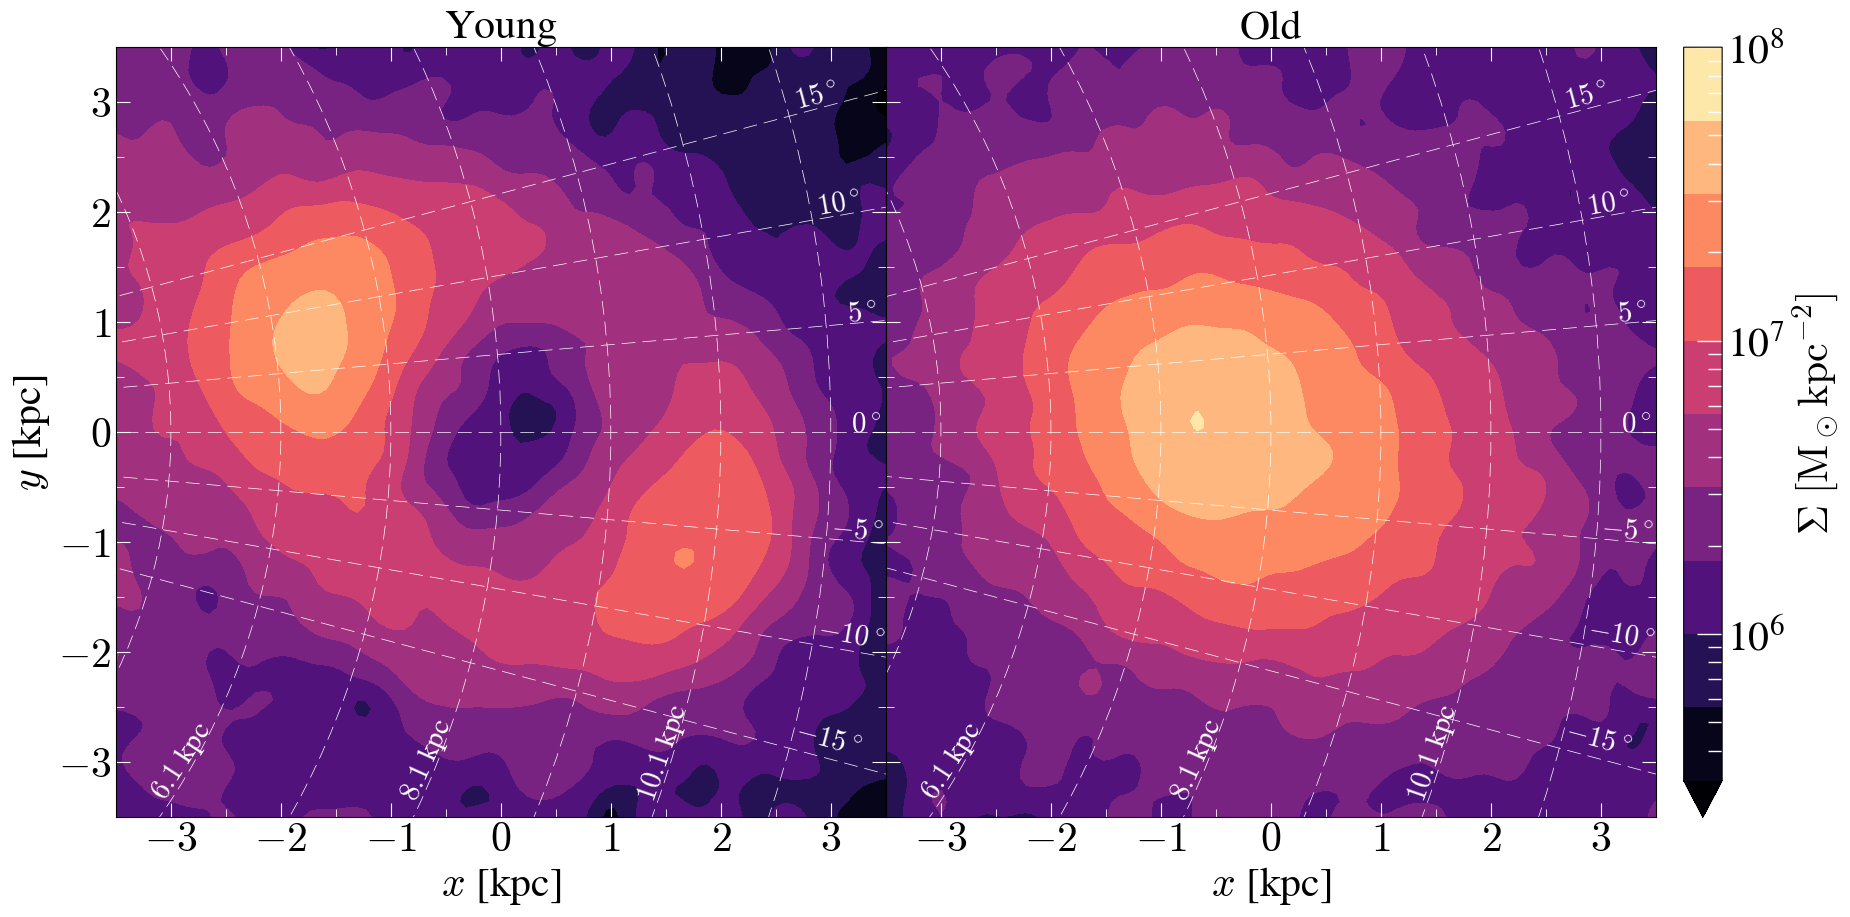

In [962]:
if True: # density

    extra_level_factor = 5
    # delete_lowest_level = 0
    delete_lowest_level = None

    if True: #fig, contours
        figsize = (fig_aspect_ratio*fig_size,fig_size)

        fig, axs = plt.subplots(figsize=figsize,ncols=2,sharey=True,sharex=True,gridspec_kw={'hspace':0,'wspace':0})
        vmax = np.nanmax(count_list)
    #     vmax = 10**9

    #         vmin = 10**6 if stellar_mass else 10**3
    #         vmin = 10**5
        vmin = np.nanmin(count_list)

        if vmin == 0: vmin = 0.1

    #     density_filled_levels = None
        density_filled_levels = np.array([10**i for i in np.arange(int(np.log10(vmin)),int(np.log10(vmax))+0.25*extra_level_factor,0.25)])
        density_filled_levels = density_filled_levels[density_filled_levels > np.nanmin(count_list)]
        if delete_lowest_level is not None: density_filled_levels = np.delete(density_filled_levels, delete_lowest_level)

        if True: # cbar extends
            top_extend = np.nanmax(count_list) > max(density_filled_levels)
            bottom_extend = np.nanmin(count_list) < min(density_filled_levels)

            cbar_extend = "neither"
            if top_extend and bottom_extend:
                cbar_extend = 'both'
            if top_extend and not bottom_extend:
                cbar_extend = "max"
            if not top_extend and bottom_extend:
                cbar_extend = "min"

        axs = axs.ravel()

    for index in range(len(age_lowlims)):
        age_low, age_high = age_lowlims[index], age_highlims[index]

    #     norm = LogNorm(vmin=vmin,vmax=vmax) if log_bool else None
        c = axs[index].contourf(count_list[index],extent=extent,levels=density_filled_levels,extend=cbar_extend,cmap=cmap,norm=LogNorm())#,vmin=vmin,vmax=vmax)

        if True: # lims, ticks
            if aspect_equal:
                axs[index].set_aspect('equal')
            axs[index].set_xticks(x_ticks);axs[index].set_yticks(y_ticks)
            axs[index].set_xticklabels([r"$%s$"%str(MF.check_int(tick)) for tick in x_ticks])
            axs[index].set_yticklabels([r"$%s$"%str(MF.check_int(tick)) for tick in y_ticks])
            axs[index].yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
            axs[index].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
            axs[index].tick_params(axis='both', which='both', color="w")

            axs[index].set_xlim(x_left,x_right);axs[index].set_ylim(y_min,y_max)

            if axs[index].get_subplotspec().is_first_col(): axs[index].set_ylabel(r"$%s$ [kpc]"%y_variable)
            if axs[index].get_subplotspec().is_last_row(): axs[index].set_xlabel(r"$x$ [kpc]")

        if plotting_lines_bool:
            highlight_factor = 3

            for ang in angle_range:
                if highlight_lines and ang in angle_selection:

                    x_select = np.array(radius_selection)*np.cos(np.radians(ang))-abs(sun_coords[0])
                    y_select = np.array(radius_selection)*np.sin(np.radians(ang))

                    # outbound pieces
                    axs[index].plot([sun_coords[0],x_select[0]],[sun_coords[1],y_select[0]], 'w--',linewidth=contour_lw,dashes=dashes)
                    axs[index].plot([x_select[1],x_max],[y_select[1],(x_max+abs(sun_coords[0])) * np.tan(np.radians(ang))], 'w--',linewidth=contour_lw,dashes=dashes)

                    # highlighted piece
                    axs[index].plot(x_select,y_select, 'w--',linewidth=highlight_factor*contour_lw,dashes=[d/highlight_factor for d in dashes])
                else:
                    axs[index].plot([sun_coords[0],x_max],[sun_coords[1],(x_max+abs(sun_coords[0])) * np.tan(np.radians(ang))], 'w--',linewidth=contour_lw,dashes=dashes)

                if plotting_line_labels and ang in angle_label_vals:
                    neg_shift = 0.15 if len(str(ang)) > min([len(str(a)) for a in angle_label_vals]) else 0

                    ang_label_x = (abs(sun_coords[0])+x_max-0.32)*np.cos(np.radians(ang))-abs(sun_coords[0])-neg_shift

                    axs[index].text(x=ang_label_x,y=(ang_label_x+abs(sun_coords[0]))*np.tan(np.radians(ang))*1.02,\
                                    s=fr"${ang}^\circ$",color="w",rotation=ang,size=line_label_fontsize)

            for radius in radii_list:

                if highlight_lines and radius in radius_selection:
                    x_outer,y_outer = PH.get_ellipse_coords(radius, phi_range=[angle_selection[1],angle_selection[0]])
                    axs[index].plot(x_outer+sun_coords[0],y_outer+sun_coords[1], 'w--',linewidth=contour_lw,dashes=dashes)

                    x_inner,y_inner = PH.get_ellipse_coords(radius, phi_range=[angle_selection[0],angle_selection[1]])
                    axs[index].plot(x_inner+sun_coords[0],y_inner+sun_coords[1], 'w--',linewidth=highlight_factor*contour_lw,dashes=[d/highlight_factor for d in dashes])
                else:
                    x_circ,y_circ = PH.get_ellipse_coords(radius)
                    axs[index].plot(x_circ+sun_coords[0],y_circ+sun_coords[1], 'w--',linewidth=contour_lw,dashes=dashes)

                if plotting_line_labels and radius in radii_label_vals:
                    low_y = 0.95*y_min

                    x_intersect = np.sqrt(radius**2 - low_y**2)
                    slope = -x_intersect / np.sqrt(radius**2 - x_intersect**2)
                    rot = -np.degrees(np.arctan(slope))

                    indices_white_background = [0] if y_variable == "z" and np.diff(age_lowlims)[0] == 1 else []
                    bbox = {'color':'white','boxstyle':'round','alpha':0.8} if index in indices_white_background else None
                    d_color = 'k' if index in indices_white_background else 'white'

                    axs[index].text(x=x_intersect-abs(sun_coords[0])-0.24,y=low_y,s=fr"${radius}$ kpc",color=d_color,rotation=rot,size=line_label_fontsize,bbox=bbox)

        if title_bool:
            axs[index].set_title(titles[index])
        else: # inline ages
            age_string = str(MF.return_int_or_dec(age_low))
            age_string += "-"
            age_string += str(MF.return_int_or_dec(age_high))
            age_string += " Gyr"
            full_age_str = f"({'abcdefghijkl'[index]}) {age_string}" if alphabet_bool else age_string

            string_length = len(full_age_str)
            x_text = 8/9*x_min
            y_text = (5/6 if y_variable == "y" else 4/5)*y_max

            indices_white_background = [0] if y_variable == "z" and np.diff(age_lowlims)[0] == 1 else []

            bbox = {'color':'white','boxstyle':'round','alpha':0.8} if index in indices_white_background else None
            age_text_colour = 'k' if index in indices_white_background else 'white'
            axs[index].text(x=x_text,y=y_text,s=full_age_str,color=age_text_colour,bbox=bbox)

    if True: #colorbar
    #         cbar_fraction = 0.018 if range_str == "_4-7_9.5-10" else 0.02

    #         cbar_spacing = 'proportional'
        cbar_spacing = 'uniform'

        cbar = plt.colorbar(c,ax=axs,pad=0.015,spacing=cbar_spacing)#,fraction=cbar_fraction)#,extendfrac='auto')

        if True: #cbar label, ticks
            
            cbar_ax = cbar.ax
            cbar_ax.set_ylabel(cbar_label)
            
            cbar_ax.minorticks_on()
            
            # Take those contour levels of form 10^x
            cbar_ticks = density_filled_levels[np.round(np.log10(density_filled_levels)) == np.log10(density_filled_levels)]
#             cbar_ticks = density_filled_levels

            cbar_ax.set_yticks(cbar_ticks)

            cbar_ax.tick_params(which='minor',size=10,width=1,color="w")
            cbar_ax.tick_params(which='major',size=18,width=1,color="w")         
    if extra_string_bool:
        decimals = ".1f" if np.max([len(str(extra_variable_max)),len(str(extra_variable_min))]) < 4 else ".2f"
        low_decimal = decimals; high_decimal = decimals
        if isinstance(extra_variable_min,int): low_decimal = 'i'
        if isinstance(extra_variable_max,int): high_decimal = 'i'

        extra_x_text = x_max*5.1/5
        extra_y_text = -y_max*5.85/5

        if extra_variable_min == -extra_variable_max or (extra_variable_min == 0 and zabs):
            extra_range_string = fr'$|%s|<%{high_decimal}$'%(extra_variable,extra_variable_max)+r"$\hspace{%s}\mathrm{%s}$"%('0.2' if extra_variable_units != '^\circ' else '0',extra_variable_units)
        else:
    #             if extra_variable_units == '^\circ': extra_variable_units = 'deg'
            extra_x_text -= 0.7

            extra_range_string = fr'$%{low_decimal}<|{extra_variable}|<%{high_decimal}$'%(extra_variable_min,extra_variable_max)+r"$\hspace{%s}\mathrm{%s}$"%('0.2' if extra_variable_units != '^\circ' else '0',extra_variable_units)

        axs[-1].text(x=extra_x_text,y=extra_y_text,s=extra_range_string,size="small",bbox=dict(boxstyle="square",fc='white',lw=0.03))
    if True: # filename
        
        if True: #y_string
            decimals = ".1f" if np.max([len(str(y_max)),len(str(y_min))]) < 4 else ".2f"
            low_decimal = decimals; high_decimal = decimals
            if isinstance(y_min,int): low_decimal = 'i'
            if isinstance(y_max,int): high_decimal = 'i'

            y_string = f'_%{low_decimal}{y_variable}%{high_decimal}'%(MF.check_int(y_min),MF.check_int(y_max))
        
        extra_string = f'_%{low_decimal}{extra_variable}%{high_decimal}'%(MF.check_int(extra_variable_min) if (extra_variable_min != -extra_variable_max or y_variable == 'z') else 0,MF.check_int(extra_variable_max))
        
        special_lines_string = '_specialbLines' if (y_variable == 'z' and special_b_lines_bool) else ''
        n_bins_string = f'_bins{n_bins}'
        gauss_sigma_string = f'_gauss{density_contours_sigma}'
        extend_string = f'_{cbar_extend}Extend' if cbar_extend != 'neither' else ''
        lines_string = "_noLoS" if not plotting_lines_bool else ""

        range_str = f"{MF.return_int_or_dec(age_lowlims[0])}-{MF.return_int_or_dec(age_highlims[0])}_{MF.return_int_or_dec(age_lowlims[1])}-{MF.return_int_or_dec(age_highlims[1])}"

        filename = "AgeWindows_" + range_str + y_string + extra_string + special_lines_string + n_bins_string + gauss_sigma_string + extend_string + lines_string
        print(filename)
    if save_density_bool:
        print("Saving in:",save_path)
        for save_format in ['.png','.pdf']:
            plt.savefig(save_path + filename + save_format,bbox_inches='tight',dpi=300)
            print('Saved '+save_format)
    plt.show()

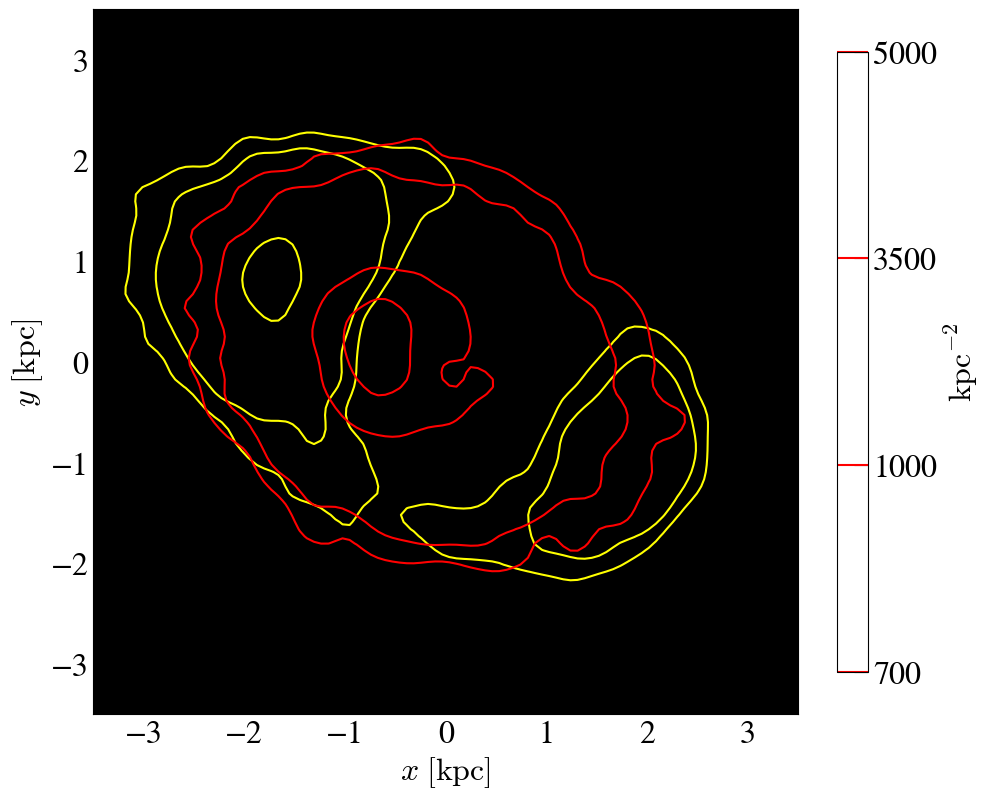

In [1110]:
if True: #PLAY WITH THESE TILL YOU'RE HAPPY
    lower, middle, higher = 40, 65, 82
    fourth = 95 #None
    rounding = -3
    
    manual_contour_bool = True
#     manual_contour_bool = False

    if manual_contour_bool:
        if x_variable+y_variable == "xy":
#             density_contour_levels = [ 3500, 8700, 14000, 82000 ]
            density_contour_levels = [ 700,1000,3500, 5000 ]
        if x_variable+y_variable == "yz":
            density_contour_levels = [ 3000, 10000, 30000, 300000 ]
        if x_variable+y_variable == "lb":
            density_contour_levels = [200,500, 1000, 5000, 40000 ]
    else:
        lower_contour = np.percentile(count_list,lower)
        middle_contour = np.percentile(count_list,middle)
        higher_contour = np.percentile(count_list,higher)
        density_contour_levels = np.round([lower_contour,middle_contour,higher_contour],rounding)
        if fourth is not None:
            fourth_contour = np.percentile(count_list,fourth)
            density_contour_levels = np.sort(np.append(density_contour_levels, np.round(fourth_contour,rounding)))

    if True: # plot
        fig,ax=plt.subplots(figsize=(10,10))
        ax.set_facecolor('black')
        c1 = ax.contour(count_list[0]/(stellar_mass if mass_density_bool else 1), extent=extent,colors='yellow',levels=density_contour_levels)
        c = ax.contour(count_list[1]/(stellar_mass if mass_density_bool else 1), extent=extent,colors='red',levels=density_contour_levels)
        ax.set_xlabel(x_label);ax.set_ylabel(y_label)
        if x_variable+y_variable=='lb':ax.invert_xaxis()
        fig.colorbar(c,label=r'$\mathrm{kpc}^{-2}$',fraction=0.04)
        ax.set_aspect('equal') if x_variable+y_variable != 'dl' else ax.set_aspect((x_max-x_min)/(y_max-y_min))
        
        plt.show()

In [1111]:
if density_contours_on: #save contour levels
    overwrite = False
    if os.path.isfile(save_path+"density_contour_levels.txt"):
        overwrite_str = input("There is already a density_contour_levels.txt file, do you want to overwrite it? Y/N\n")
        if overwrite_str.upper() == "Y" or overwrite_str.upper() == "YES":
            overwrite = True
    else:
        overwrite = True
            
    if overwrite:
        with open(save_path + f'density_contour_levels.txt','w') as f:
            if manual_contour_bool:
                percentile_string = 'I manually selected the contours.\n\n'
            else:
                percentile_list = sorted([lower,middle,higher,fourth]) if fourth is not None else [lower,middle,higher]
                percentile_string = f"Chose percentiles {percentile_list}, with rounding {rounding}\n\n"

            f.write(f"Contour levels are: {density_contour_levels} kpc^-2 \n\n"+percentile_string+\
                    f"The gaussian filtering has sigma = {density_contours_sigma}")
        print("Written successfully")

Written successfully


## Plot

### Difference maps

In [508]:
difmap_bool = True
doublemap_bool = False

In [283]:
# CHOOSE

difmap_variable_list = [

# ["anisotropy","correlation","tilt_abs"],
# ["anisotropy","correlation","tilt_abs","tilt"],
# ["anisotropy","correlation","tilt_abs","spherical_tilt"],
["mean_vx","mean_vy","std_vx","std_vy"],
# ["anisotropy_error","correlation_error","tilt_abs_error"],
# ["anisotropy_error","correlation_error","tilt_abs_error","tilt_error"],
# ["anisotropy_error","correlation_error","tilt_abs_error","spherical_tilt_error"],
    
]

n_difmap_variables = len(difmap_variable_list[0])
for difmap in difmap_variable_list: print(difmap)

['mean_vx', 'mean_vy', 'varx', 'vary']


In [ ]:
map_contours_sigma = 0

density_contour_lw = 1
zero_contour_lw = 0.7

In [97]:
# All font sizes for axes, titles... are set relative to font.size (https://stackoverflow.com/questions/62288898)

plt.rcParams["font.size"] = 15 if x_variable+y_variable=="lb" else 15

plt.rcParams["axes.titlesize"] = "medium"
cbar_labelsize = "medium"

In [99]:
diff_errors_bool = False
last_row_bool = True
cbar_difference_label = True

In [288]:
aspect_equal = True
# aspect_equal = False

# save_bool = True
save_bool = False

In [289]:
def get_difmap_gridspec_params(variables, n_rows):
    if variables == "xy":
        if n_rows == 3:
            fig_size = 12
            fig_aspect_ratio = 1.2
            central_space = 0.5
            cbar_width = 0.06
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
        elif n_rows == 4:
            fig_size = 14
            fig_aspect_ratio = 0.87
            central_space = 0.6
            cbar_width = 0.07
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 3
    if variables == "yz":
        if n_rows == 3:
            fig_size = 12
            fig_aspect_ratio = 1.65
            central_space = 0.3
            cbar_width = 0.04
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
        elif n_rows == 4:
            fig_size = 14
            fig_aspect_ratio = 1.23
            central_space = 0.3
            cbar_width = 0.04
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 3
    if variables == "lb":
        if x_max == 10 and y_max == 10 and zabs:
            if n_rows == 3:
                fig_size = 12
                fig_aspect_ratio = 2.2
                central_space = 0.25
                cbar_width = 0.035
                cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
            if n_rows == 4:
                fig_size = 14
                fig_aspect_ratio = 1.65
                central_space = 0.25
                cbar_width = 0.035
                cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
        if x_max == 20 and y_max == 15 and not zabs:
            if n_rows == 3:
                fig_size = 12
                fig_aspect_ratio = 1.51
                central_space = 0.4
                cbar_width = 0.05
                cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
            if n_rows == 4:
                fig_size = 14
                fig_aspect_ratio = 1.11
                central_space = 0.35
                cbar_width = 0.05
                cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
            
    return fig_size, fig_aspect_ratio, central_space, cbar_width, cbar_ticksize

graphs/standard_100_min/708main/xy_map/-3x3_-3y3/0.5z3/rot_angle_27/young_and_old/4-7_9.5-10/vRvphi/xy_difmap_0.5z3_varx_vary


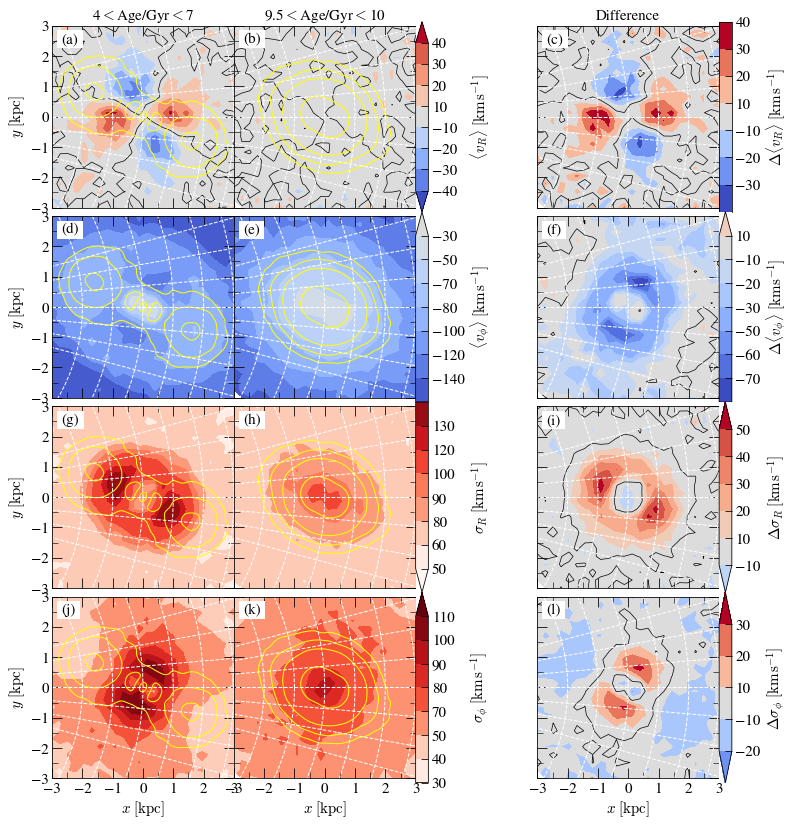

In [290]:
for difmap_variables in difmap_variable_list:
#     if 'vertex' not in difmap_variables: continue
    
    error_maps_bool = True if 'error' in difmap_variables[0] else False
    rightaxs_bool = not error_maps_bool or (error_maps_bool and diff_errors_bool)
    
    if True: #Symbols
        symbol_difmap_dict = {}
        symbol_difmap_diff_dict = {}

        for index, variable in enumerate(difmap_variables):
            symbol_difmap_dict[index] = kinematic_symbol_dict[variable] + kinematic_units_dict[variable]
            symbol_difmap_diff_dict[index] = kinematic_symbol_dict_diff[variable] + kinematic_units_dict[variable]

    map_arrays_and_diff = [] # elements contain [map array young, map array old, difference]
    max_val_and_diff = [] # elements contain [min map value, min difference]
    min_val_and_diff = [] # elements contain [max map value, max difference]
    
    for difmap_string in difmap_variables: # get arrays and min/max values
        if difmap_string not in full_map_string_list:
            raise ValueError("The difmap_variable is not in full_map_string_list...")
        
        array_difference = map_dict[difmap_string][age_first]-map_dict[difmap_string][age_second]
        if difmap_string in ["vertex","tilt","spherical_tilt"]:
            array_difference[array_difference > 90] = 180 - array_difference[array_difference > 90]
            array_difference[array_difference < -90] = -(180 + array_difference[array_difference < -90])

        map_arrays_and_diff.append([map_dict[difmap_string][age_first],map_dict[difmap_string][age_second],array_difference])
        min_difference = np.nanmin(array_difference)
        max_difference = np.nanmax(array_difference)

        min_age_first, min_age_second = np.nanmin(map_dict[difmap_string][age_first]), np.nanmin(map_dict[difmap_string][age_second])
        max_age_first, max_age_second = np.nanmax(map_dict[difmap_string][age_first]), np.nanmax(map_dict[difmap_string][age_second])
        vmin = np.nanmin([min_age_first, min_age_second])
        vmax = np.nanmax([max_age_first,max_age_second])
        if difmap_string == 'number': vmin=min_star_number
        elif difmap_string == 'n_density': vmin=min_star_number/(x_step*y_step)
            
        min_val_and_diff.append([vmin, min_difference])
        max_val_and_diff.append([vmax, max_difference])
    
    if sharing_cbar_bool:
        for shared_difmap_list in shared_difmap_variables:
            try:
                first_index = list(difmap_variables).index(shared_difmap_list[0])
                second_index = list(difmap_variables).index(shared_difmap_list[1])
            except ValueError:
                continue
            print(f"Sharing {shared_difmap_list[0]} and {shared_difmap_list[1]}")

            # leftaxs
            shared_vmin = np.min([min_val_and_diff[first_index][0],min_val_and_diff[second_index][0]])
            shared_vmax = np.max([max_val_and_diff[first_index][0],max_val_and_diff[second_index][0]])

            min_val_and_diff[first_index][0],min_val_and_diff[second_index][0]=shared_vmin,shared_vmin
            max_val_and_diff[first_index][0],max_val_and_diff[second_index][0]=shared_vmax,shared_vmax

            # rightaxs
            if sharing_diff_cbar_bool:
                diff_shared_vmin = np.min([min_val_and_diff[first_index][1],min_val_and_diff[second_index][1]])
                diff_shared_vmax = np.max([max_val_and_diff[first_index][1],max_val_and_diff[second_index][1]])
                min_val_and_diff[first_index][1],min_val_and_diff[second_index][1]=diff_shared_vmin,diff_shared_vmin
                max_val_and_diff[first_index][1],max_val_and_diff[second_index][1]=diff_shared_vmax,diff_shared_vmax

    #FIG-------------------------------------------------------------------------------------------------------------
    if True:
        n_rows = len(difmap_variables)
        n_cols = 6
        
        fig_size, fig_aspect_ratio, central_space, cbar_width, cbar_ticksize = get_difmap_gridspec_params(x_variable+y_variable, n_rows)
        
        grid = gridspec.GridSpec(n_rows,n_cols,width_ratios=[1, 1, cbar_width, central_space, 1, cbar_width], hspace=0,wspace=0)
        
        fig = plt.figure(figsize=(fig_aspect_ratio*fig_size,fig_size))

        leftaxs = [fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j in [0,1]]
        leftaxs_cbars = [fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j == 2]
        rightaxs = [fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j == 4]
        rightaxs_cbars = [fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j == 5]

    #PLOTS----------------------------------------------------------------------------------------------------------------
    index_left_row = 0
    for ax in leftaxs:
        if ax.get_subplotspec().is_last_row() and not last_row_bool: continue

        map_variable = difmap_variables[index_left_row]
        first_array = map_arrays_and_diff[index_left_row][0]
        second_array = map_arrays_and_diff[index_left_row][1]

        vmax = max_val_and_diff[index_left_row][0]
        vmin = min_val_and_diff[index_left_row][0]
        levels = get_levels(map_variable,vmin,vmax)

        if cbar_extending_bool:
            min_extend, max_extend = False,False
            if np.nanmin([first_array,second_array]) < np.min(levels):
                min_extend = True
            if np.nanmax([first_array,second_array]) > np.max(levels):
                max_extend = True
            if min_extend and max_extend: map_contours_extend = 'both'
            elif min_extend: map_contours_extend = 'min'
            elif max_extend: map_contours_extend = 'max'
            else: map_contours_extend = 'neither'
        else: map_contours_extend = 'neither'; min_extend = False; max_extend = False

        colors, cmap = get_colors_and_cmap(levels, map_variable, diff = False)

        if ax.get_subplotspec().is_first_col():
            if ax.get_subplotspec().is_first_row():
                ax.set_title(title_first_dict[comparison_type])

            smoothed_first_array = gaussian_filter(first_array, map_contours_sigma)
            contf_first = ax.contourf(smoothed_first_array,extent=extent,colors=colors,cmap=cmap,extend=map_contours_extend,levels=levels)
            zero_cont = ax.contour(smoothed_first_array,extent=extent,levels=[0],colors='black',linewidths=zero_contour_lw)

            if contours_on:
                if comparison_type != 'ages': h_first = h.T
                contour = ax.contour(h_first, extent=extent, levels=contour_levels,colors=contour_color, linewidths=contour_lw)
                #ax.clabel(contour, inline=True, fontsize= 20)#, fmt = ticker.LogFormatterMathtext())
                pass

        else: # second column
            if ax.get_subplotspec().is_first_row():
                ax.set_title(title_second_dict[comparison_type])

            smoothed_second_array = gaussian_filter(second_array, map_contours_sigma)
            contf_second = ax.contourf(smoothed_second_array,extent=extent,colors=colors,cmap=cmap,extend=map_contours_extend,levels=levels)
            zero_cont = ax.contour(smoothed_second_array,extent=extent,levels=[0],colors='black',linewidths=zero_contour_lw)

            if True: # colorbar
                cax = leftaxs_cbars[index_left_row]
                cbar = fig.colorbar(contf_second, cax=cax, extendfrac='auto',spacing=cbar_spacing)

                cbar.set_label(label=symbol_difmap_dict[index_left_row], size=cbar_labelsize)
                if True: # cbar ticks
                    cax.tick_params(length=cbar_ticksize)
                    cbar.ax.minorticks_off()

                    ticks = cbar.ax.get_yticks() if isinstance(levels,int) or levels is None else levels
                    if ax.get_subplotspec().is_first_row():
                        cbar.set_ticks(ticks[1:]) if not min_extend else cbar.set_ticks(ticks)
                    elif ax.get_subplotspec().is_last_row():
                        cbar.set_ticks(ticks[:-1]) if not max_extend else cbar.set_ticks(ticks)
                    else:
                        if min_extend and max_extend:
                            pass
                        elif min_extend:
                            cbar.set_ticks(ticks[:-1])
                        elif max_extend:
                            cbar.set_ticks(ticks[1:])
                        else:
                            cbar.set_ticks(ticks[1:-1])

            if contours_on:
                if comparison_type != 'ages': h_second = h.T
                contour = ax.contour(h_second, extent=extent, levels=contour_levels,colors=contour_color, linewidths=contour_lw)
                #ax.clabel(contour, inline=True, fontsize= 20)#, fmt = ticker.LogFormatterMathtext())
                pass

            index_left_row += 1

        if x_variable == 'x': # longitude & radii lines
            for y_l in y_range_l:
                ax.plot([sun_coords[0],x_max],[sun_coords[1],y_l], 'w--',linewidth=contour_lw)
            for radius in radii_list:
                x_circ,y_circ = MF.get_circle(radius)
                ax.plot(x_circ+sun_coords[0],y_circ+sun_coords[1], 'w--',linewidth=contour_lw)

    if rightaxs_bool:
        index_right_row = 0
        for ax in rightaxs:
            if ax.get_subplotspec().is_first_row():
                ax.set_title("Difference")

            map_variable = difmap_variables[index_right_row]
            array_diff = map_arrays_and_diff[index_right_row][2]

            vmax = max_val_and_diff[index_right_row][1]
            vmin = min_val_and_diff[index_right_row][1]            
            levels = get_levels(map_variable,vmin,vmax,diff=True)

            if cbar_extending_bool:
                min_extend, max_extend = False,False
                if np.nanmin(array_diff) < np.min(levels):
                    min_extend = True
                if np.nanmax(array_diff) > np.max(levels):
                    max_extend = True
                if min_extend and max_extend: map_contours_extend = 'both'
                elif min_extend: map_contours_extend = 'min'
                elif max_extend: map_contours_extend = 'max'
                else: map_contours_extend = 'neither'
            else: map_contours_extend = 'neither'; min_extend = False; max_extend = False

            colors, cmap = get_colors_and_cmap(levels, map_variable, diff = True)

            smoothed_array_diff = gaussian_filter(array_diff, map_contours_sigma)
            contf_diff = ax.contourf(smoothed_array_diff,extent=extent,colors=colors,cmap=cmap,extend=map_contours_extend,levels=levels)
            zero_cont = ax.contour(smoothed_array_diff,extent=extent,levels=[0],colors='black',linewidths=zero_contour_lw)

            if True: # colorbar
                cax = rightaxs_cbars[index_right_row]
                cbar = fig.colorbar(contf_diff, cax=cax,extendfrac='auto',spacing=cbar_spacing)

                if cbar_difference_label:
                    cbar.set_label(label=symbol_difmap_diff_dict[index_right_row], size=cbar_labelsize)
                if True: # cbar ticks
                    cax.tick_params(length=cbar_ticksize)
                    cbar.ax.minorticks_off()

                    ticks = cbar.ax.get_yticks() if isinstance(levels,int) or levels is None else levels
                    if ax.get_subplotspec().is_first_row():
                        cbar.set_ticks(ticks[1:]) if not min_extend else cbar.set_ticks(ticks)
                    elif ax.get_subplotspec().is_last_row():
                        cbar.set_ticks(ticks[:-1]) if not max_extend else cbar.set_ticks(ticks)
                    else:
                        if min_extend and max_extend:
                            pass
                        elif min_extend:
                            cbar.set_ticks(ticks[:-1])
                        elif max_extend:
                            cbar.set_ticks(ticks[1:])
                        else:
                            cbar.set_ticks(ticks[1:-1])

            if contours_diff_on:
                right_h = h_first - h_second if comparison_type == 'ages' else h.T #NEED CONTOURS FOR BOTH MODELS
                contour = ax.contour(right_h, extent=extent, levels=contour_levels,colors=contour_color, linewidths=contour_lw)
                #ax.clabel(contour, inline=True, fontsize= 20)#, fmt = ticker.LogFormatterMathtext())
                pass

            if x_variable == 'x': # longitude & radii lines
                for y_l in y_range_l:
                    ax.plot([sun_coords[0],x_max],[sun_coords[1],y_l], 'w--',linewidth=contour_lw)
                for radius in radii_list:
                    x_circ,y_circ = MF.get_circle(radius)
                    ax.plot(x_circ+sun_coords[0],y_circ+sun_coords[1], 'w--',linewidth=contour_lw)

            index_right_row += 1

    #AXIS-----------------------------------------------------------------------------------------------------------------
    x_ticks = mapf.get_map_tick_range(x_variable)
    y_ticks = mapf.get_map_tick_range(y_variable)

    for ax in leftaxs:
        if aspect_equal:
            ax.set_aspect('equal')
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_minor_locator))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_minor_locator))
        #ax.minorticks_off()
        ax.set_yticks(y_ticks)
        ax.set_xticks(x_ticks)
        ax.set_ylabel(variable_symbol_dict[y_variable] + r' $[\mathrm{%s}]$'%y_units) if ax.get_subplotspec().is_first_col() else ax.set_yticklabels([])
        ax.set_xlim(x_left,x_right)
        ax.set_ylim(y_min,y_max)

        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(variable_symbol_dict[x_variable] + r' $[\mathrm{%s}]$'%x_units)
        else:
            if last_row_bool:
                ax.set_xticklabels([])
            else:
                if ax not in [leftaxs[-3],leftaxs[-4]]:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel(variable_symbol_dict[x_variable] + r' $[\mathrm{%s}]$'%x_units)

        if x_variable+y_variable=='lb' and ax.get_subplotspec().is_first_col():
            if not last_row_bool and ax not in [leftaxs[-3],leftaxs[-4]]:
                ax.set_yticklabels(['']+y_ticks[1:])
            elif last_row_bool and not ax.get_subplotspec().is_last_row():
                ax.set_yticklabels(['']+y_ticks[1:])

    if rightaxs_bool:
        for ax in rightaxs:
            if aspect_equal:
                ax.set_aspect('equal')
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_minor_locator))
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_minor_locator))
            #ax.minorticks_off()
            ax.set_xticks(x_ticks)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([])
            ax.set_xlabel(variable_symbol_dict[x_variable] + r' $[\mathrm{%s}]$'%x_units) if ax.get_subplotspec().is_last_row() else ax.set_xticklabels([])
            ax.set_xlim(x_left,x_right)
            ax.set_ylim(y_min,y_max)

    if True: # abcde enumerating and subplots minorticks
        abc_axes = np.concatenate([leftaxs,rightaxs]) if rightaxs_bool else leftaxs
        
        if n_rows == 3: letter_string = "abdeghcfi" if rightaxs_bool else "abcdef"
        elif n_rows == 4: letter_string = "abdeghjkcfil" if rightaxs_bool else "abcdefgh"
        
        for i, ax in enumerate(abc_axes):
            abc_str = r"(%s)"%letter_string[i]
            
            abc_xy = get_abc_xy(n_rows)
            ax.text(x=abc_xy[0],y=abc_xy[1],s=abc_str,transform=ax.transAxes,bbox=dict(boxstyle="square", fc='white', lw=0,mutation_aspect=0.5))
            
            if x_variable+y_variable == 'lb':
                ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
            elif x_variable+y_variable == 'xy':
                ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

    if extra_variable_text_bool: # extra_variable text
        xtext_offset = np.diff(x_ticks)[0]/2
        xtext = x_right + xtext_offset if x_variable == 'l' else x_right - xtext_offset
        ytext = y_min - 1.6*np.diff(y_ticks)[0]
        if x_variable+y_variable == 'lb' and zabs:
            xtext += 0
            ytext += 0.6
        elif x_variable+y_variable=='xy': 
            ytext += 0.3

        extra_variable_text = get_extra_variable_string(variable = extra_variable, units = extra_variable_units, vmin = extra_variable_min, vmax = extra_variable_max)
        ax.text(x=xtext,y=ytext,s=extra_variable_text,size=extra_text_size,bbox=dict(boxstyle="square",fc='white',lw=0.03))#, mutation_aspect=0.7))

    if not rightaxs_bool:
        for ax in rightaxs:
            fig.delaxes(ax)
        for ax in rightaxs_cbars:
            fig.delaxes(ax)
    if not last_row_bool:
        fig.delaxes(leftaxs[-1])
        fig.delaxes(leftaxs[-2])
    
    if True: # filename, save
        sharing_string = '' #if  sharing_cbar_bool else "_notshared"
        last_row_string = '_noBottom' if not last_row_bool else ''
        extra_var_string = f"{extra_variable_min}{extra_variable}{extra_variable_max}"

        filename = x_variable+y_variable+f"_difmap_"+extra_var_string+'_'+difmap_variables[-2]+'_'+difmap_variables[-1]+sharing_string+last_row_string

        # filename += '_anicorr0.05' if inner_anicorr_contour != 0.1 else ''
        
        print(save_path+filename)
        
        if save_bool:
            for fileformat in [".png",".pdf"]:
                plt.savefig(save_path+filename+fileformat, bbox_inches='tight',dpi=300)
                print(fileformat)
    
    fig.align_labels()
    plt.show()

### Double maps

In [1112]:
difmap_bool = False
doublemap_bool = True

In [1239]:
# CHOOSE

# doublemap_variable_list = [["anisotropy","correlation","tilt_abs"], ["anisotropy_error","correlation_error","tilt_abs_error"]]
doublemap_variable_list = [["mean_vx","mean_vy"],["std_vx","std_vy"]]

left_maps = doublemap_variable_list[0]
right_maps = doublemap_variable_list[1]

In [1240]:
map_contours_sigma = 0

zero_contour_lw = 0.7

contour_number = None # Can't currently be set to a number because the levels will differ between young and old, so the colorbar can only represent one of them

In [1241]:
# All font sizes for axes, titles, etc are set relative to font.size (https://stackoverflow.com/questions/62288898)

plt.rcParams["font.size"] = 26 if x_variable+y_variable=="lb" else 22

plt.rcParams["axes.titlesize"] = "medium"
cbar_labelsize = "medium"

In [1250]:
# heatmap = True
heatmap = False

In [1251]:
def get_doublemap_gridspec_params(variables, n_rows):
    if variables == "xy":
        if n_rows == 2:
            fig_size = 10
            fig_aspect_ratio = 2.29
            central_space = 0.49
            cbar_width = 0.06
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
        if n_rows == 3:
            fig_size = 13
            fig_aspect_ratio = 1.56
            central_space = 0.6
            cbar_width = 0.06
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
    elif variables == "lb":
        if n_rows == 2:
            fig_size = 7
            fig_aspect_ratio = 2.3*(x_max-x_min)/(y_max-y_min)
            central_space = 0.51
            cbar_width = 0.05
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
        if n_rows == 3:
            fig_size = 10
            fig_aspect_ratio = 4.52/3*(x_max-x_min)/(y_max-y_min)
            central_space = 0.47
            cbar_width = 0.05
            cbar_ticksize = plt.rcParams['ytick.major.size'] - 2
    return fig_size, fig_aspect_ratio, central_space, cbar_width, cbar_ticksize

In [1277]:
# sharing_cbar_bool = True
sharing_cbar_bool = False

aspect_equal = True
# aspect_equal = False

# save_bool = True
save_bool = False

graphs/standard_100_min/708main/xy_map/-3.5x3.5_-3.5y3.5/bins_13x_13y/7.13b8.85/rot_angle_27/young_and_old/4-7_9.5-10/vrvl/
xy_doublemap_mean_vx_mean_vy


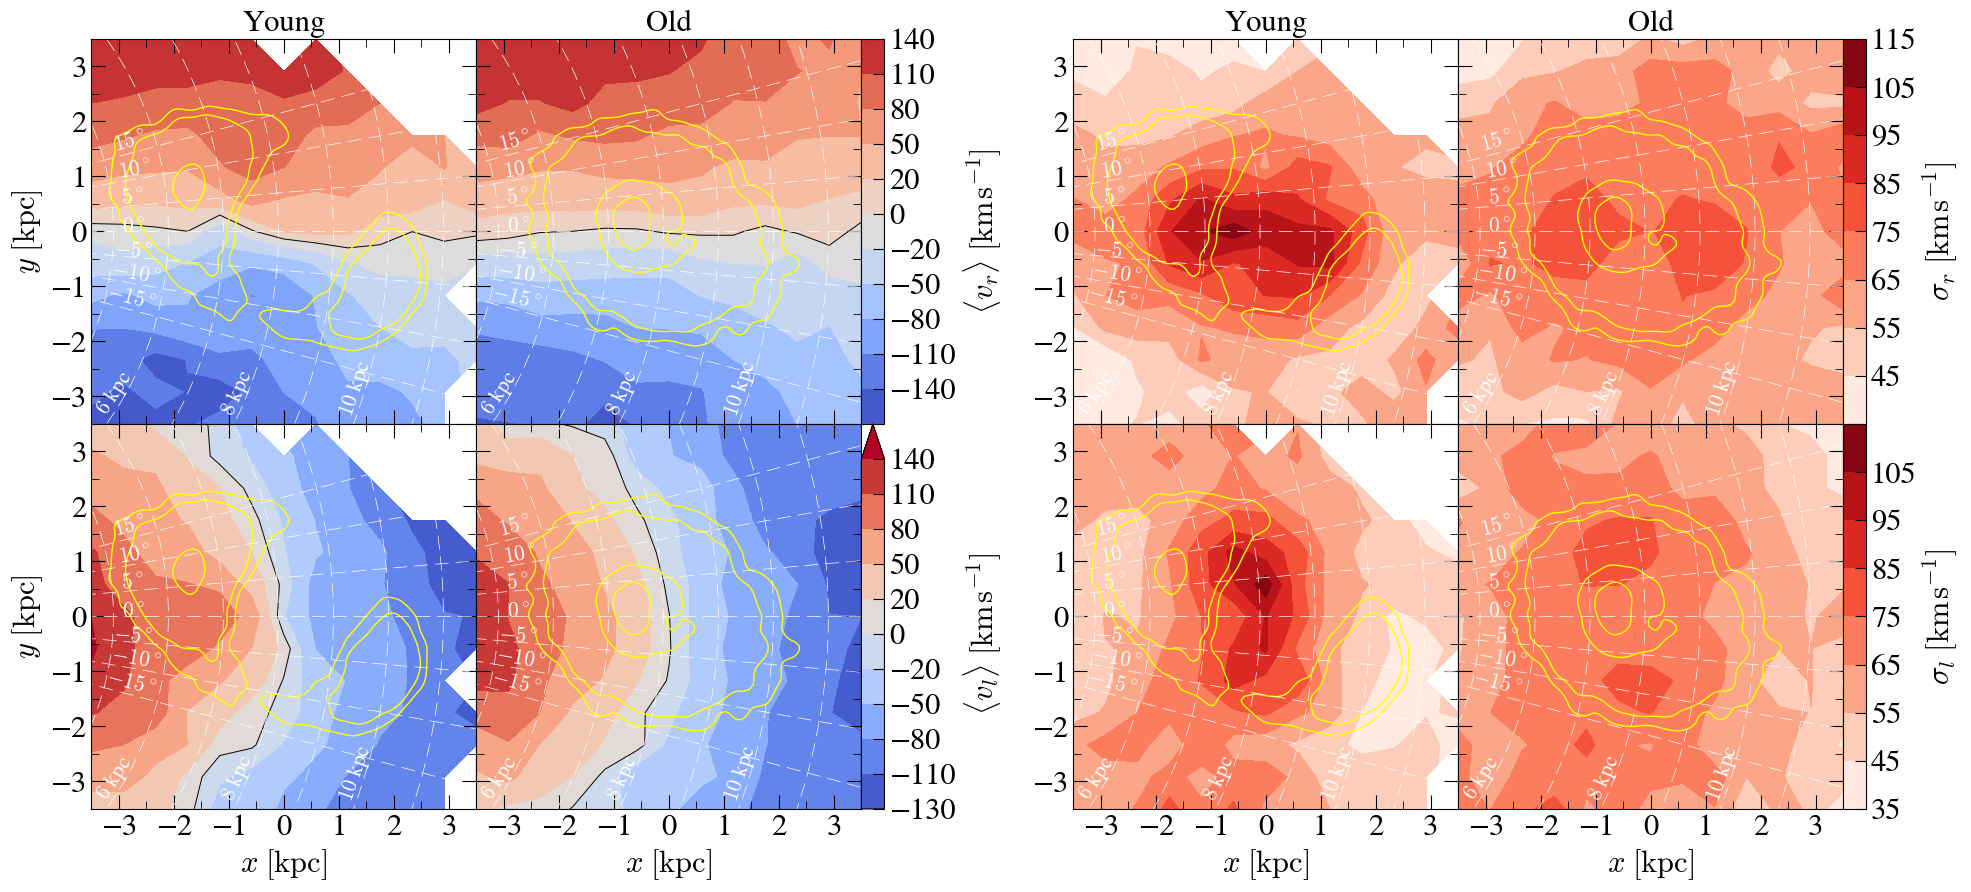

In [1278]:
# double map plot

if True: # define fig and axes
    n_rows = len(left_maps)
    n_cols = 7
    
    fig_size, fig_aspect_ratio, central_space, cbar_width, cbar_ticksize = get_doublemap_gridspec_params(x_variable+y_variable, n_rows)
    grid = gridspec.GridSpec(n_rows,n_cols,width_ratios=[1, 1, cbar_width, central_space, 1, 1, cbar_width], hspace=0,wspace=0)
    fig = plt.figure(figsize=(fig_aspect_ratio*fig_size,fig_size))
    
    leftaxs = np.reshape([fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j in [0,1]], (n_rows,2))
    leftaxs_cbars = [fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j == 2]

    rightaxs = np.reshape([fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j in [4,5]], (n_rows,2))
    rightaxs_cbars = [fig.add_subplot(grid[i,j]) for i in range(n_rows) for j in range(n_cols) if j == 6]

    axes = [leftaxs,rightaxs]
    axes_cbar = [leftaxs_cbars,rightaxs_cbars]

for block in range(len(doublemap_variable_list)):
    for row in range(n_rows):
        map_variable = doublemap_variable_list[block][row]

        vmin,vmax = mapf.get_vminvmax_from_map_dict(map_dict, map_variable, shared_cbar_variables=None if not sharing_cbar_bool else shared_cbar_variables)
        
        norm = plt.Normalize(vmin,vmax)
        
        if not heatmap: # contour levels
            if contour_number is None: # extend and cmap
                levels = get_levels(map_variable,vmin,vmax)
                cbar_extend = PH.get_cbar_extend(min(levels),max(levels),vmin,vmax)
                colors, cmap = get_colors_and_cmap(levels, map_variable, cbar_extend, diff = False)
            else:
                raise ValueError("Using an automatically-generated number of contours is currently broken, as the levels will differ between young and old,"+\
                                 " so the colorbar can only represent one of them")
                levels = contour_number
                cbar_extend = "neither"
                cmap = PH.choose_cmap(vmin,vmax)
                colors = None
        else:
            cmap = PH.choose_cmap(vmin,vmax)
            cbar_extend = PH.get_cbar_extend(vmin,vmax,np.nanmin(map_dict[map_variable]),np.nanmax(map_dict[map_variable]))
        
        for col in range(len(age_range)):

            ax = axes[block][row][col]
            
            if row == 0: ax.set_title(titles[col])
            
            smoothed_array = gaussian_filter(map_dict[map_variable][col], map_contours_sigma)
            zero_cont = ax.contour(smoothed_array,extent=extent,levels=[0],colors='black',linewidths=zero_contour_lw)
            
            if heatmap:
                mappable = ax.imshow(map_dict[map_variable][col],extent=extent,cmap=cmap,norm=norm,origin="lower")
            else:
                mappable = ax.contourf(smoothed_array,extent=extent,colors=colors,cmap=cmap,extend=cbar_extend,levels=levels)#,norm=norm)

            if density_contours_on: # density contour
                ax.contour(count_list[col]/(stellar_mass if mass_density_bool else 1), extent=extent, levels=density_contour_levels,
                           colors=density_contour_color, linewidths=density_contour_lw)
            
            if plotting_lines_bool:
                highlight_factor = 3
                line_colour = "w"
                line_label_colour = "w"

                for ang in angle_range:
                    if highlight_lines and ang in angle_selection:

                        x_select = np.array(radius_selection)*np.cos(np.radians(ang))-abs(sun_coords[0])
                        y_select = np.array(radius_selection)*np.sin(np.radians(ang))

                        # outbound pieces
                        ax.plot([sun_coords[0],x_select[0]],[sun_coords[1],y_select[0]], f'{line_colour}--',linewidth=contour_lw,dashes=dashes)
                        ax.plot([x_select[1],x_max],[y_select[1],(x_max+abs(sun_coords[0])) * np.tan(np.radians(ang))], f'{line_colour}--',linewidth=contour_lw,dashes=dashes)

                        # highlighted piece
                        ax.plot(x_select,y_select, f'{line_colour}--',linewidth=highlight_factor*contour_lw,dashes=[d/highlight_factor for d in dashes])
                    else:
                        ax.plot([sun_coords[0],x_max],[sun_coords[1],(x_max+abs(sun_coords[0])) * np.tan(np.radians(ang))], f'{line_colour}--',linewidth=contour_lw,dashes=dashes)

                    if plotting_line_labels and ang in angle_label_vals:
                        neg_shift = 0.15 if ang < 0 else 0
                        
                        pos_shift_dict = {
                            3: 0.3,
                            3.5: 0.55
                        }
                        pos_shift = pos_shift_dict[x_max]
                        
                        ang_label_x = (abs(sun_coords[0])-x_max+pos_shift)*np.cos(np.radians(ang))-abs(sun_coords[0])-neg_shift

                        ax.text(x=ang_label_x,y=(ang_label_x+abs(sun_coords[0]))*np.tan(np.radians(ang))*1.1,\
                                        s=fr"${ang}^\circ$",color=line_label_colour,rotation=ang,size=line_label_fontsize)

                for radius in radii_list:

                    if highlight_lines and radius in radius_selection:
                        x_outer,y_outer = PH.get_ellipse_coords(radius, phi_range=[angle_selection[1],angle_selection[0]])
                        ax.plot(x_outer+sun_coords[0],y_outer+sun_coords[1], f'{line_colour}--',linewidth=contour_lw,dashes=dashes)

                        x_inner,y_inner = PH.get_ellipse_coords(radius, phi_range=[angle_selection[0],angle_selection[1]])
                        ax.plot(x_inner+sun_coords[0],y_inner+sun_coords[1], f'{line_colour}--',linewidth=highlight_factor*contour_lw,dashes=[d/highlight_factor for d in dashes])
                    else:
                        x_circ,y_circ = PH.get_ellipse_coords(radius)
                        ax.plot(x_circ+sun_coords[0],y_circ+sun_coords[1], f'{line_colour}--',linewidth=contour_lw,dashes=dashes)

                    if plotting_line_labels and radius in radii_label_vals:
                        low_y = 0.94*y_min

                        x_intersect = np.sqrt(radius**2 - low_y**2)
                        slope = -x_intersect / np.sqrt(radius**2 - x_intersect**2)
                        rot = -np.degrees(np.arctan(slope))
                        
                        x_shift_dict = {
                            3: -0.31,
                            3.5: -0.4
                        }
                        
                        ax.text(x=x_intersect-abs(sun_coords[0])+x_shift_dict[x_max],y=low_y,s=fr"${radius}$ kpc",color=line_label_colour,rotation=rot,size=line_label_fontsize)
            
            if True: # ticks, lims
                ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_minor_locator))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(y_minor_locator))
                #ax.minorticks_off()
                
                ax.set_xticks(x_ticks)
                ax.set_yticks(y_ticks)
                
                if block == 0 and col == 0:
                    ax.set_ylabel(y_label)
                elif col != 0:
                    ax.set_yticklabels([])
                    
                if col==0 and row != n_rows-1:
                    if x_variable+y_variable=="lb" and y_max - max(y_ticks) <= 1:
                        ax.set_yticklabels([None]+y_ticks[1:])

                if row == n_rows-1: 
                    ax.set_xlabel(x_label)
                else:
                    ax.set_xticklabels([])

                ax.set_xlim(x_left,x_right)
                ax.set_ylim(y_min,y_max)
                if aspect_equal: ax.set_aspect('equal')

        if True: # cbar
            cbar_ax = axes_cbar[block][row]
            
            if heatmap:
                cbar = plt.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap), cax=cbar_ax, spacing=cbar_spacing, extend=cbar_extend, extendfrac=0.1)
                cbar.ax.locator_params(nbins=7) # https://stackoverflow.com/questions/22012096
            else:
                cbar = fig.colorbar(mappable, cax=cbar_ax, extendfrac='auto', spacing=cbar_spacing)
            
            cbar.set_label(kinematic_symbols_dict[map_variable] + kinematic_units_dict[map_variable])

            if not heatmap: # cbar ticks
                cbar_ax.tick_params(length=cbar_ticksize)

                ticks = cbar_ax.get_yticks() if isinstance(levels,int) or levels is None else levels
                
                min_extend = cbar_extend in ["min","both"]
                max_extend = cbar_extend in ["max","both"]
                
                if row == 0:
                    cbar.set_ticks(ticks[1:]) if not min_extend else cbar.set_ticks(ticks)
                elif row == n_rows-1:
                    cbar.set_ticks(ticks[:-1]) if not max_extend else cbar.set_ticks(ticks)
                else:
                    if min_extend and max_extend:
                        cbar.set_ticks(ticks)
                    elif min_extend:
                        cbar.set_ticks(ticks[:-1])
                    elif max_extend:
                        cbar.set_ticks(ticks[1:])
                    else:
                        cbar.set_ticks(ticks[1:-1])

if heatmap: # remove overlapping ticks
    for block in range(len(doublemap_variable_list)):
        for row in range(n_rows - 1):
            
            current_var = doublemap_variable_list[block][row]
            next_var = doublemap_variable_list[block][row+1]
            
            current_vminvmax = mapf.get_vminvmax_from_map_dict(map_dict,current_var,shared_cbar_variables=None if not sharing_cbar_bool else shared_cbar_variables)
            next_vminvmax = mapf.get_vminvmax_from_map_dict(map_dict,next_var,shared_cbar_variables=None if not sharing_cbar_bool else shared_cbar_variables)
            
            current_cbar_extend = PH.get_cbar_extend(current_vminvmax[0],current_vminvmax[1],np.nanmin(map_dict[current_var]),np.nanmax(map_dict[current_var]))
            next_cbar_extend = PH.get_cbar_extend(next_vminvmax[0],next_vminvmax[1],np.nanmin(map_dict[next_var]),np.nanmax(map_dict[next_var]))
            
            if current_cbar_extend in ["bottom","both"] or next_cbar_extend in ["top","both"]:
                continue
            
            mapf.remove_overlapping_ticks(axes_cbar[block][row], axes_cbar[block][row+1], current_vminvmax, next_vminvmax)
                        
if extra_variable_text_bool: # extra_variable text
    xtext_offset = np.diff(x_ticks)[0]/2
    xtext = x_right + xtext_offset if x_variable == 'l' else x_right - xtext_offset
    ytext = y_min - 1.6*np.diff(y_ticks)[0]
    if x_variable+y_variable == 'lb' and zabs:
        xtext += 0
        ytext += 0.6
    elif x_variable+y_variable=='xy': 
        ytext += 0.3

    extra_variable_text = get_extra_variable_string(variable = extra_variable, units = extra_variable_units, vmin = extra_variable_min, vmax = extra_variable_max)
    ax.text(x=xtext,y=ytext,s=extra_variable_text,size=extra_text_size,bbox=dict(boxstyle="square",fc='white',lw=0.03))#, mutation_aspect=0.7))
    
if True: # filename, save
    fig.align_labels()
    
    maps_string = f"_{left_maps[0]}_{left_maps[1]}"
    maps_string += "_fractionalerrors" if any("fractionalerror" in rightmap for rightmap in right_maps) else ""
    maps_string += "_sharing" if sharing_cbar_bool and mapf.any_map_pair_is_shared(doublemap_variable_list, shared_cbar_variables) else ""
    
    filename = f"{x_variable}{y_variable}_doublemap{maps_string}"
    
    if not heatmap and contour_number is not None:
        filename += f"_{contour_number}contourN"
    
    if heatmap:
        mappable_path = save_path + "heatmaps/"
        MF.create_dir(mappable_path)
    else:
        mappable_path = save_path
    
    print(mappable_path+"\n"+filename)

    if save_bool:
        for fileformat in [".png",".pdf"]:
            plt.savefig(mappable_path+filename+fileformat, bbox_inches='tight',dpi=300)
            print(fileformat)

plt.show()

min 0.7328850579149211
max 42.09519835815662


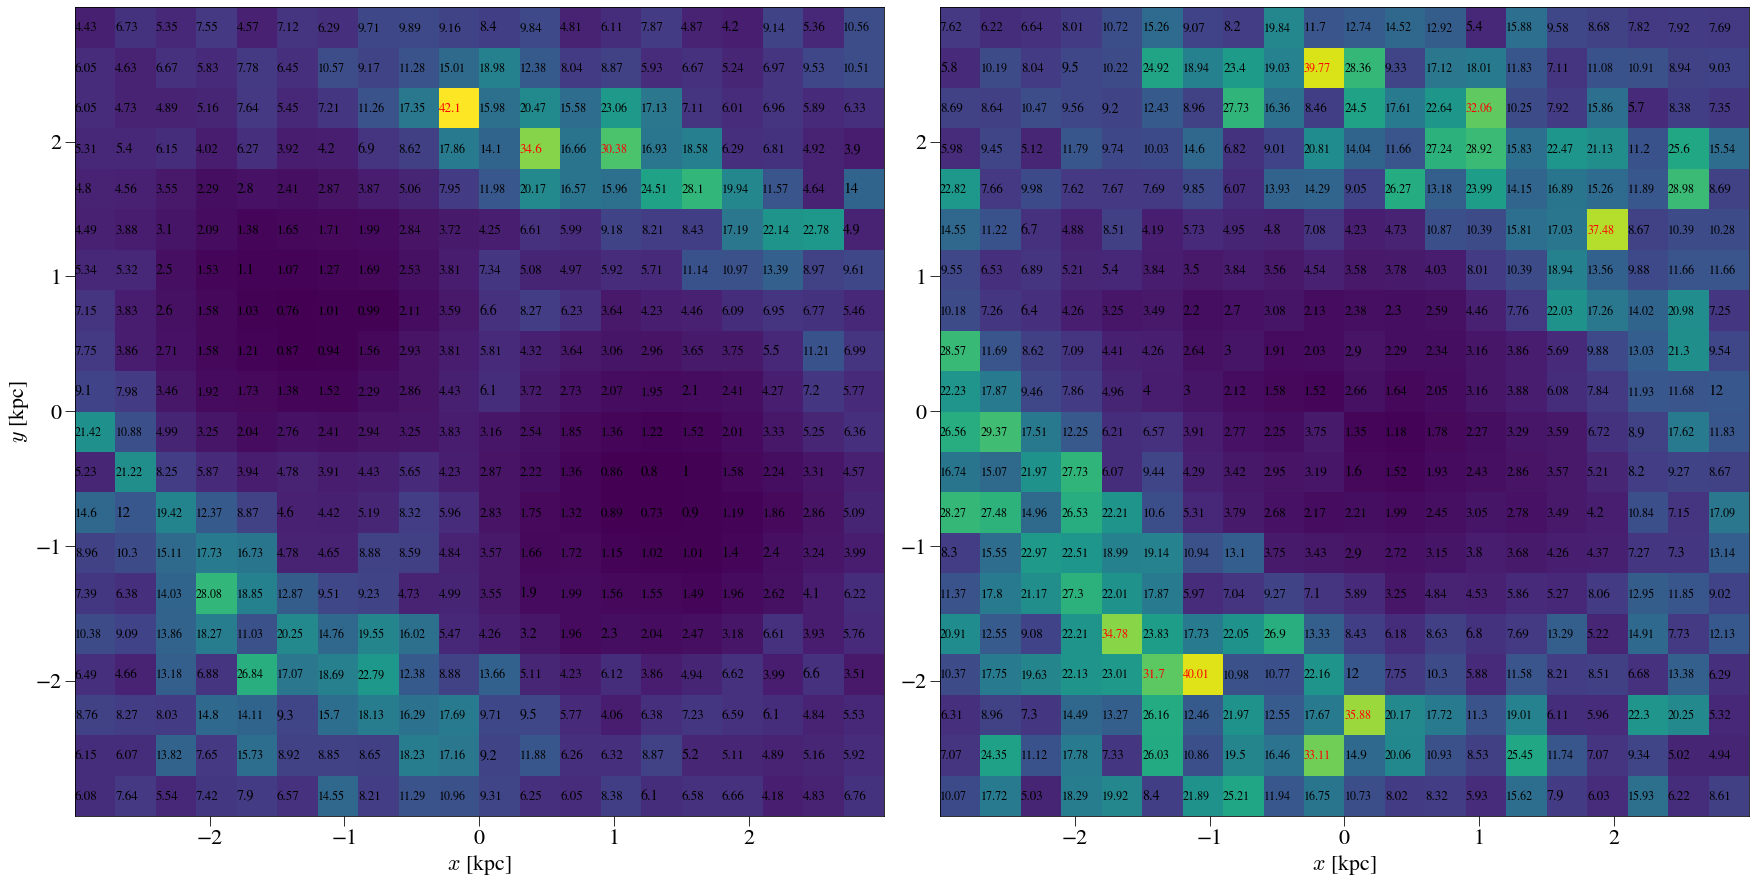

In [151]:
# visualise map values

map_visualise = "tilt_abs_error"
val_lim = 30

# limit_below = True
limit_below = False

limit_color = "yellow" if "error" not in map_visualise else "red"

print("min",np.nanmin(map_dict[map_visualise]))
print("max",np.nanmax(map_dict[map_visualise]))

plot_values_heatmap(map_visualise,map_dict[map_visualise],red_limit_val=val_lim,red_limit_below=limit_below,limit_color=limit_color)

# Data heatmaps

In [45]:
o_contours_on = False

In [46]:
title_left = label_rich.split('(')[0]
title_right = label_poor.split('(')[0]

In [77]:
# CHOOSE

difmap_variables = \
["anisotropy","correlation","vertex_abs"]
# ["anisotropy","correlation","tilt_abs"]
# ["anisotropy","correlation","tilt_abs","tilt"],
# ["anisotropy","correlation","tilt_abs","spherical_tilt"],
# ["mean_vx","mean_vy","std_vx","std_vy"],
# ["anisotropy_error","correlation_error","tilt_abs_error"],
# ["anisotropy_error","correlation_error","tilt_abs_error","tilt_error"],
# ["anisotropy_error","correlation_error","tilt_abs_error","spherical_tilt_error"],

n_difmap_variables = len(difmap_variables[0])
print(difmap_variables)

['anisotropy', 'correlation', 'vertex_abs']


In [51]:
# settings

density_contours_sigma = 3

major_ticksize = 6 if n_difmap_variables == 4 else 4
minor_ticksize = 3 if n_difmap_variables == 4 else 1.5

#Colorbar params
rightax_shift_dict = {"l": -0.0129, "d": 0.059, "x": -0.0129}
leftax_shift_dict = {"l": -0.0725, "d": 0.059, "x": -0.0725}

if "error" in difmap_variable_list[0]:
    plt.rcParams.update({'font.size' : 14})
    plt.rcParams.update({'axes.titlesize': 15})

if x_variable+y_variable == 'lb' and zabs:
    title_size = 16
    
    rightax_bottom = 0 
    leftax_bottom = 0 
    height_change = 0    
    height_change_right = 0 

    rightax_shift_dict['l'] = 0.001
    leftax_shift_dict['l'] = 0.001
    cbar_labelsize = 11 if not only_errors else 14
else:
    if n_difmap_variables == 5:
        title_size = 13
        
        cbar_labelsize = 14 if n_difmap_variables == 4 else 11
        rightax_bottom = 0
        leftax_bottom = 0 #-0.0005
        height_change = 0 #-0.0025
        height_change_right = 0
        
        leftax_shift_dict['d'] = 0.048
        rightax_shift_dict['d'] = 0.047
    else:
        title_size = 16
        
        cbar_labelsize = 14 if n_difmap_variables == 4 else 11
        rightax_bottom = 0
        leftax_bottom = 0 #-0.0005
        height_change = 0 #-0.0025
        height_change_right = 0

width_cbar = 0.011
    
rightax_xshift = rightax_shift_dict[x_variable]
leftax_xshift = leftax_shift_dict[x_variable]

cbar_ticksize = 6 if n_difmap_variables == 4 else 4

In [56]:
divergent_cmap = "coolwarm"
normal_cmap = "magma"
cyclic_cmap = "twilight_shifted"

In [57]:
low_percent = 0
high_percent = 100

full_range_bool = low_percent == 0 and high_percent == 100

4 anisotropy
10 correlation
22 vertex_abs
C:\Users\LuisFernandez\AppData\Local\Temp\ipykernel_65272\2671489149.py:106: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():

C:\Users\LuisFernandez\AppData\Local\Temp\ipykernel_65272\2671489149.py:107: MatplotlibDeprecationWarning: 
The is_first_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_row() instead.
  if ax.is_first_row():

C:\Users\LuisFernandez\AppData\Local\Temp\ipykernel_65272\2671489149.py:119: MatplotlibDeprecationWarning: 
The is_first_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_row() instead.
  if ax.is_first_row():

C:\Users\LuisFernandez\AppData\Local\Temp\ipykernel_65272\2671489149.py:165: MatplotlibDeprecatio

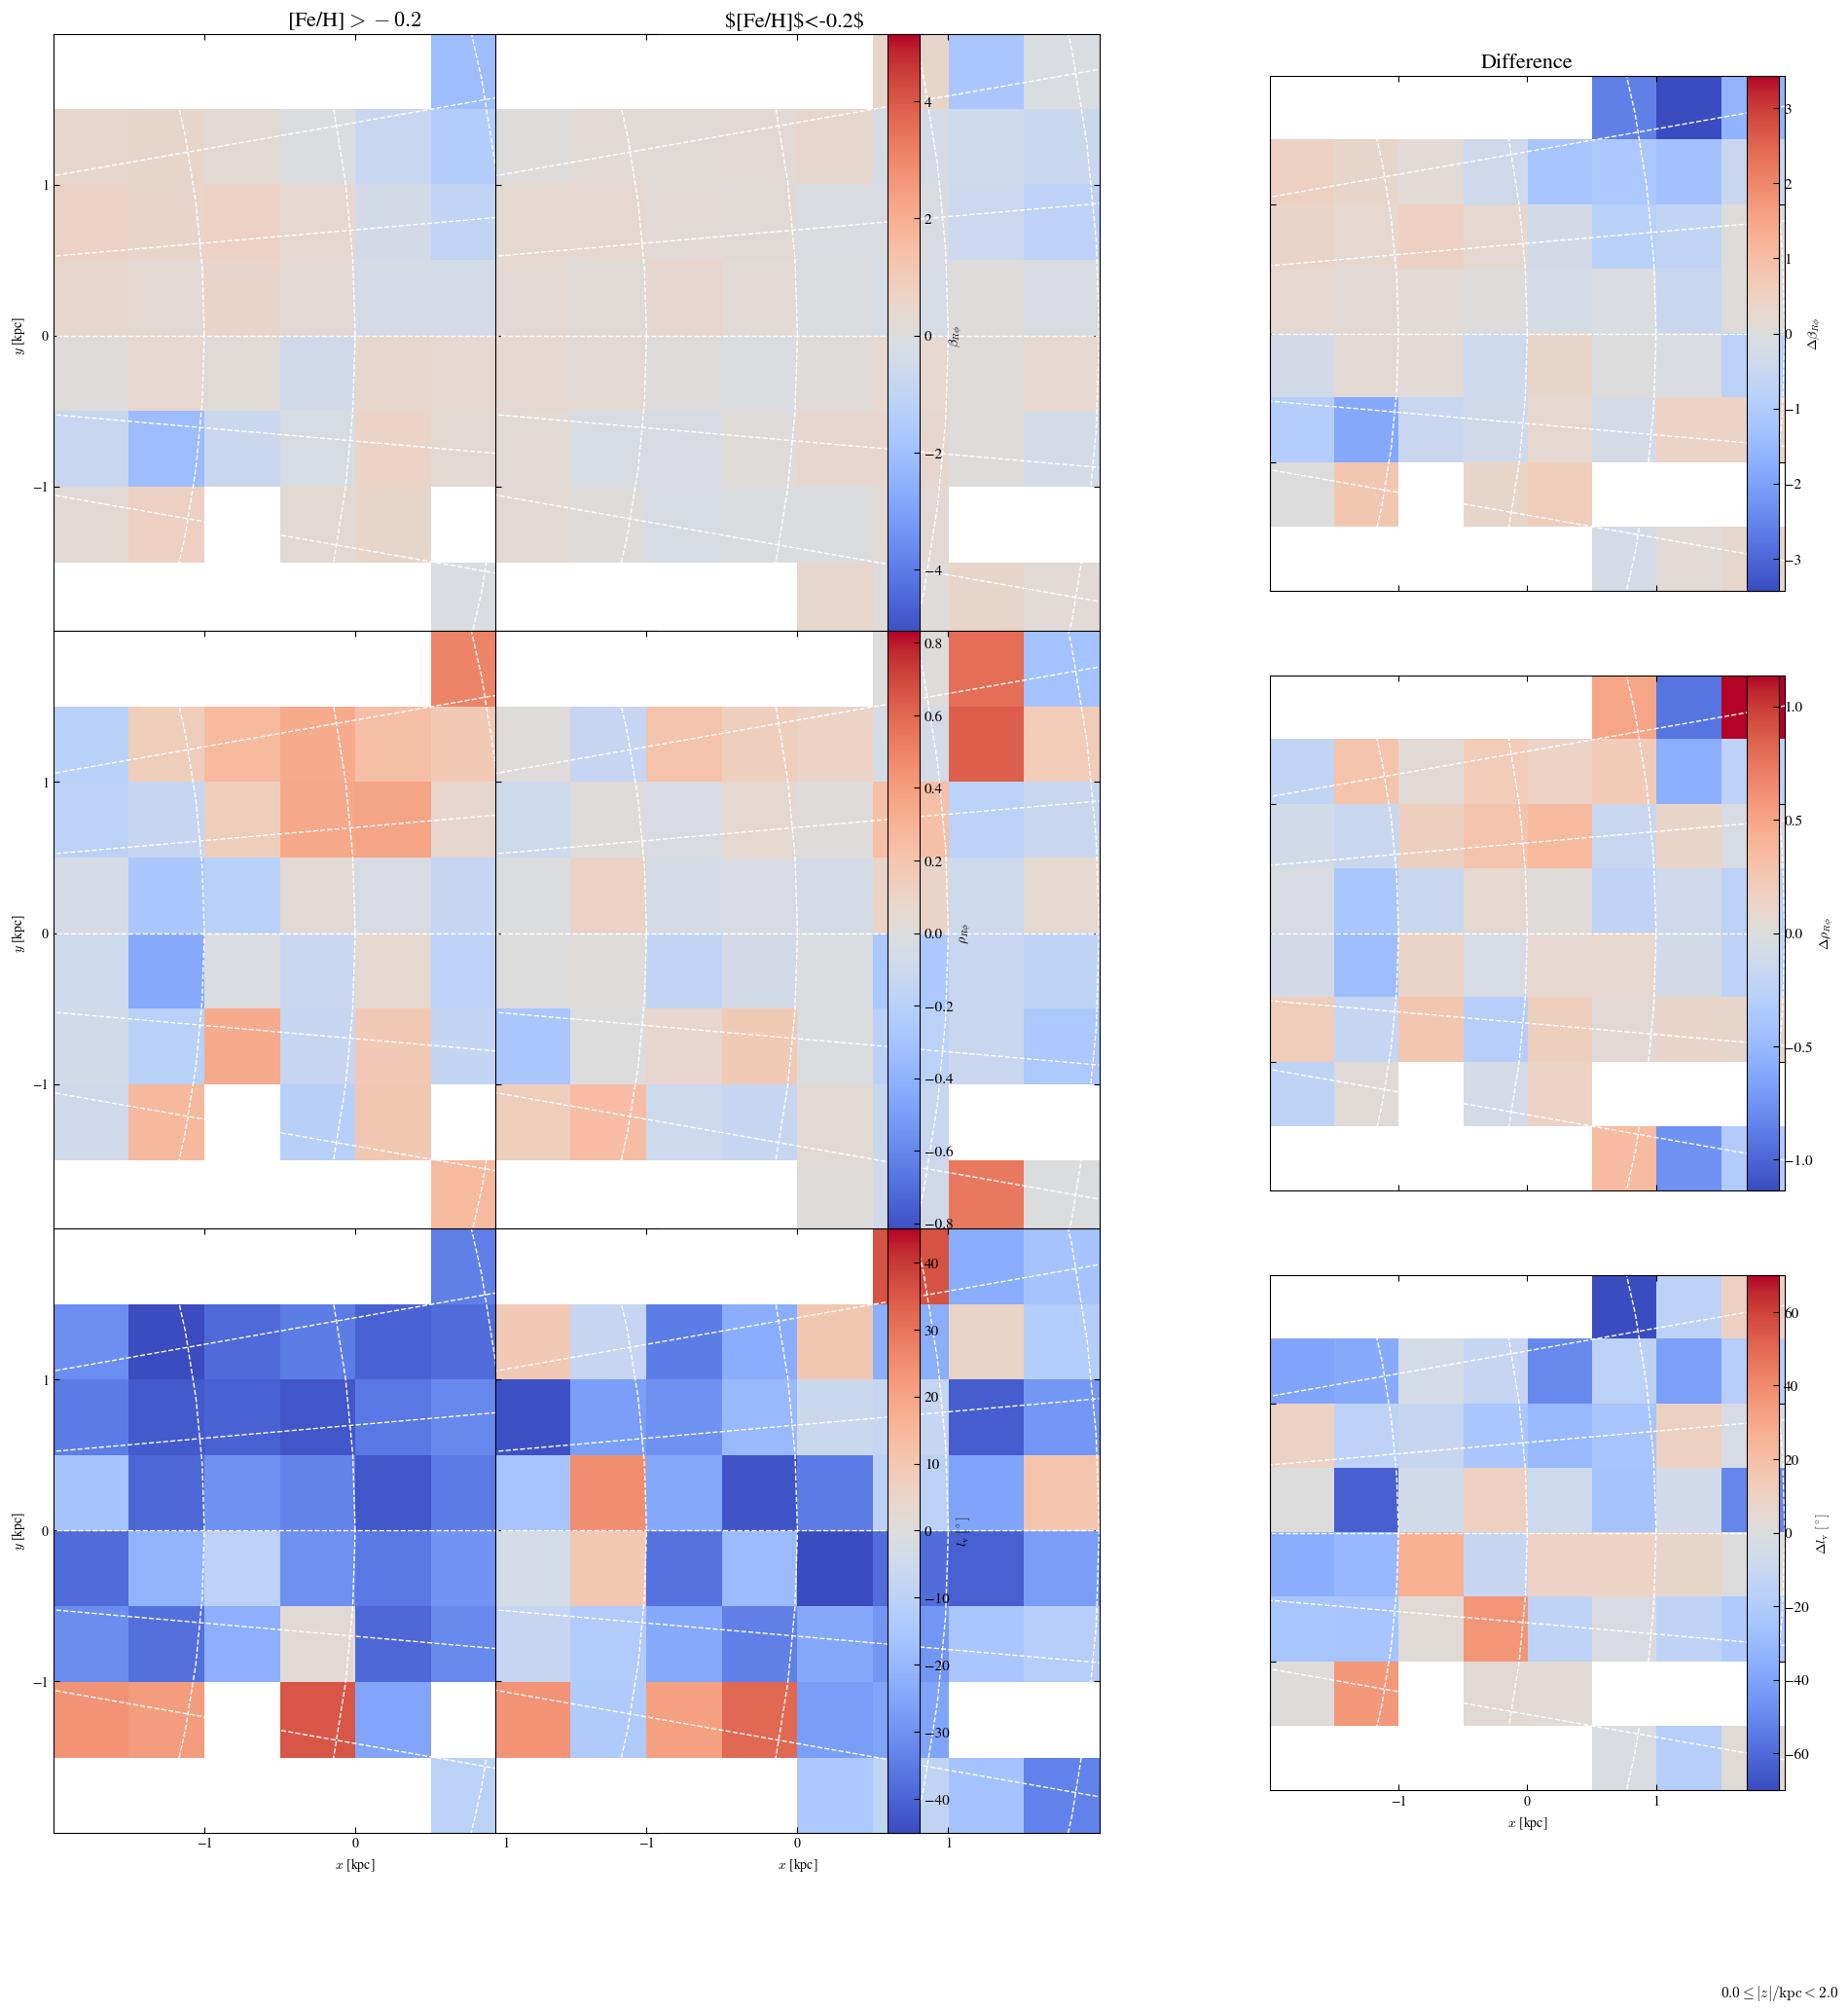

In [78]:
# plotting

symbol_difmap_dict = {}
symbol_difmap_diff_dict = {}

for index, variable in enumerate(difmap_variables):
    symbol_difmap_dict[index] = kinematic_symbol_dict[variable] + kinematic_units_dict[variable]
    symbol_difmap_diff_dict[index] = kinematic_symbol_dict_diff[variable] + kinematic_units_dict[variable]

compare_arrays = []
compare_max = []

difmap_index = 0
while difmap_index < len(difmap_variables):

    for i,map_string in enumerate(full_map_string_list):
        if map_string == difmap_variables[difmap_index]:
            difmap_variable_found = True
            print(i,map_string)
            array_difference = o_map_dict[map_string][age_first]-o_map_dict[map_string][age_second]
            compare_arrays.append([o_map_dict[map_string][age_first],o_map_dict[map_string][age_second],array_difference])
            if map_string == 'vertex_abs':
                max_age_first = 45
                max_age_second = 45
            elif map_string == "vertex":
                max_age_first = 90
                max_age_second = 90
            else:
                max_age_first = np.nanmax(np.abs([np.nanpercentile(o_map_dict[map_string][age_first],low_percent),np.nanpercentile(o_map_dict[map_string][age_first],high_percent)]))
                max_age_second = np.nanmax(np.abs([np.nanpercentile(o_map_dict[map_string][age_second],low_percent),np.nanpercentile(o_map_dict[map_string][age_second],high_percent)]))
            max_difference = np.nanmax(np.abs([np.nanpercentile(array_difference,low_percent),np.nanpercentile(array_difference,high_percent)]))
            compare_max.append([np.nanmax([max_age_first,max_age_second]), max_difference])

            #For tilts don't allow further difference than +-90 for better visualisation of the other regions
            tilt_extends = []
            if map_string in ["vertex","tilt","spherical_tilt"]:
                tilt_diff = copy.copy(array_difference)
                extend_tilt_bool = len(tilt_diff[np.abs(tilt_diff) > 90])
                if extend_tilt_bool:
                    tilt_diff[np.abs(tilt_diff) > 90] = np.nan
                    tilt_max_diff = np.nanmax(np.abs([np.nanmin(tilt_diff),np.nanmax(tilt_diff)]))
                    compare_max[-1][1] = tilt_max_diff
                    tilt_extends.append('both')
                else:
                    tilt_extends.append('neither')

    if not difmap_variable_found:
        raise ValueError("Could not find the difmap_variable!")
    difmap_index += 1

#CONTOURS--------------------------------------------------------------------------------------------------------------
h_first,_,_ = np.histogram2d(df_metals[0][x_variable],df_metals[0][y_variable],bins=100,range = [[x_min,x_max],[y_min,y_max]])
h_second,_,_ = np.histogram2d(df_metals[1][x_variable],df_metals[1][y_variable],bins=100,range = [[x_min,x_max],[y_min,y_max]])
h_first = gaussian_filter(h_first,sigma=density_contours_sigma)
h_second = gaussian_filter(h_second,sigma=density_contours_sigma)
contour_color = 'yellow'
contour_lw = 1

#GRIDSPEC-------------------------------------------------------------------------------------------------------------
n_rows = len(difmap_variables)
n_cols = 3
x_ticks = mapf.get_map_tick_range(x_variable)
y_ticks = mapf.get_map_tick_range(y_variable)

if x_variable+y_variable == 'lb' and zabs:
    if not only_errors:
        if n_difmap_variables == 5:
            gs_right = plt.GridSpec(n_rows,n_cols, left=0.25,right=0.95,hspace=-0.505)
            gs_left = plt.GridSpec(n_rows,n_cols,left=0,right=0.6,wspace=0, hspace=-0.525)
        else:
            gs_right = plt.GridSpec(n_rows,n_cols, left=0.25,right=0.95,hspace=-0.665)
            gs_left = plt.GridSpec(n_rows,n_cols,left=0,right=0.6,wspace=0, hspace=-0.665)
    else:
        gs_right = plt.GridSpec(n_rows,n_cols, left=0.25,right=0.95,hspace=-0.5)
        gs_left = plt.GridSpec(n_rows,n_cols,left=0,right=0.6,wspace=0, hspace=-0.5)
else:
    if n_difmap_variables == 5:
        gs_right = plt.GridSpec(n_rows,n_cols, left=0.19,right=0.85,hspace=0)
        gs_left = plt.GridSpec(n_rows,n_cols,left=0,right=0.6,wspace=-0.66, hspace=-0.01)
    else:
        gs_right = plt.GridSpec(n_rows,n_cols, left=0.25,right=0.85,hspace=0)
        gs_left = plt.GridSpec(n_rows,n_cols,left=0,right=0.6,wspace=-0.49, hspace=-0.01)

fig_aspect = 2.4/3
w, h = 5*figaspect(fig_aspect)
fig = plt.figure(figsize=(w,h),constrained_layout=False)

rightaxs = [fig.add_subplot(gs_right[i,1]) for i in range(n_rows)]
leftaxs = [fig.add_subplot(gs_left[i,j]) for i in range(n_rows) for j in range(n_cols-1)]

#PLOTS--------------------------------------------------------------------------------------------------------------------------

index_left_row = 0
for ax in leftaxs:
    original_cmap = divergent_cmap if difmap_variables[index_left_row] in divergent_map_list else normal_cmap
    cmap = original_cmap if difmap_variables[index_left_row] != "number" else 'viridis'
    cmap = cmap if difmap_variables[index_left_row] not in ["vertex","tilt","spherical_tilt"] else cyclic_cmap
    vmin = -compare_max[index_left_row][0] if difmap_variables[index_left_row] in divergent_map_list else 0
    extend = 'both' if difmap_variables[index_left_row] not in ["vertex_abs","vertex","tilt","spherical_tilt"] and not full_range_bool else 'neither'
    if extend == 'both' and ("error" in difmap_variables[index_left_row] or difmap_variables[index_left_row] == "number"):
        extend = 'max'

    ax.set_xlim(x_left,x_right)
    ax.set_ylim(y_min,y_max)

    if ax.is_first_col():
        if ax.is_first_row():
            ax.set_title(title_left,size=title_size)

        im_first = ax.imshow(compare_arrays[index_left_row][0], extent = extent, interpolation='none', origin='lower',\
                  cmap=cmap, vmin = vmin, vmax = compare_max[index_left_row][0])

        if o_contours_on:
            first_h = h_first.T if comparison_type == 'ages' else h.T
            contour = ax.contour(first_h, extent=extent, levels=contour_levels,colors=contour_color, linewidths=contour_lw)
            #ax.clabel(contour, inline=True, fontsize=20)#, fmt = ticker.LogFormatterMathtext())

    else:
        if ax.is_first_row():
            ax.set_title(title_right,size=title_size)

        im_second = ax.imshow(compare_arrays[index_left_row][1], extent = extent, interpolation='none', origin='lower',\
                  cmap=cmap, vmin = vmin, vmax = compare_max[index_left_row][0])

        cax = fig.add_axes([ax.get_position().x1+leftax_xshift,ax.get_position().y0+leftax_bottom,width_cbar,ax.get_position().height+height_change])
        cax.tick_params(direction="in", length=cbar_ticksize, labelsize=cbar_labelsize)
        im_cbar = im_first #if "error" not in difmap_variables[index_left_row] else im_second
        cbar = fig.colorbar(im_cbar, cax=cax, label=symbol_difmap_dict[index_left_row], extend=extend)
        cbar.ax.minorticks_off()
        automatic_cbarticks = cbar.ax.get_yticks() #ascending order
        if vmin == 0:
            cbar.set_ticks([tick for tick in automatic_cbarticks if tick != 0])
        #if ax.is_first_row():
        #    cbar.set_ticks(automatic_cbarticks[1:])
        #elif ax.is_last_row():
        #    cbar.set_ticks(automatic_cbarticks[:-1])
        #else:
        #    cbar.set_ticks(automatic_cbarticks[1:-1])

        if o_contours_on:
            second_h = h_second.T if comparison_type == 'ages' else h.T
            contour = ax.contour(second_h, extent=extent, levels=contour_levels,colors=contour_color, linewidths=contour_lw)

        index_left_row += 1 #Increase row count after every second column

    if x_variable == 'x':
        for y_l in y_range_l:
            ax.plot([sun_coords[0],x_max],[sun_coords[1],y_l], 'w--',linewidth=contour_lw)
        for radius in radii_list:
            x_circ,y_circ = MF.get_circle(radius)
            ax.plot(x_circ+sun_coords[0],y_circ+sun_coords[1], 'w--',linewidth=contour_lw)

index_right_row = 0
for ax in rightaxs:
    cmap = divergent_cmap# if difmap_variables[index_right_row] in divergent_map_list else cmap
    extend = 'both' if not full_range_bool else 'neither'
    tilt_index = 0
    if difmap_variables[index_right_row] in ["vertex","tilt","spherical_tilt"]:
        extend = tilt_extends[tilt_index]
        tilt_index += 1

    ax.set_xlim(x_left,x_right)
    ax.set_ylim(y_min,y_max)

    if ax.is_first_row():
        ax.set_title("Difference",size=title_size)

    #vmax = None if difmap_variables[index_right_row] in ["vertex","tilt","spherical_tilt"] else compare_max[index_right_row][1]
    #vmin = None if difmap_variables[index_right_row] in ["vertex","tilt","spherical_tilt"] else -vmax

    vmax = compare_max[index_right_row][1]
    vmin = -vmax# if not only_errors else 0

    im_second = ax.imshow(compare_arrays[index_right_row][2], extent = extent, interpolation='none', origin='lower',\
                  cmap=cmap, vmin = vmin, vmax = vmax)

    cax = fig.add_axes([ax.get_position().x1+rightax_xshift,ax.get_position().y0+rightax_bottom,width_cbar,ax.get_position().height+height_change_right])
    cax.tick_params(direction="in", length=cbar_ticksize, labelsize=cbar_labelsize)
    #cax.tick_params(which='minor',right=False,left=False,bottom=False,top=False)
    cbar = fig.colorbar(im_second, cax=cax, label=symbol_difmap_diff_dict[index_right_row], extend = extend)
    cbar.ax.minorticks_off()
    automatic_cbarticks = cbar.ax.get_yticks() #ascending order
    if vmin == 0:
        cbar.set_ticks([tick for tick in automatic_cbarticks if tick != 0])
    #automatic_cbarticks = cbar.ax.get_yticks()
    #if ax.is_first_row():
    #    cbar.set_ticks(automatic_cbarticks[1:])
    #elif ax.is_last_row():
    #    cbar.set_ticks(automatic_cbarticks[:-1])
    #else:
    #    cbar.set_ticks(automatic_cbarticks[1:-1])

    if contours_diff_on:
        right_h = h_first.T - h_second.T if comparison_type == 'ages' else h.T #NEED CONTOURS FOR BOTH MODELS
        contour = ax.contour(right_h, extent=extent, levels=contour_levels,colors=contour_color, linewidths=contour_lw)

    if x_variable == 'x':
        for y_l in y_range_l:
            ax.plot([sun_coords[0],x_max],[sun_coords[1],y_l], 'w--',linewidth=contour_lw)
        for radius in radii_list:
            x_circ,y_circ = MF.get_circle(radius)
            ax.plot(x_circ+sun_coords[0],y_circ+sun_coords[1], 'w--',linewidth=contour_lw)

    index_right_row += 1

#AXIS--------------------------------------------------------------------------------------------------------------------------
for ax in leftaxs:
    ax.set_aspect('equal' if (x_variable+y_variable == 'lb' and zabs) else (x_max-x_min)/(y_max-y_min))
    #ax.xaxis.set_minor_locator(ticker.MultipleLocator(1/4))
    ax.minorticks_off()
    ax.tick_params(which='major',size=major_ticksize)
    ax.tick_params(which='minor',size=minor_ticksize)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xlabel(variable_symbol_dict[x_variable] + fr' [{x_units}]') if ax.is_last_row() else ax.set_xticklabels([])
    ax.set_ylabel(variable_symbol_dict[y_variable] + fr' [{y_units}]') if ax.is_first_col() else ax.set_yticklabels([])

for ax in rightaxs:
    ax.set_aspect('equal' if (x_variable+y_variable == 'lb' and zabs) else (x_max-x_min)/(y_max-y_min))
    #ax.xaxis.set_minor_locator(ticker.MultipleLocator(1/4))
    ax.minorticks_off()
    ax.tick_params(which='major',size=major_ticksize)
    ax.tick_params(which='minor',size=minor_ticksize)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([])
    ax.set_xlabel(variable_symbol_dict[x_variable] + fr' [{x_units}]') if ax.is_last_row() else ax.set_xticklabels([])

#plt.suptitle(r"$%.1f\leq %s/\mathrm{%s}<%.1f$"%(extra_variable_min,extra_variable,extra_variable_units,extra_variable_max),x=0.38,y=0.96,size=15)

extra_text_size = 11
xtext_offset = np.diff(x_ticks)[0]/2
xtext = x_right + xtext_offset if x_variable == 'l' else x_right - xtext_offset
ytext = y_min - 1.6*np.diff(y_ticks)[0]

if x_variable+y_variable == 'lb' and zabs:
    xtext += 2
    ytext += 1
if x_variable+y_variable == 'dl':
    ytext -= 2
extra_variable_string = '|'+extra_variable+'|' if zabs else extra_variable
if extra_variable_units == '°':
    extra_variable_units = "^\circ"
extra_variable_text = r"$%.1f\leq %s/\mathrm{%s}<%.1f$"%(extra_variable_min,extra_variable_string,extra_variable_units,extra_variable_max)
ax.text(x=xtext,y=ytext,s=extra_variable_text,size=extra_text_size)

zabs_string = '_zabs' if zabs else ''
percent_string = f"_{low_percent}p{high_percent}"
# filename = x_variable+y_variable+f"_difmap_"+str(len(difmap_variables))+'_DATA_'+difmap_variables[2]+'_'+difmap_variables[3]+zabs_string+percent_string#+("_cont" if contours_on else '')
fileformat = '.pdf'
#plt.savefig(save_path+filename+fileformat, bbox_inches='tight')#,dpi=300)
# print(save_path+filename+fileformat)

plt.show()

# Ellipses

In [187]:
# data_bool = True
data_bool = False

In [188]:
if data_bool:
    x_range_whole = np.arange(x_min,x_right+o_x_step,o_x_step)
    y_range_whole = np.arange(y_min,y_max+o_y_step,o_y_step)
    xy_range_whole = np.meshgrid(x_range_whole,y_range_whole)
    grid = np.array([[x,y] for x in x_range_whole for y in y_range_whole])

    x_range_plot = o_x_range + o_x_step/2
    y_range_plot = o_y_range + o_y_step/2
    xy_plot = np.array(np.meshgrid(x_range_plot,y_range_plot))

    x_ticks = mapf.get_map_tick_range(x_variable,include_lims=True)
    y_ticks = mapf.get_map_tick_range(y_variable,include_lims=True)

    nrow = len(o_map_dict["vertex"][0])
    ncol = len(o_map_dict["vertex"][0,0])

else:
    x_range_whole = np.arange(x_min,x_max+x_step,x_step)
    y_range_whole = np.arange(y_min,y_max+y_step,y_step)
    xy_range_whole = np.meshgrid(x_range_whole,y_range_whole)
    grid = np.array([[x,y] for x in x_range_whole for y in y_range_whole])
    
    x_range_plot = x_range + x_step/2
    y_range_plot = y_range + y_step/2
    xy_plot = np.array(np.meshgrid(x_range_plot,y_range_plot))
    
    x_ticks = mapf.get_map_tick_range(x_variable,include_lims=True)
    y_ticks = mapf.get_map_tick_range(y_variable,include_lims=True)
    
    nrow = len(map_dict["tilt_abs"][0])
    ncol = len(map_dict["tilt_abs"][0,0])

In [189]:
#CHOOSE

overall_right_bool = False
axis_right_bool = False
axis_left_bool = False

In [190]:
if overall_right_bool and not axis_right_bool: raise ValueError("Not possible to plot overall on right without a right axis..")
if overall_right_bool and axis_left_bool: raise RuntimeError("Working with overall on right axis but also plotting on the left")

## Path

In [191]:
if data_bool:
    save_path_ellipses_general = save_path + 'ellipses/'
    MF.create_dir(save_path_ellipses_general)
else:
    save_path_ellipses_general = (save_path[:-5] if "data" in save_path else save_path) + 'ellipses/'
    MF.create_dir(save_path_ellipses_general)
    
print(save_path_ellipses_general)

graphs/standard_100_min/708main/xy_map/-3x3_-3y3/steps_0.3x_0.3y/0.5z3/rot_angle_27/young_and_old/4-7_9.5-10/vxvy/ellipses/


In [192]:
if axis_right_bool and axis_left_bool:
    save_path_ellipses = save_path_ellipses_general
    
    #axis_string = 'left_and_right'
    #save_path_ellipses = save_path_ellipses_general + axis_string +'/'
    #MF.create_dir(save_path_ellipses)
    pass
    
elif overall_right_bool:
    axis_string = 'overall_right_bool'
    save_path_ellipses = save_path_ellipses_general + axis_string + '/'
    MF.create_dir(save_path_ellipses)

elif not axis_right_bool and not axis_left_bool:
    axis_string = 'single'
    save_path_ellipses = save_path_ellipses_general + axis_string + '/'
    MF.create_dir(save_path_ellipses)
    
print("Saving in",save_path_ellipses)

Saving in graphs/standard_100_min/708main/xy_map/-3x3_-3y3/steps_0.3x_0.3y/0.5z3/rot_angle_27/young_and_old/4-7_9.5-10/vxvy/ellipses/single/


## Choose

In [194]:
ellipse_factor_dict = {
    'xy': 0.00033, #0.0003
    'lb': 0.001 if (x_max,y_max)==(10,10) else 0.0025,
    'dl': 0.001,
    "Rphi": 0.0006,
    "yz" : 0.0003,
}
ellipse_factor = ellipse_factor_dict[x_variable+y_variable]
if data_bool:
    ellipse_factor *= 2 if x_variable == 'x' else 1.5

In [363]:
popu_index = 1

ellipses_lw = 2

# density contours
density_contours_on = True
density_contour_color = 'black'
density_contour_lw = 0.05

major_ticksize = 10
minor_ticksize = 6

cbar_ticklength = 30

In [375]:
plt.rcParams.update({'font.size' : 20 if x_variable+y_variable=="lb" else 30})

plt.rcParams["axes.titlesize"] = "medium"

## Plot

### Single age

708main_simulation/graphs/standard_100_min/708main/xy_map/0.5z4/rot_angle_0/young_and_old/Steven_cuts/vxvy/ellipses/left_and_right/contours/spherical_tilt_abs_fullrange_old


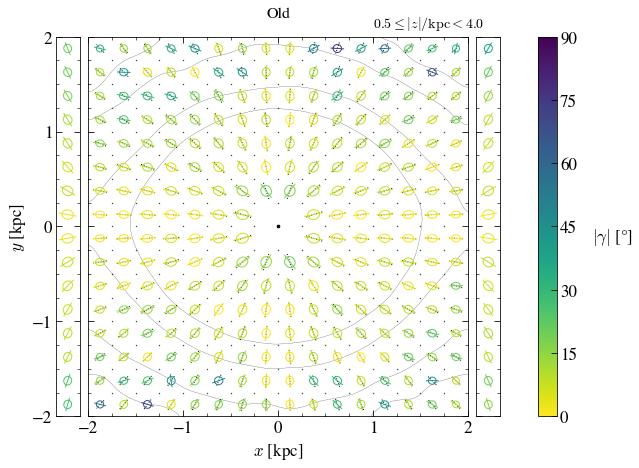

In [334]:
if True:
    fig, ax = plt.subplots()

    ax.scatter(grid[:,0],grid[:,1], marker='.',s=0.5,color='k')
    ax.scatter([0],[0],s=7,color='k')
    ax.set_ylabel(variable_symbol_dict[y_variable] + fr' [{y_units}]')
    ax.set_xlabel(variable_symbol_dict[x_variable] + fr' [{x_units}]')

    #AXES--------------------------------------------------------------------------------------------------------

    divider = make_axes_locatable(ax)
    axes_list = [ax]

    size_pad_dict = {
            2: ["7%",0.1],
            1: ["5.4%",-1.4],
        }
    size_pad = size_pad_dict[int(axis_right_bool)+int(axis_left_bool)]

    if axis_right_bool:
        ax_right = divider.append_axes("right", size=size_pad[0], pad=size_pad[1])
        axes_list.append(ax_right)

    if axis_left_bool:
        ax_left = divider.append_axes("left", size=size_pad[0], pad=size_pad[1])
        axes_list.append(ax_left)

    for axis in axes_list:
        axis.minorticks_on()
        axis.tick_params(axis='both',which='minor',direction='in',size=3)
        axis.tick_params(axis='y',which='major',direction='in',size=6)
        axis.set_aspect('equal')
        axis.set_ylim(y_min-offset,y_max+offset)
        axis.set_yticks(y_ticks)
        axis.set_yticks(minor=True,ticks=y_minor_ticks)

    ax.set_xlim(x_left_lim-offset,x_right+offset)
    ax.tick_params(axis='x',which='major',direction='in',size=6)
    ax.set_xticks(minor=True,ticks=x_minor_ticks)
    ax.set_xticks(x_ticks)

    if axis_left_bool:
        ax.set_yticklabels([])
        ax.set_ylabel('')
        ax_left.set_ylabel(variable_symbol_dict[y_variable] + fr' [{y_units}]')
        ax_left.set_xlim(-x_step/2-offset,x_step/2+offset)
        ax_left.tick_params(axis='x',which='major',direction='in',size=3)
        ax_left.set_xticks([])

    if axis_right_bool:
        ax_right.set_xlim(-x_step/2-offset,x_step/2+offset)
        ax_right.tick_params(axis='x',which='major',direction='in',size=3)
        ax_right.set_xticks([])
        ax_right.set_yticklabels([])

    #ELLIPSES--------------------------------------------------------------------------------------------------------
    norm = colors.Normalize(vmin=min_val,vmax=max_val)
    c_m = cm.viridis_r if color_coding == "abs_spherical_tilt" else cm.coolwarm
    s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
    s_m.set_array([])

    row_midpoint = nrow/2+0.5
    column_midpoint = ncol/2+0.5
    all_colorvals = []
    for row in range(nrow):
        left_columns_colorval = []
        right_columns_colorval = []
        for column in range(ncol):

            if "spherical_tilt" in color_coding:
                #Do not plot ellipses immediately surrounding the origin because the radial direction there is a bad approximation
                distance_to_row_midpoint = abs(row_midpoint - (row+1))
                if distance_to_row_midpoint == 0.5:
                    distance_to_column_midpoint = abs(column_midpoint - (column+1))
                    if distance_to_column_midpoint == 0.5:
                        continue

            central_x = xy_plot[0,row,column]
            central_y = xy_plot[1,row,column]

            std_vx = map_dict["std_vx"][age_index,row,column]
            std_vy = map_dict["std_vy"][age_index,row,column]
            covxy = map_dict["covariance"][age_index,row,column]

            if np.isnan(std_vx):
                continue

            x_ellipse, y_ellipse = get_vel_ellipse_coords(std_vx,std_vy,covxy)
            max_vector = get_max_vector(std_vx,std_vy,covxy)
            max_vector *= ellipse_factor
            vector_plot_data = np.array([[max_vector[0], -max_vector[0]],[max_vector[1], -max_vector[1]]]) 

            color_value = map_dict[color_coding][age_index,row,column]

            if "spherical_tilt" in color_coding:
                spherical_tilt_val = map_dict["spherical_tilt"][age_index,row,column]
                radial_vector = np.dot(get_rot_matrix(-spherical_tilt_val),vector_plot_data)
                ax.plot(radial_vector[0]+central_x,radial_vector[1]+central_y,lw=1,linestyle='dotted',color='k')

            ax.plot(x_ellipse+central_x, y_ellipse+central_y, lw=1,color=s_m.to_rgba(color_value))
            ax.plot(vector_plot_data[0]+central_x, vector_plot_data[1]+central_y, lw=1, color=s_m.to_rgba(color_value))

            if column < ncol/2:
                left_columns_colorval.append(color_value)
            else:
                right_columns_colorval.append(color_value)

        #PLOT RIGHT COLUMN---------------------------------------------------------------------------------
        if axis_right_bool:
            central_x = 0
            #central_y = y_range_plot[row]

            if overall_right_bool:
                right_map = xoverall_map_dict
                mean_colorval = np.mean(np.concatenate([left_columns_colorval,right_columns_colorval]))        
            else:
                right_map = xright_map_dict
                mean_colorval = np.mean(right_columns_colorval)

            std_vx = right_map["std_vx"][age_index,row]
            std_vy = right_map["std_vy"][age_index,row]
            covxy = right_map["covariance"][age_index,row]

            if np.isnan(std_vx):
                continue

            if "spherical_tilt" in color_coding:
                color_value = mean_colorval
                all_colorvals.append(color_value)
            else:
                color_value = right_map[color_coding][age_index,row]

            x_ellipse, y_ellipse = get_vel_ellipse_coords(std_vx,std_vy,covxy)
            max_vector = get_max_vector(std_vx,std_vy,covxy)
            max_vector *= ellipse_factor
            vector_plot_data = np.array([[max_vector[0], -max_vector[0]],[max_vector[1], -max_vector[1]]]) 

            ax_right.plot(x_ellipse+central_x, y_ellipse+central_y, lw=1,color=s_m.to_rgba(color_value))
            ax_right.plot(vector_plot_data[0]+central_x,vector_plot_data[1]+central_y, lw=1, color=s_m.to_rgba(color_value))

        #PLOT LEFT COLUMN---------------------------------------------------------------------------------
        if axis_left_bool:
            central_x = 0
            #central_y = y_range_plot[row]

            std_vx = xleft_map_dict["std_vx"][age_index,row]
            std_vy = xleft_map_dict["std_vy"][age_index,row]
            covxy = xleft_map_dict["covariance"][age_index,row]

            if np.isnan(std_vx):
                continue

            if "spherical_tilt" in color_coding:
                color_value = np.mean(left_columns_colorval)
                all_colorvals.append(color_value)
            else:
                color_value = xleft_map_dict[color_coding][age_index,row] 

            x_ellipse, y_ellipse = get_vel_ellipse_coords(std_vx,std_vy,covxy)
            max_vector = get_max_vector(std_vx,std_vy,covxy)
            max_vector *= ellipse_factor
            vector_plot_data = np.array([[max_vector[0], -max_vector[0]],[max_vector[1], -max_vector[1]]])

            ax_left.plot(x_ellipse+central_x, y_ellipse+central_y, lw=1,color=s_m.to_rgba(color_value))
            ax_left.plot(vector_plot_data[0]+central_x,vector_plot_data[1]+central_y, lw=1, color=s_m.to_rgba(color_value))

    #DENSITY CONTOURS ------------------------------------------------------------------------------------------
    if contours_on:
        age_limits = [[age_min,young_max],[old_min,old_max]]

        df_age = df_extra[(df_extra['age']>=age_limits[age_index][0])&(df_extra['age']<age_limits[age_index][1])]
        h,_,_ = np.histogram2d(df_age[x_variable],df_age[y_variable],bins=100,range = [[x_min,x_max],[y_min,y_max]])
        h = gaussian_filter(h,sigma=gaussian_sigma)

        contour = ax.contour(h.T, extent=extent, levels=contour_levels,colors=contour_color, linewidths=contour_lw)

    #COLORBAR--------------------------------------------------------------------------------------
    cax = divider.append_axes("right", size="5%", pad=0.5)

    flattened_map = map_dict[color_coding][age_index].flatten()
    if "spherical_tilt" in color_coding:
        flattened_map = np.append(flattened_map, all_colorvals)

    higher = np.any(flattened_map > max_val)
    lower = np.any(flattened_map < min_val)

    extend_cbar = "neither"
    if higher and lower:
        extend_cbar = "both"
    elif higher:
        extend_cbar = "max"
    elif lower:
        extend_cbar = "min"
    cbar = fig.colorbar(s_m,cax=cax, extend=extend_cbar)
    nticks_cbar = 6 if color_coding == "anisotropy" else 7
    cbar.set_ticks(np.linspace(min_val,max_val,nticks_cbar))

    cbar_label = kinematic_symbol_dict[color_coding]+kinematic_units_dict[color_coding]    
    cbar.set_label(cbar_label, rotation=0, labelpad=35)

    #------------------------------------------------------------------------------------------------

    age_title = {
        0 : "Young" if steven_cuts else r"$%i \leq \mathrm{age/Gyr} < %i$"%(age_min,young_max),
        1 : "Old" if steven_cuts else r"$%i \leq \mathrm{age/Gyr} < %i$"%(old_min,old_max),
    }
    ax.set_title(age_title[age_index],pad=20)

    extra_variable_string = '|'+extra_variable+'|' if zabs else extra_variable
    extra_variable_text = r"$%.1f\leq %s/\mathrm{%s}<%.1f$"%(extra_variable_min,extra_variable_string,extra_variable_units,extra_variable_max)
    ax.text(1,2.1,extra_variable_text,size=14)

    age_string = 'young' if age_index == 0 else 'old'

    filename = f"{color_coding}{full_range_string}_{age_string}"
    plt.savefig(save_path_ellipses+filename+'.pdf',bbox_inches='tight',dpi=300)
    print(save_path_ellipses+filename)
    plt.show()

### Double age

In [197]:
#color other vel

# color_othervel_bool = True
color_othervel_bool = False

if color_othervel_bool: # explanation and steps
    
    map_dict_othervel = copy.copy(map_dict)
    kinematic_symbol_dict_othervel = copy.copy(kinematic_symbol_dict)

    othervel_cylindrical = True
    
    '''
    The ellipses code only works when the spatial and velocity dimensions match:
    xy -> vxvy
    lb -> vlvb
    Rphi -> vRv\phi

    What if you want to color the ellipses with quantities computed from velocities different to the spatial correspondents?

    1. Obtain the map_dict with the velocities you want, and save it as a variable (map_dict_othervel)
    2. Obtain a new map_dict now for velocities that match the spatial representation you want

    If the velocity used is cylindrical and you want to show the extra column with overall ellipses, set othervel_cylindrical=True 
    to indicate that it requires computing the mean value across the row, as opposed to taking all the velocities and computing the overall quantity from them.
    This is because the radial vector is not well-defined for the whole row and changes a lot from bin to bin.
    In fact, from the above we conclude that using the cylindrical coordinates we should directly avoid using the overall column because 
    if it has to be averaged out then it is probably not useful observationally.
    
    NOTE: make sure not to run this cell again once you save the new map dict, otherwise you'll overwrite it!
    I suggest you set it to markdown mode once you save the other map dict.
    '''

In [431]:
color_coding_list = ['spherical_tilt_abs']

# color_coding_list = ['tilt','tilt_abs','correlation','anisotropy','mean_vx','mean_vy','std_vx','std_vy']

# color_coding_list = ['abs_spherical_tilt','tilt','tilt_abs','correlation','anisotropy','mean_vx','mean_vy','std_vx','std_vy']
# if vel_x_variable+vel_y_variable != 'R\phi':
#     color_coding_list.append('spherical_tilt')

if "spherical_tilt_abs" in color_coding_list:
    map_dict["spherical_tilt_abs"] = copy.copy(map_dict["spherical_tilt"])
    values_to_modify = map_dict["spherical_tilt_abs"][np.abs(map_dict["spherical_tilt_abs"])>45]
    map_dict["spherical_tilt_abs"][np.abs(map_dict["spherical_tilt_abs"])>45] = np.sign(values_to_modify)*(90 - np.abs(values_to_modify))\
    
    kinematic_symbol_dict["spherical_tilt_abs"] = copy.copy(kinematic_symbol_dict["spherical_tilt"])
    kinematic_units_dict["spherical_tilt_abs"] = copy.copy(kinematic_units_dict["spherical_tilt"])
    
if True: #For quantities involving R_hat, do not plot ellipses closest to the origin because the radial direction changes direction too drastically across the bin
    cyl_bool = (color_othervel_bool and othervel_cylindrical) or vel_x_variable+vel_y_variable == 'R\phi'
    if cyl_bool or "spherical_tilt" in color_coding: 
        skip_central_ellipses = True
    else: 
        skip_central_ellipses = False
        
# skip_central_ellipses = True
skip_central_ellipses = False

if skip_central_ellipses: print("Skipping central ellipses")

In [424]:
plot_radii = True
# plot_radii = False

# predefined_cbar_lims = True
predefined_cbar_lims = False

In [371]:
def get_ellipse_gridspec_params(variables):
    if variables == "xy":
        fig_size = 15
        fig_aspect_ratio = 2.05
        central_space = 0.02
        cbar_width = 0.05
    if variables == "yz":
        fig_size = 12
        fig_aspect_ratio = 3.03
        central_space = 0.02
        cbar_width = 0.05
    elif variables == "lb":
        fig_size = 12
        fig_aspect_ratio = 2.7
        central_space = 0.03
        cbar_width = 0.05
    return fig_size, fig_aspect_ratio, central_space, cbar_width

In [429]:
# aspect_equal = True
aspect_equal = False

save_bool = True
# save_bool = False

graphs/standard_100_min/708main/xy_map/-3x3_-3y3/steps_0.3x_0.3y/0.5z3/rot_angle_27/young_and_old/4-7_9.5-10/vxvy/ellipses/single/xy_ellipse_0.5z3_spherical_tilt_abs
Saved as .pdf
Saved as .png


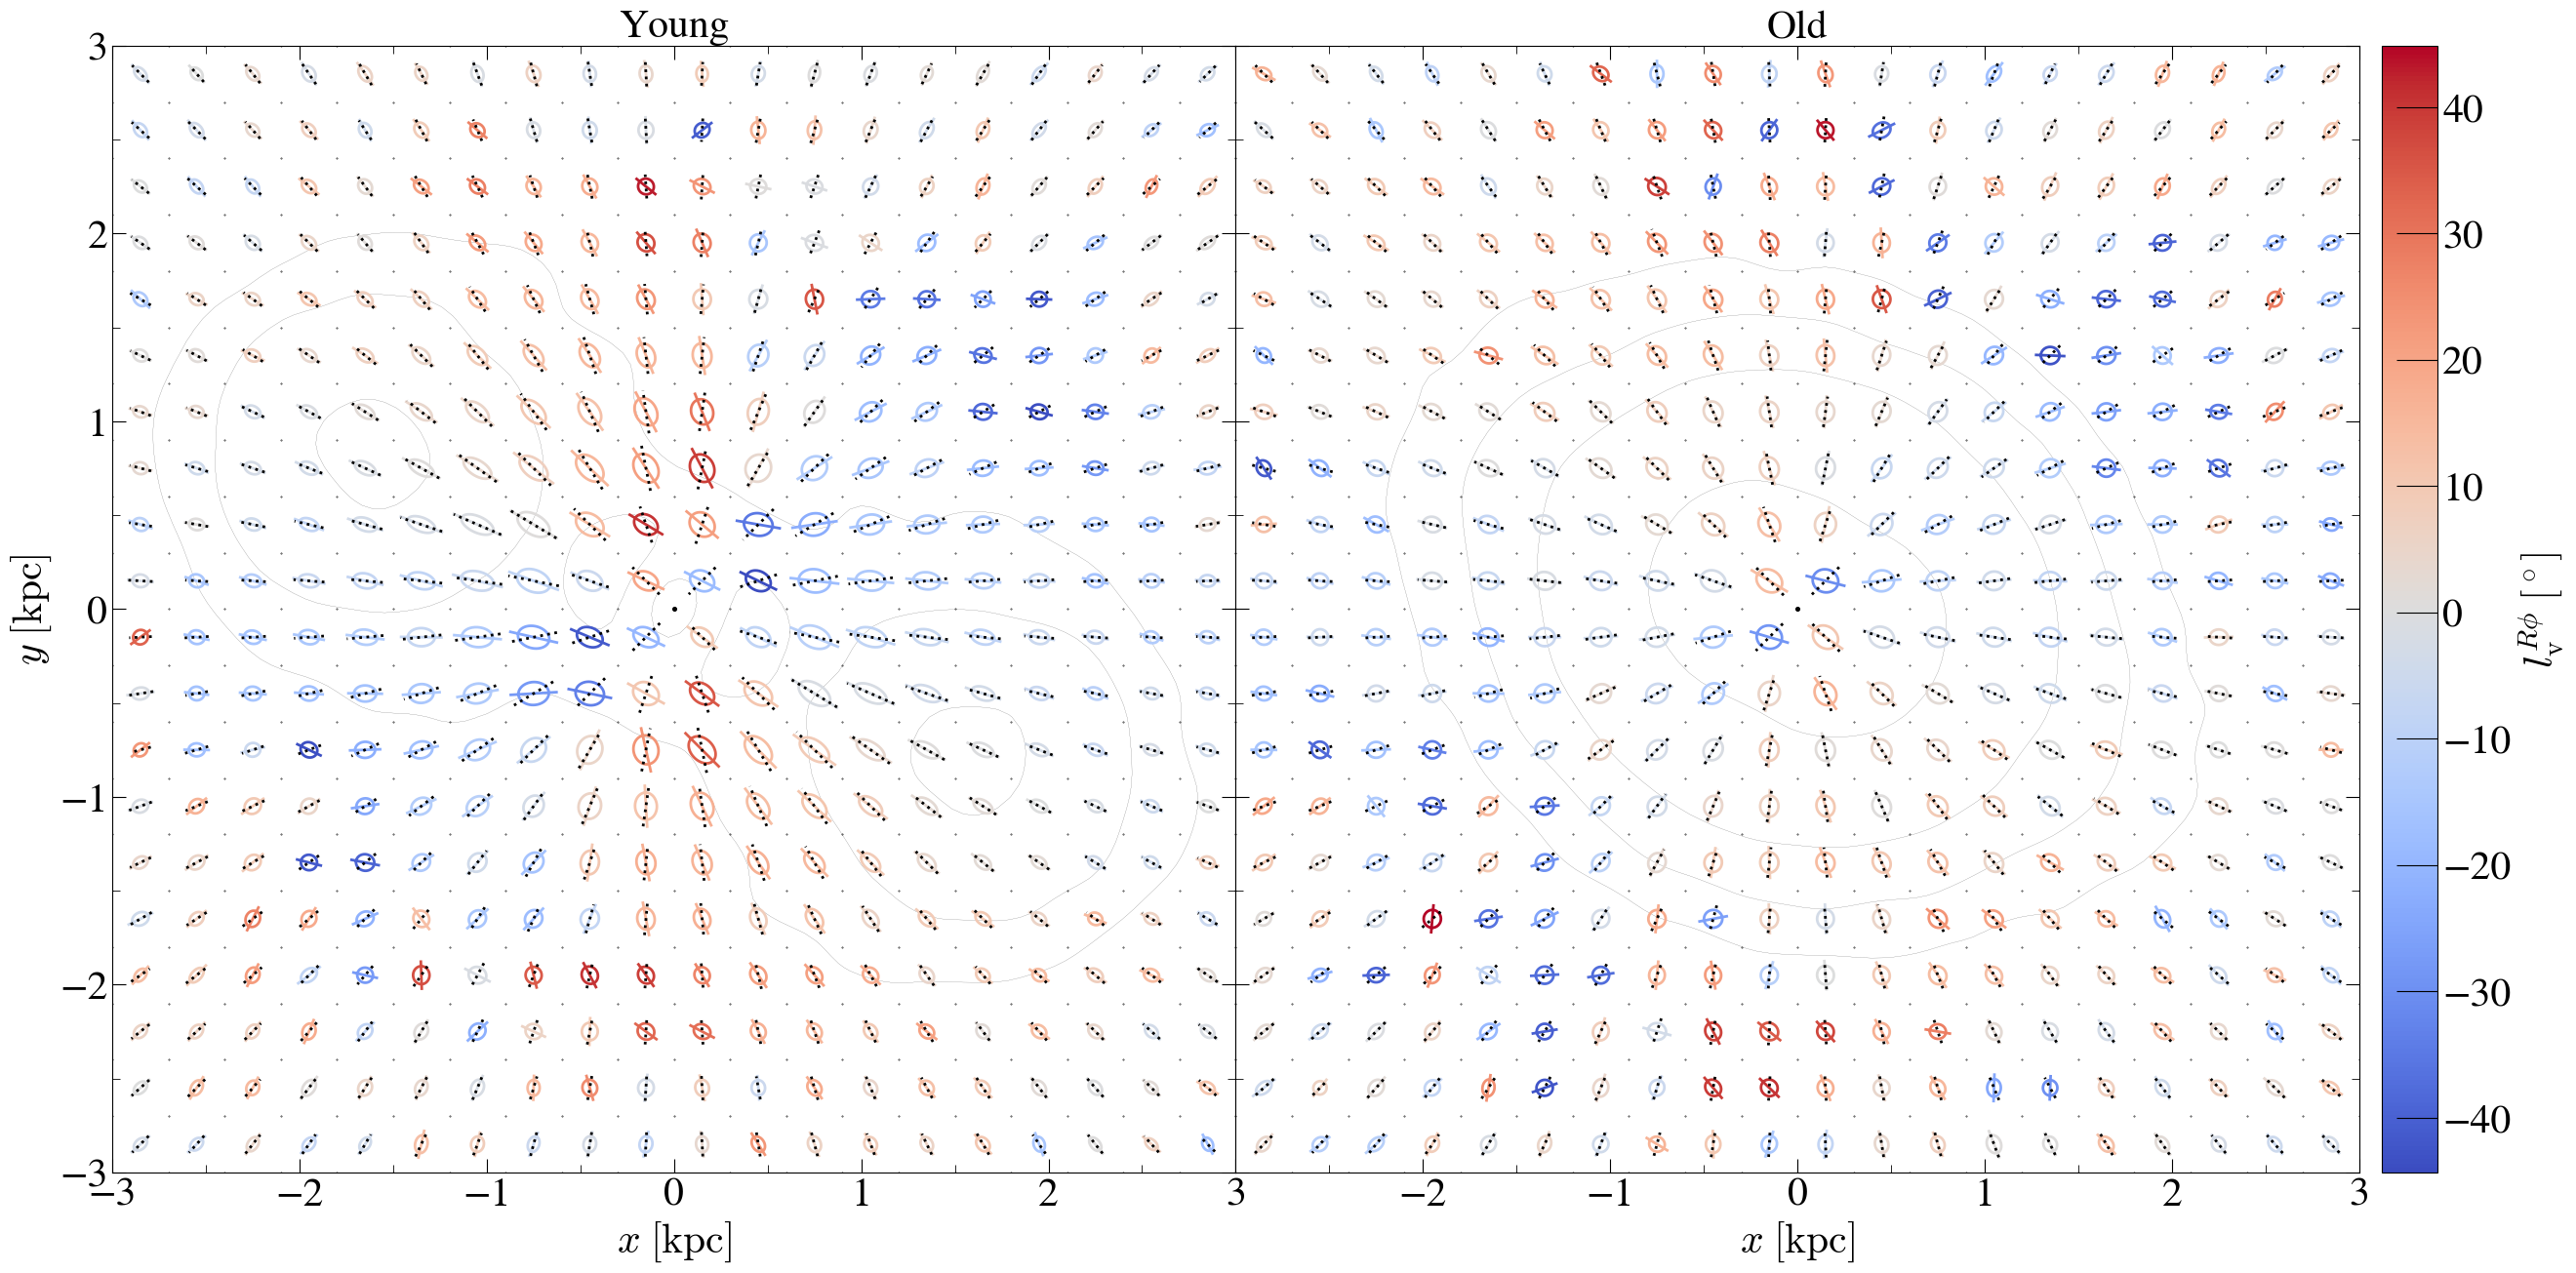

In [433]:
# plot
ellipse_map_dict = o_map_dict if data_bool else map_dict
color_map_dict = map_dict_othervel if color_othervel_bool else ellipse_map_dict

if overall_right_bool:
    ellipse_xoverall_map_dict = xoverall_map_dict
    xoverall_color_map_dict = xoverall_map_dict_othervel if color_othervel_bool else xoverall_map_dict

ellipse_x_step = o_x_step if data_bool else x_step
ellipse_y_step = o_y_step if data_bool else y_step

for color_coding in color_coding_list:
    
    fig_size, fig_aspect_ratio, central_space, cbar_width = get_ellipse_gridspec_params(x_variable+y_variable)

    grid_spec = gridspec.GridSpec(1,4,width_ratios=[1, 1, central_space, cbar_width], hspace=0,wspace=0)

    fig = plt.figure(figsize=(fig_aspect_ratio*fig_size,fig_size))
    axs = [fig.add_subplot(grid_spec[0,col]) for col in range(2)]
    cax = fig.add_subplot(grid_spec[0,3])
    
    min_val, max_val = get_map_limits(color_coding,color_map_dict,raw=not predefined_cbar_lims)
    
    all_colorvals_population = []
    for popu_index, ax in enumerate(axs):

        ax.set_title(titles[popu_index])#,pad=20)

        ax.scatter(grid[:,0],grid[:,1], marker='.',s=0.5,color='k')
        ax.scatter([0],[0],s=7,color='k')

        if True: #axes 
                
            divider = make_axes_locatable(ax)
            axes_list = [ax]

            if axis_right_bool or axis_left_bool:
                size_pad_dict = {
                        2: ["7%",0.1],
                        1: ["5.4%",-1.4],
                    }
                size_pad = size_pad_dict[int(axis_right_bool)+int(axis_left_bool)]

            if axis_right_bool:
                ax_right = divider.append_axes("right", size=size_pad[0], pad=size_pad[1])
                axes_list.append(ax_right)

            if axis_left_bool:
                ax_left = divider.append_axes("left", size=size_pad[0], pad=size_pad[1])
                axes_list.append(ax_left)
            
            if True: #old parameters
#                 for axis in axes_list:
#                     axis.minorticks_on()
#                     axis.tick_params(axis='both',which='minor',direction='in',size=3)
#                     axis.tick_params(axis='y',which='major',direction='in',size=6)
#                     #axis.set_aspect('equal')
#                     axis.set_yticks(y_ticks)
#                     axis.set_yticks(minor=True,ticks=y_minor_ticks)
#                     axis.set_ylim(y_min-offset,y_max+offset)

#                 ax.set_xlim(x_left-offset,x_right+offset)
#                 ax.tick_params(axis='x',which='major',direction='in',size=6)
#                 ax.set_xticks(minor=True,ticks=x_minor_ticks)
#                 ax.set_xticks(x_ticks)
                pass
            
            for axis in axes_list: # mainly yaxis
                if aspect_equal:
                    axis.set_aspect("equal")
                
                axis.yaxis.set_minor_locator(ticker.MultipleLocator(y_minor_locator))
                #ax.minorticks_off()
                axis.tick_params(which='major',size=major_ticksize)
                axis.tick_params(which='minor',size=minor_ticksize)
                
                axis.set_yticks(y_ticks)
                axis.set_ylim(y_min,y_max)
            
            # xaxis
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(x_minor_locator))
            ax.set_xlim(x_left,x_right)
            
            if x_variable+y_variable == 'xy' and popu_index == 1:
                ax.set_xticks(x_ticks[1:])
            else:
                ax.set_xticks(x_ticks)
            
            ax.set_xlabel(variable_symbol_dict[x_variable] + r' $[\mathrm{%s}]$'%x_units) if ax.get_subplotspec().is_last_row() else ax.set_xticklabels([])
            ax.set_ylabel(variable_symbol_dict[y_variable] + r' $[\mathrm{%s}]$'%y_units) if ax.get_subplotspec().is_first_col() else ax.set_yticklabels([])

            if axis_left_bool:
                ax.set_yticklabels([])
                ax.set_ylabel('')
                ax_left.set_ylabel(variable_symbol_dict[y_variable] + fr' [{y_units}]' if popu_index == 0 else '')
                ax_left.set_xlim(-ellipse_x_step/2-offset,ellipse_x_step/2+offset)
                ax_left.tick_params(axis='x',which='major',direction='in',size=3)
                ax_left.set_xticks([])

            if axis_right_bool:
                ax_right.set_xlim(-ellipse_x_step/2-offset,ellipse_x_step/2+offset)
                ax_right.tick_params(axis='x',which='major',direction='in',size=3)
                ax_right.set_xticks([])
                ax_right.set_yticklabels([])

            if popu_index == 1:
                ax.set_ylabel('')

        if density_contours_on: # density contours
            if data_bool:
                df_popu = df_metals[popu_index]
            
                h,_,_ = np.histogram2d(df_popu[x_variable],df_popu[y_variable],bins=100,range = [[x_min,x_max],[y_min,y_max]])
                h = gaussian_filter(h,sigma=gaussian_sigma)

                levels = 2 if data_bool else contour_levels
                contour = ax.contour(h.T, extent=extent, levels=levels,colors=density_contour_color, linewidths=density_contour_lw)
            else:
                ax.contour(count_list[popu_index]/(stellar_mass if mass_density_bool else 1), extent=extent,colors=density_contour_color,levels=density_contour_levels,linewidths=density_contour_lw)
                
        if True: # ellipses
            norm = mplcolors.Normalize(vmin=min_val,vmax=max_val)
            c_m = cm.coolwarm#cm.viridis_r if color_coding not in divergent_map_list else cm.coolwarm
            s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
            s_m.set_array([])

            row_midpoint = nrow/2+0.5
            column_midpoint = ncol/2+0.5
            all_colorvals = []

            for row in range(nrow):
                left_columns_colorval = []
                right_columns_colorval = []

                for column in range(ncol):
                    if skip_central_ellipses:
                        distance_to_row_midpoint = abs(row_midpoint - (row+1))
                        if distance_to_row_midpoint == 0.5:
                            distance_to_column_midpoint = abs(column_midpoint - (column+1))
                            if distance_to_column_midpoint == 0.5:
                                continue

                    central_x = xy_plot[0,row,column]
                    central_y = xy_plot[1,row,column]
                    
                    std_vx = ellipse_map_dict["std_vx"][popu_index,row,column]
                    std_vy = ellipse_map_dict["std_vy"][popu_index,row,column]
                    covxy = ellipse_map_dict["correlation"][popu_index,row,column]*std_vx*std_vy

                    if np.isnan(std_vx): continue
                    
                    x_ellipse, y_ellipse = EF.get_vel_ellipse_coords(std_vx*std_vx,std_vy*std_vy,covxy,ellipse_factor)
                    max_vector = EF.get_max_vector_from_moments(std_vx*std_vx,std_vy*std_vy,covxy)

                    if vel_x_variable == "M":
                        x_ellipse,y_ellipse = np.dot(MF.get_rot_matrix(-rot_angle),[x_ellipse,y_ellipse])
                        max_vector = np.dot(MF.get_rot_matrix(-rot_angle),max_vector)

                    max_vector *= ellipse_factor
                    vector_plot_data = np.array([[max_vector[0], -max_vector[0]],[max_vector[1], -max_vector[1]]])

                    color_value = color_map_dict[color_coding][popu_index,row,column]

                    ax.plot(x_ellipse+central_x, y_ellipse+central_y, lw=ellipses_lw,color=s_m.to_rgba(color_value))
                    ax.plot(vector_plot_data[0]+central_x, vector_plot_data[1]+central_y, lw=ellipses_lw, color=s_m.to_rgba(color_value))

                    if column < ncol/2:
                        left_columns_colorval.append(color_value)
                    else:
                        right_columns_colorval.append(color_value)
                        
                    if plot_radii:
                        spherical_tilt_val = ellipse_map_dict["spherical_tilt"][popu_index,row,column]
                        radial_vector = np.dot(MF.get_rot_matrix(-spherical_tilt_val),vector_plot_data)
                        ax.plot(radial_vector[0]+central_x,radial_vector[1]+central_y,lw=ellipses_lw,linestyle='dotted',color='k')

                if axis_right_bool: #axis right
                    central_x = 0
                    #central_y = y_range_plot[row]

                    if overall_right_bool:
                        ellipse_right_map = ellipse_xoverall_map_dict
                        mean_colorval = np.mean(np.concatenate([left_columns_colorval,right_columns_colorval]))        
                    else:
                        ellipse_right_map = ellipse_xright_map_dict
                        mean_colorval = np.mean(right_columns_colorval)

                    std_vx = ellipse_right_map["std_vx"][popu_index,row]
                    std_vy = ellipse_right_map["std_vy"][popu_index,row]
                    covxy = ellipse_right_map["correlation"][popu_index,row]*std_vx*std_vy

                    if np.isnan(std_vx): continue

                    if "spherical_tilt" in color_coding or othervel_cylindrical:
                        color_value = mean_colorval
                        all_colorvals.append(color_value)
                    else:
                        color_value = xoverall_color_map_dict[color_coding][popu_index,row]

                    x_ellipse, y_ellipse = EF.get_vel_ellipse_coords(std_vx,std_vy,covxy)
                    max_vector = EF.get_max_vector_from_moments(std_vx,std_vy,covxy)
                    max_vector *= ellipse_factor
                    vector_plot_data = np.array([[max_vector[0], -max_vector[0]],[max_vector[1], -max_vector[1]]]) 

                    ax_right.plot(x_ellipse+central_x, y_ellipse+central_y, lw=ellipses_lw,color=s_m.to_rgba(color_value))
                    ax_right.plot(vector_plot_data[0]+central_x,vector_plot_data[1]+central_y, lw=ellipses_lw, color=s_m.to_rgba(color_value))
                if axis_left_bool: #axis left
                    central_x = 0
                    #central_y = y_range_plot[row]

                    std_vx = ellipse_xleft_map_dict["std_vx"][popu_index,row]
                    std_vy = ellipse_xleft_map_dict["std_vy"][popu_index,row]
                    covxy = ellipse_xleft_map_dict["correlation"][popu_index,row]*std_vx*std_vy

                    if np.isnan(std_vx): continue

                    if "spherical_tilt" in color_coding:
                        color_value = np.mean(left_columns_colorval)
                        all_colorvals.append(color_value)
                    else:
                        color_value = ellipse_xleft_map_dict[color_coding][popu_index,row] 

                    x_ellipse, y_ellipse = EF.get_vel_ellipse_coords(std_vx,std_vy,covxy)
                    max_vector = EF.get_max_vector_from_moments(std_vx,std_vy,covxy)
                    max_vector *= ellipse_factor
                    vector_plot_data = np.array([[max_vector[0], -max_vector[0]],[max_vector[1], -max_vector[1]]])

                    ax_left.plot(x_ellipse+central_x, y_ellipse+central_y, lw=ellipses_lw,color=s_m.to_rgba(color_value))
                    ax_left.plot(vector_plot_data[0]+central_x,vector_plot_data[1]+central_y, lw=ellipses_lw, color=s_m.to_rgba(color_value))

        all_colorvals_population.append(all_colorvals)

    if True: #COLORBAR
        
        cax.tick_params(direction="in", length=cbar_ticklength)
        
        flattened_map = ellipse_map_dict[color_coding].flatten()
#         if "spherical_tilt" in color_coding:
#             flattened_map = np.append(flattened_map, np.concatenate(all_colorvals_population))

        higher = np.any(flattened_map > max_val)
        lower = np.any(flattened_map < min_val)

        if higher and lower: extend_cbar = "both"
        elif higher: extend_cbar = "max"
        elif lower: extend_cbar = "min"
        else: extend_cbar = "neither"
        
        cbar = fig.colorbar(s_m,cax=cax,extend=extend_cbar)
        
        cbar.ax.minorticks_off()
        
        if True: # choose ticks
            if color_coding in ["spherical_tilt","tilt","vertex","abs_spherical_tilt"]:
                nticks_cbar = 7
                cbar.set_ticks(np.round(np.linspace(min_val,max_val,nticks_cbar),2))
                
                if color_coding == "abs_spherical_tilt":
                    cbar.ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
            elif predefined_cbar_lims and color_coding in ["tilt_abs","vertex_abs","spherical_tilt_abs"]:
                cbar.set_ticks([-45,-30,-15,0,15,30,45])
            elif color_coding in ["correlation","anisotropy"]:
                nticks_cbar = 5
                cbar.set_ticks(np.round(np.linspace(min_val,max_val,nticks_cbar),2))
                
            if color_coding == 'mean_vx':
                cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

        tick_color = 'w' if c_m == cm.viridis_r else 'k'
        cbar.ax.tick_params(which='both',color=tick_color)
        
        #cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter(r'$%0.1f$'))
        
        if color_othervel_bool:
            cbar_label = kinematic_symbol_dict_othervel[color_coding]+kinematic_units_dict[color_coding]
        else:
            cbar_label = kinematic_symbol_dict[color_coding]+kinematic_units_dict[color_coding]
            
        cbar.set_label(cbar_label)

    if True: # extra variable text 

#         extra_variable_string = '|'+extra_variable+'|' if zabs else extra_variable
#         if extra_variable_units in ['^\circ',degree_symbol]: extra_variable_units = 'deg'
#         extra_variable_text = r"$%.1f\leq %s/\mathrm{%s}<%.1f$"%(extra_variable_min,extra_variable_string,extra_variable_units,extra_variable_max)
#         axs[-1].text(x=0.98,y=-0.11,s=extra_variable_text,size=12,transform=axs[-1].transAxes)

#         xtext_offset = np.diff(x_ticks)[0]/2
#         xtext = x_right + xtext_offset if x_variable == 'l' else x_right - xtext_offset
#         ytext = y_min - 1.6*np.diff(y_ticks)[0]
#         if x_variable+y_variable == 'lb' and zabs:
#             xtext += 0
#             ytext += 0.6
#         elif x_variable+y_variable=='xy':
#             ytext += 0.3

#         extra_variable_text = get_variable_string(variable = extra_variable, units = extra_variable_units, vmin = extra_variable_min, vmax = extra_variable_max)
#         ax.text(x=xtext,y=ytext,s=extra_variable_text,size=extra_text_size,bbox=dict(boxstyle="square",fc='white',lw=0.03))#, mutation_aspect=0.7))
        pass
    
    if True: # show and save
        radii_str = "_noRadii" if not plot_radii else ""
        cbar_lims_str = "_predefinedLims" if predefined_cbar_lims and (min_val,max_val) != get_map_limits(color_coding,color_map_dict,raw=True) else ""
        skip_central_ellipses_str = "_skipCentral" if skip_central_ellipses else ""
        
        filename = f"{x_variable+y_variable}_ellipse_{extra_variable_min}{extra_variable}{extra_variable_max}_{color_coding}{cbar_lims_str}{radii_str}{skip_central_ellipses_str}"

        print(save_path_ellipses+filename)
        if save_bool:
            for fileformat in [".pdf",".png"]:
                plt.savefig(save_path_ellipses+filename+fileformat,bbox_inches='tight',dpi=300)
                print("Saved as",fileformat)
        
        plt.close() if save_bool and len(color_coding_list) > 1 else plt.show()

# Spherical tilt

## xy

In [177]:
single_variable = 'vertex'

single_map = copy.copy(map_dict[single_variable])
single_map_errors = copy.copy(map_dict[single_variable+'_error'])

Code for custom color
#min_val, max_val = get_map_limits(map_array=single_map[:,fixed_y_row,:],map_string=single_variable,norm_index=slice(0,len(single_map[:,fixed_y_row,:])))

#max_val = np.max(np.abs([np.min(single_data),np.max(single_data)]))
#min_val = -max_val
#norm = colors.Normalize(vmin=min_val,vmax=max_val)
#c_m = cm.viridis_r if single_variable == "abs_spherical_tilt" else cm.coolwarm
#s_m = cm.ScalarMappable(cmap=c_m, norm=norm)
#s_m.set_array([])


#ax.scatter(x_range+x_step/2,phi_data+misalignment_data,marker='d',color='red')
#fmt = 'd' if age_index == 0 else '+'
#for i in range(len(x_range)):
#ax.errorbar(x_range[i]+x_step/2,phi_data[i]+single_data[i],yerr=single_errors[i],fmt=fmt,color=s_m.to_rgba(single_data[i]))

In [178]:
fixed_y_row = 6
print(y_range)
fixed_y_lowlim = y_range[fixed_y_row]
print(f"Choosing {y_variable} values in the range [{fixed_y_lowlim},{fixed_y_lowlim+y_step})")

[-15 -12  -9  -6  -3   0   3   6   9  12]
Choosing l values in the range [3,6)


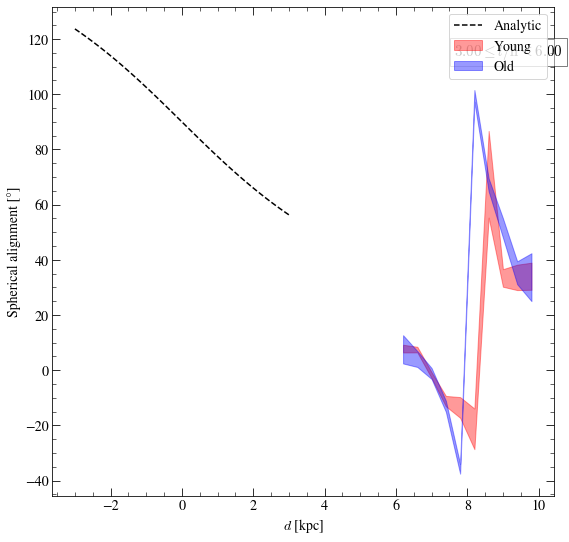

In [179]:
fig, ax = plt.subplots()

x_analytic = np.arange(-3,3+0.1,0.1)
phi_analytic = np.degrees(np.arctan2(fixed_y_lowlim + y_step/2,x_analytic))
ax.plot(x_analytic,phi_analytic,'k--',label='Analytic')

phi_data = np.degrees(np.arctan2(fixed_y_lowlim+y_step/2,x_range+x_step/2))
    
for age_index in [0,1]:
    single_data = single_map[age_index, fixed_y_row, :]
    single_errors = single_map_errors[age_index, fixed_y_row, :]
    color = 'red' if age_index == 0 else 'blue'
    label = 'Young' if age_index == 0 else 'Old'
    ax.fill_between(x_range+x_step/2,phi_data+single_data-single_errors,phi_data+single_data+single_errors,color=color,alpha=0.4,label=label)
    #ax.scatter(x_range+x_step/2,phi_data+single_data,marker='d',s=100,color=color,label=label,alpha=1)
    #ax.errorbar(x_range+x_step/2,phi_data+single_data,yerr=single_errors,fmt='d',color=color,label=label,alpha=0.4)

ax.set_xlabel(variable_symbol_dict[x_variable] + fr' [{x_units}]')
ax.set_ylabel("Spherical alignment [%s]"%degree_symbol)

plt.legend(loc='best')

fixed_variable_string = r"$%.2f\leq %s/\mathrm{%s}<%.2f$"%(fixed_y_lowlim,y_variable,y_units,fixed_y_lowlim+y_step)
str_pos = [0.8,0.9] if fixed_y_lowlim > 0 else [0.65,0.07]
ax.text(x=str_pos[0],y=str_pos[1],s=fixed_variable_string, bbox=dict(facecolor='white', alpha=0.5), fontsize=15, transform = ax.transAxes)
#plt.savefig(save_path+f"{x_variable+y_variable}_spherical_tilt_analytic.pdf")
plt.show()

### three

In [180]:
y_range

array([-15, -12,  -9,  -6,  -3,   0,   3,   6,   9,  12])

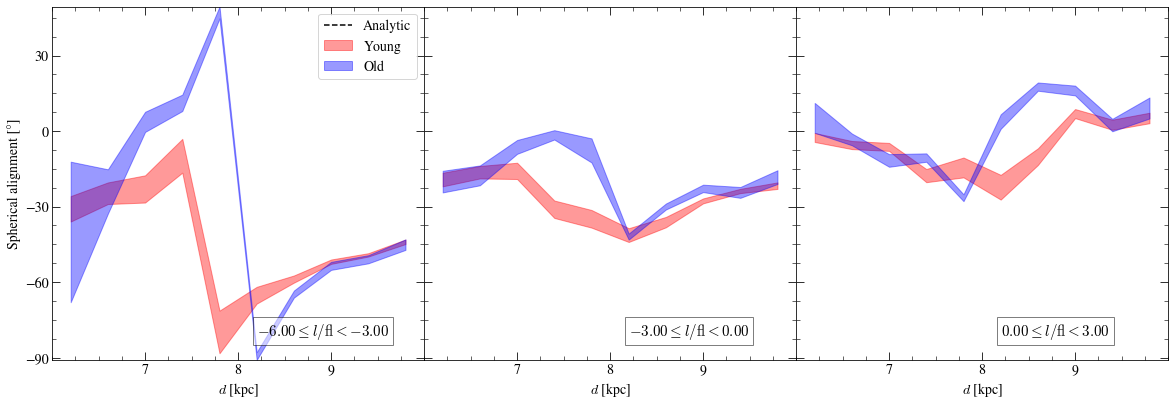

In [181]:
fig, axs = plt.subplots(ncols=3,gridspec_kw={'wspace':0},figsize=(20,6.5))

x_analytic = np.arange(-3,3+0.1,0.1)

row_list = [3,4,5]#[8,9,10]#[4,5,6]
y_lim_min, y_lim_max = 0, 0
for fixed_y_row in row_list:
    phi_data = np.degrees(np.arctan2(y_range[fixed_y_row]+y_step/2,x_range+x_step/2))
    minimum = np.nanmin(phi_data + single_map[:, fixed_y_row, :]-single_map_errors[:, fixed_y_row, :])
    maximum = np.nanmax(phi_data + single_map[:, fixed_y_row, :]+single_map_errors[:, fixed_y_row, :])
    if minimum < y_lim_min:
        y_lim_min = minimum
    if maximum > y_lim_max:
        y_lim_max = maximum

for ax, fixed_y_row in zip(axs, row_list):
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_lim_min,y_lim_max)
    #ax.set_xticks(np.linspace(x_min,x_max,5))
    #ax.set_xticks(np.linspace(x_min,x_max,5*4), which='minor')
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticks(x_ticks)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1/4))
    
    fixed_y_lowlim = y_range[fixed_y_row]

    phi_analytic = np.degrees(np.arctan2(fixed_y_lowlim + y_step/2,x_analytic))
    ax.plot(x_analytic,phi_analytic,'k--',label='Analytic')

    phi_data = np.degrees(np.arctan2(fixed_y_lowlim+y_step/2,x_range+x_step/2))

    for age_index in [0,1]:
        single_data = single_map[age_index, fixed_y_row, :]
        single_errors = single_map_errors[age_index, fixed_y_row, :]
        color = 'red' if age_index == 0 else 'blue'
        label = 'Young' if age_index == 0 else 'Old'
        ax.fill_between(x_range+x_step/2,phi_data+single_data-single_errors,phi_data+single_data+single_errors,color=color,alpha=0.4,label=label)
        #ax.scatter(x_range+x_step/2,phi_data+single_data,marker='d',s=50,color=color,alpha=0.7)#,label=label)
        #ax.errorbar(x_range+x_step/2,phi_data+single_data,yerr=single_errors,fmt='d',color=color,label=label,alpha=0.4)

    ax.set_xlabel(variable_symbol_dict[x_variable] + fr' [{x_units}]')

    if ax.is_first_col():
        ax.set_ylabel("Spherical alignment [%s]"%degree_symbol)
        ax.legend(loc='best')
    else:
        ax.set_yticklabels([])

    fixed_variable_string = r"$%.2f\leq %s/\mathrm{%s}<%.2f$"%(fixed_y_lowlim,y_variable,y_units,fixed_y_lowlim+y_step)
    str_pos = [0.8,0.9] if fixed_y_lowlim > 0 else [0.55,0.07]
    ax.text(x=str_pos[0],y=str_pos[1],s=fixed_variable_string, bbox=dict(facecolor='white', alpha=0.5), fontsize=15, transform = ax.transAxes)
    
    #ax.set_xlim(-2,2)
#plt.savefig(save_path+f"{x_variable+y_variable}_spherical_tilt_analytic.pdf",bbox_inches='tight')
plt.show()

## dl

In [200]:
single_variable = 'vertex_abs'

single_map = copy.copy(map_dict[single_variable])
single_map_errors = copy.copy(map_dict[single_variable+'_error'])

In [201]:
y_range

array([-15, -12,  -9,  -6,  -3,   0,   3,   6,   9,  12])

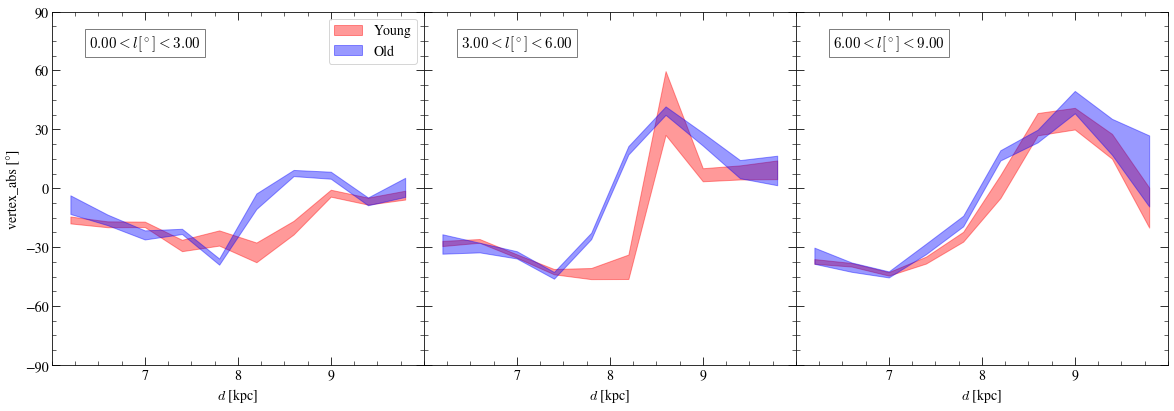

In [202]:
fig, axs = plt.subplots(ncols=3,gridspec_kw={'wspace':0},figsize=(20,6.5))

row_list = [5,6,7]#[8,9,10]#[4,5,6]


#y_lim_min = np.nanmin([np.abs(single_map[:, row_list, :]-single_map_errors[:, row_list, :]), single_map[:, row_list, :]+single_map_errors[:, row_list, :]])

for ax, fixed_y_row in zip(axs, row_list):
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(-90,90)
    #ax.set_ylim(y_lim_min,y_lim_max)
    #ax.set_xticks(np.linspace(x_min,x_max,5))
    #ax.set_xticks(np.linspace(x_min,x_max,5*4), which='minor')
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticks(x_ticks)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1/4))
    
    fixed_y_lowlim = y_range[fixed_y_row]

    for age_index in [0,1]:
        single_data = single_map[age_index, fixed_y_row, :]
        single_errors = single_map_errors[age_index, fixed_y_row, :]
        color = 'red' if age_index == 0 else 'blue'
        label = 'Young' if age_index == 0 else 'Old'
        ax.fill_between(x_range+x_step/2,single_data-single_errors,single_data+single_errors,color=color,alpha=0.4,label=label)
        #ax.scatter(x_range+x_step/2,phi_data+single_data,marker='d',s=50,color=color,alpha=0.7)#,label=label)
        #ax.errorbar(x_range+x_step/2,phi_data+single_data,yerr=single_errors,fmt='d',color=color,label=label,alpha=0.4)

    ax.set_xlabel(variable_symbol_dict[x_variable] + fr' [{x_units}]')

    if ax.is_first_col():
        ax.set_ylabel(single_variable + kinematic_units_dict[single_variable])
        ax.legend(loc='best')
    else:
        ax.set_yticklabels([])
    
    if y_units == degree_symbol:
        unit_string = '^\circ'
        
    fixed_variable_string = r"$%.2f < %s [\mathrm{%s}] <%.2f$"%(fixed_y_lowlim,y_variable,unit_string,fixed_y_lowlim+y_step)
    str_pos = [0.1,0.9] if fixed_y_lowlim >= 0 else [0.55,0.07]
    ax.text(x=str_pos[0],y=str_pos[1],s=fixed_variable_string, bbox=dict(facecolor='white', alpha=0.5), fontsize=15, transform = ax.transAxes)
    
    #ax.set_xlim(-2,2)
plt.savefig(save_path+f"{x_variable+y_variable}_{single_variable}.pdf",bbox_inches='tight')
plt.show()

## lb

In [72]:
single_variable = 'abs_spherical_tilt'

single_map = copy.copy(map_dict[single_variable])
single_map_errors = copy.copy(map_dict[single_variable+'_error'])

In [73]:
y_range

array([-15.   , -13.125, -11.25 ,  -9.375,  -7.5  ,  -5.625,  -3.75 ,
        -1.875,   0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,
        11.25 ,  13.125])

[3, 4, 5, 6]


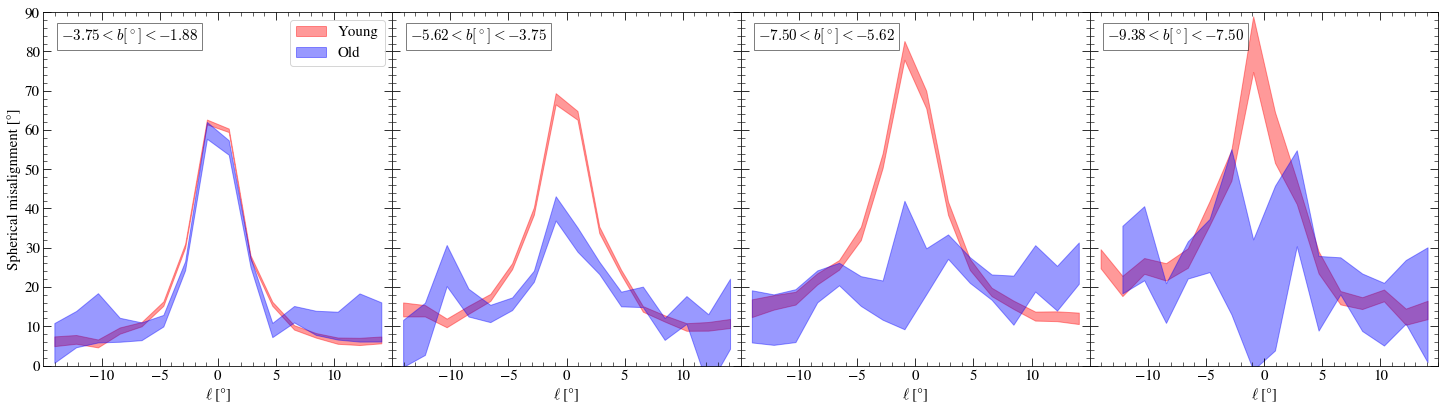

In [106]:
fig, axs = plt.subplots(ncols=5,gridspec_kw={'wspace':0},figsize=(25,6.5))

y_list = [-11.25, -9.375,  -7.5  ,  -5.625,  -3.75]
row_list = []
for y in y_list:
    row_list.append(np.where(y_range == y)[0][0])
print(row_list)


#y_lim_min = np.nanmin([np.abs(single_map[:, row_list, :]-single_map_errors[:, row_list, :]), single_map[:, row_list, :]+single_map_errors[:, row_list, :]])

for ax, fixed_y_row in zip(axs[::-1], row_list):
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(0,90)
    #ax.set_ylim(y_lim_min,y_lim_max)
    #ax.set_xticks(np.linspace(x_min,x_max,5))
    #ax.set_xticks(np.linspace(x_min,x_max,5*4), which='minor')
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticks(x_ticks)
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
    #ax.xaxis.set_minor_locator(ticker.MultipleLocator(1/4))
    
    fixed_y_lowlim = y_range[fixed_y_row]

    for age_index in [0,1]:
        single_data = single_map[age_index, fixed_y_row, :]
        single_errors = single_map_errors[age_index, fixed_y_row, :]
        color = 'red' if age_index == 0 else 'blue'
        label = 'Young' if age_index == 0 else 'Old'
        ax.fill_between(x_range+x_step/2,single_data-single_errors,single_data+single_errors,color=color,alpha=0.4,label=label)
        #ax.scatter(x_range+x_step/2,phi_data+single_data,marker='d',s=50,color=color,alpha=0.7)#,label=label)
        #ax.errorbar(x_range+x_step/2,phi_data+single_data,yerr=single_errors,fmt='d',color=color,label=label,alpha=0.4)

    ax.set_xlabel(variable_symbol_dict[x_variable] + fr' [{x_units}]')

    if ax.is_first_col():
        ax.set_ylabel("Spherical misalignment" + kinematic_units_dict[single_variable])
        ax.legend(loc='best')
    else:
        ax.set_yticklabels([])
    
    if y_units == degree_symbol:
        unit_string = '^\circ'
        
    fixed_variable_string = r"$%.2f < %s [\mathrm{%s}] <%.2f$"%(fixed_y_lowlim,y_variable,unit_string,fixed_y_lowlim+y_step)
    str_pos = [0.05,0.92]# if fixed_y_lowlim >= 0 else [0.55,0.07]
    ax.text(x=str_pos[0],y=str_pos[1],s=fixed_variable_string, bbox=dict(facecolor='white', alpha=0.5), fontsize=15, transform = ax.transAxes)
    
    #ax.set_xlim(-2,2)
plt.savefig(save_path+f"{x_variable+y_variable}_{single_variable}_4.pdf",bbox_inches='tight')
plt.show()